<a href="https://colab.research.google.com/github/Morteza-Kazemi/PubMedVision-NLP-Project/blob/main/PubMedVision_NLP_Group_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preliminary analysis

## Briefly describing the data

### Dataset Introduction

PubMedVision is a large-scale medical VQA dataset. We extracted high-quality image-text pairs from PubMed and used GPT-4V to reformat them to enhance their quality. PubMedVision significantly improves the multimodal capabilities of MLLMs in the medical field.

PubMedVision contains 1.3 million medical VQAs, divided (equally) into Alignment VQA and Instruction Tuning VQA:
- Alignment VQA: focuses on grounding the model's understanding between medical images and corresponding questions, ensuring accurate visual-textual associations.
- Instruction Tuning VQA: trains the model to follow natural language prompts and generate context-aware, expert-level medical answers.

We pick InstructionTuning_VQA and analyze it. It consists of medical image-based conversations structured for instruction tuning*.

\* Instruction tuning is a method where language models are trained not just on raw text, but on question–answer pairs or tasks framed as instructions. The goal is to make models more responsive, helpful, and aligned with how users interact with them in real-world tasks — like answering questions.

PubMedVision is based on this paradigm. It contains:

- A question or prompt (e.g., “What does the arrow in the image indicate?”)
- A detailed GPT-4V-generated answer describing the medical image



Each entry includes:

 - An image (file path, not used directly in this phase)

- A conversation consisting of:

 - A question (from a human)

 - A GPT-4V-generated answer (image caption/interpretation)

- Metadata:

 - modality (e.g., CT, MRI, X-ray)

 - body_part (e.g., Chest, Brain, Abdomen)

This dataset was originally created to train vision-language models (multimodal) to respond to questions about medical images. However, in this project, we focus on the textual side, treating the GPT-generated answers as natural language documents.

### Setup and basic stats
loading the dataset, sample size, random samples, missing values, word count distribution, etc

In [ ]:
# Setup

# Install Huggingface Datasets and Transformers
!pip install -U datasets transformers --quiet

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset
import random

# Basic Configs
pd.set_option('display.max_colwidth', 200)  # wider display for long texts


In [ ]:
# Load PubMedVision dataset with the correct config
dataset = load_dataset(
    "FreedomIntelligence/PubMedVision",
    name="PubMedVision_InstructionTuning_VQA",
    split="train",
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/2.72k [00:00<?, ?B/s]

PubMedVision_InstructionTuning_VQA.json:   0%|          | 0.00/722M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/646759 [00:00<?, ? examples/s]

In [ ]:
# Convert to DataFrame
df = pd.DataFrame(dataset)

# Show basic info
print(f"Sample size: {len(df)}")
print(df.columns)

# Display a few random examples
df.sample(5)

Sample size: 646759
Index(['image', 'conversations', 'id', 'modality', 'body_part'], dtype='object')


,image,conversations,id,modality,body_part
632347,[images/pmc_632348_0.jpg],"[{'from': 'human', 'value': 'As a family member, I'm really worried after seeing these MRI images. Can you explain what's wrong and why does the tendon appear this way?'}, {'from': 'gpt', 'value':...",Instruction-Tuning_632348,Magnetic Resonance Imaging,Lower limb
189768,"[images/pmc_189769_0.jpg, images/pmc_189769_1.jpg, images/pmc_189769_2.jpg, images/pmc_189769_3.jpg, images/pmc_189769_4.jpg]","[{'from': 'human', 'value': 'Senior Doctor: Given the current imaging, could you explain the significance of the lesion's location in relation to surrounding neural structures, and why its reducti...",Instruction-Tuning_189769,Magnetic Resonance Imaging,Brain
561009,[images/pmc_561010_0.jpg],"[{'from': 'human', 'value': 'Teacher: Based on the immunofluorescence images provided, what differences can you observe in the expression of PAX7 and MYOD between the various genetic mouse models?...",Instruction-Tuning_561010,Microscopy Images,Cell
576966,[images/pmc_576967_0.jpg],"[{'from': 'human', 'value': 'What is the size of the mass seen in the CT scan?'}, {'from': 'gpt', 'value': 'The contrast-enhanced CT scan shows a large, enhancing mass on the right scapular region...",Instruction-Tuning_576967,Computed Tomography,Chest
458477,"[images/pmc_458478_0.jpg, images/pmc_458478_1.jpg, images/pmc_458478_2.jpg, images/pmc_458478_3.jpg, images/pmc_458478_4.jpg]","[{'from': 'human', 'value': 'In the provided histological images, what can be inferred about the distribution and possible effects of collagen within the structure of the atherosclerotic plaque, e...",Instruction-Tuning_458478,Microscopy Images,Others


In [ ]:
# Extract question and answer cleanly

# Helper function to extract 'human' and 'gpt' parts
def extract_conversation_parts(conv_list):
    question = ""
    answer = ""
    for item in conv_list:
        if item['from'] == 'human':
            question = item['value']
        elif item['from'] == 'gpt':
            answer = item['value']
    return question, answer

# Apply to create new columns
df[['question', 'answer']] = df['conversations'].apply(lambda x: pd.Series(extract_conversation_parts(x)))

# Drop the old 'conversations' column (not needed anymore)
df.drop(columns=['conversations'], inplace=True)

# Quick check
df[['question', 'answer', 'modality', 'body_part']].sample(5)


,question,answer,modality,body_part
365106,What is the name of the condition depicted in this 3D CT scan of the upper cervical spine?,"The condition depicted in this 3D CT scan is C1-C2 instability, also known as atlanto-axial instability. This condition is characterized by the partial dislocation or subluxation of the C1 (atlas)...",Computed Tomography,Others
504310,I'm confused about my results; why does it say there is a '69% deficit'? Does this mean I only have 31% function in my vestibular system?,"The '69% deficit' noted in your results indicates that there is reduced function measured in your right vestibular system compared to what is considered typical or baseline level, based on the cal...",Others,Others
76211,What respiratory conditions are evident in the CT scans?,"The CT scans provided show evidence of several respiratory conditions, including bronchiectasis, bullous emphysema, and pulmonary fibrosis. Bronchiectasis can be seen in the bilateral lung fields,...",Computed Tomography,Chest
380502,Can you explain what the images show about the PRP preparation and application process in surgery?,"The images provide a comprehensive overview of the platelet-rich plasma (PRP) preparation and application process used in surgical procedures. In the first image (Fig. 1a), 2 ml of plasma is colle...",Digital Photography,Abdomen
517954,What type of medical imaging technique was used to capture this image?,"The image was captured using computed tomography (CT) imaging, a widely used medical imaging technique that utilizes X-rays to create detailed cross-sectional images of the body. CT scans are part...",Computed Tomography,Abdomen


In [ ]:
# Basic Dataset Stats

# How many samples do we have?
print(f"Total samples: {len(df)}")

# Check missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Basic description
df[['question', 'answer']].describe()


Total samples: 646759

Missing values per column:
image        0
id           0
modality     0
body_part    0
question     0
answer       0
dtype: int64


,question,answer
count,646759,646759
unique,604731,646693
top,What type of medical imaging technique is used in this image?,The medical imaging modality used in this image is magnetic resonance imaging (MRI). MRI is a non-invasive imaging technique that uses strong magnetic fields and radio waves to generate detailed i...
freq,991,5



Question Lengths (words):
count    646759.000000
mean         21.606674
std          13.282360
min           1.000000
25%          14.000000
50%          19.000000
75%          27.000000
max         975.000000
Name: question_word_count, dtype: float64

Answer Lengths (words):
count    646759.000000
mean         96.110704
std          38.456630
min           1.000000
25%          75.000000
50%          95.000000
75%         114.000000
max         798.000000
Name: answer_word_count, dtype: float64


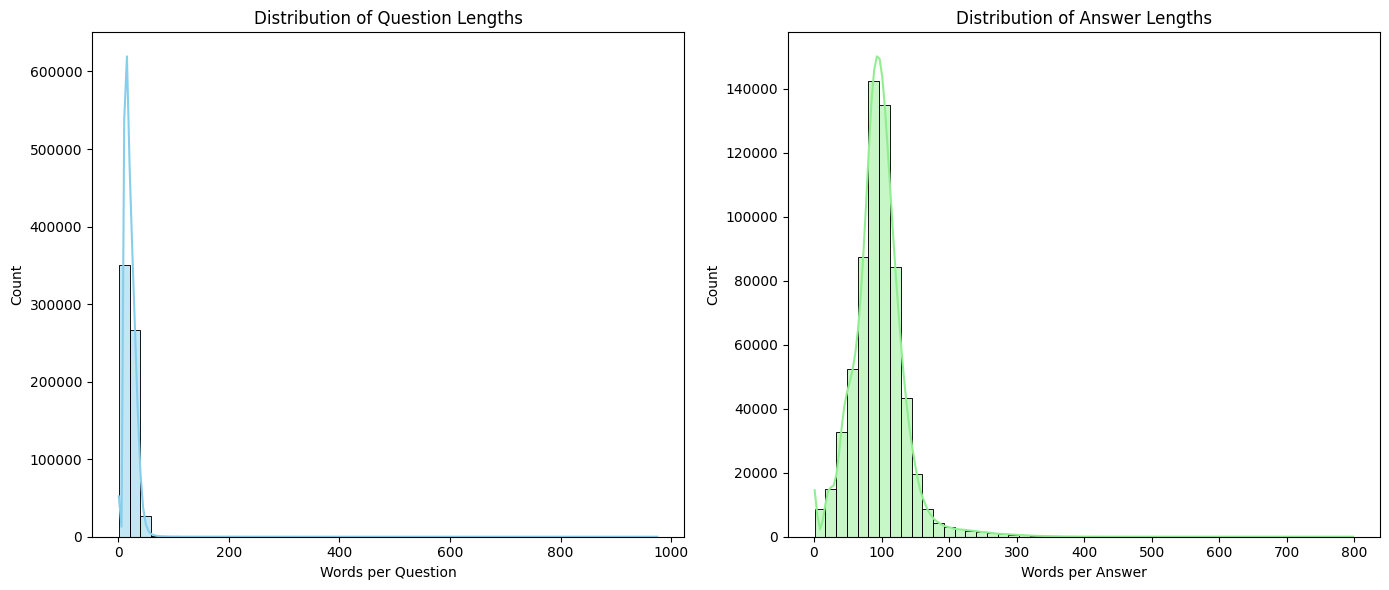

In [ ]:
# Analyze text lengths

# Helper function: count words
def word_count(text):
    return len(text.split())

# Add word count columns
df['question_word_count'] = df['question'].apply(word_count)
df['answer_word_count'] = df['answer'].apply(word_count)

# Basic stats
print("\nQuestion Lengths (words):")
print(df['question_word_count'].describe())

print("\nAnswer Lengths (words):")
print(df['answer_word_count'].describe())

# Plot the distributions
plt.figure(figsize=(14, 6))

# Questions
plt.subplot(1, 2, 1)
sns.histplot(df['question_word_count'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Question Lengths')
plt.xlabel('Words per Question')

# Answers
plt.subplot(1, 2, 2)
sns.histplot(df['answer_word_count'], bins=50, kde=True, color='lightgreen')
plt.title('Distribution of Answer Lengths')
plt.xlabel('Words per Answer')

plt.tight_layout()
plt.show()

### vocabulary, top words, vocabulary size distribution

In [ ]:
# Vocabulary and Frequent Words

from collections import Counter
import re

# Helper simple tokenizer (simple split + remove punctuation)
def simple_tokenize(text):
    # Lowercase, remove non-letters, split
    tokens = re.findall(r'\b\w+\b', text.lower()) #\w matches ASCII characters: [A-Za-z0-9_]
    return tokens

# Tokenize all texts
question_tokens = df['question'].apply(simple_tokenize)
answer_tokens = df['answer'].apply(simple_tokenize)

# Flatten lists
all_question_words = [word for tokens in question_tokens for word in tokens]
all_answer_words = [word for tokens in answer_tokens for word in tokens]

# Vocabulary size
print(f"Vocabulary size in Questions: {len(set(all_question_words))}")
print(f"Vocabulary size in Answers: {len(set(all_answer_words))}")

# Top 20 frequent words
print("\nTop 20 words in Questions:")
print(Counter(all_question_words).most_common(20))

print("\nTop 20 words in Answers:")
print(Counter(all_answer_words).most_common(20))

# 100 least common words
print("\nLeast common 100 words in Questions:")
print(Counter(all_question_words).most_common()[-100:])

print("\nLeast common 100 words in Answers:")
print(Counter(all_answer_words).most_common()[-100:])

Vocabulary size in Questions: 83375
Vocabulary size in Answers: 222778

Top 20 words in Questions:
[('the', 1385681), ('in', 554872), ('what', 520601), ('of', 436567), ('and', 410941), ('you', 294952), ('can', 248750), ('image', 242568), ('this', 226847), ('on', 202006), ('these', 169228), ('is', 167132), ('images', 158357), ('i', 150472), ('a', 122459), ('based', 120303), ('does', 119078), ('explain', 112794), ('about', 112793), ('are', 108427)]

Top 20 words in Answers:
[('the', 5204679), ('of', 2128851), ('and', 1824466), ('in', 1549571), ('a', 1435848), ('to', 1333183), ('is', 859754), ('or', 816530), ('this', 649367), ('as', 504504), ('which', 499898), ('with', 498691), ('are', 472142), ('that', 462612), ('these', 456194), ('image', 409393), ('for', 373419), ('be', 368522), ('can', 323017), ('on', 311264)]

Least common 100 words in Questions:
[('gnathopogon', 1), ('这样会严重吗', 1), ('但是还是有一些疑问', 1), ('你能解释一下为什么我的牙周会出现这种情况吗', 1), ('这是否意味着我需要做进一步的治疗', 1), ('jumonji', 1), ('juxtafoveal'

- we see words in greek characters like "σ1". Latin characters are meaningfull in the medical context so we need to add them to our vocabulary even if it's only a single greek letter.

- we see many strange chinese characters like "我看到这张图里有一个螺丝样的器械在髋部" with a very low frequency (1) so we are going to remove those.

- also for the sake of our analysis, numbers (e.g. 1234 and not IL_6) do not mean very much as vocabulary so we will also remove those.

- the top 20 words are mostly stop words which doesn't imply much meaning. So, we will remove them to see the top 20 meaningful words in our vocabulary.

In [ ]:
# we need to free-up the colab RAM

import gc

# we're done using them
question_tokens, answer_tokens, all_question_words, all_answer_words = None, None, None, None

# Manually trigger garbage collection
gc.collect()

0

In [ ]:
import re
from collections import Counter
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words("english"))

# Unicode ranges:
# Latin:     \u0041–\u007A (A–z, including lowercase)
# Extended:  \u00C0–\u00FF (accents), \u0100–\u017F (Latin Extended-A)
# Greek:     \u0370–\u03FF

# Regex: keep only tokens made of Latin, Greek, or digits (optional underscores)
TOKEN_PATTERN = re.compile(r'\b[\u0041-\u007A\u00C0-\u00FF\u0100-\u017F\u0370-\u03FF0-9_]+\b', re.UNICODE)

def clean_tokenize(text):
    tokens = TOKEN_PATTERN.findall(text.lower())
    cleaned = [tok for tok in tokens if not tok.isdigit()]  # remove pure numbers
    return cleaned

# Apply tokenizer
question_tokens = df['question'].apply(clean_tokenize)
answer_tokens = df['answer'].apply(clean_tokenize)

# Flatten
all_question_words = [word for tokens in question_tokens for word in tokens]
all_answer_words = [word for tokens in answer_tokens for word in tokens]

# Vocabulary
vocab_question = set(all_question_words)
vocab_answer = set(all_answer_words)

print(f"Vocabulary size in Questions (Latin+Greek): {len(vocab_question)}")
print(f"Vocabulary size in Answers (Latin+Greek): {len(vocab_answer)}")

# Frequencies
q_counter = Counter(all_question_words)
a_counter = Counter(all_answer_words)

# Top 20 (excluding stopwords)
top_q = [(w, c) for w, c in q_counter.most_common() if w not in stop_words][:20]
top_a = [(w, c) for w, c in a_counter.most_common() if w not in stop_words][:20]

print("\nTop 20 meaningful words in Questions:")
print(top_q)

print("\nTop 20 meaningful words in Answers:")
print(top_a)

# Least 100 frequent
print("\nLeast common 100 words in Questions:")
print(q_counter.most_common()[-100:])

print("\nLeast common 100 words in Answers:")
print(a_counter.most_common()[-100:])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Vocabulary size in Questions (Latin+Greek): 62707
Vocabulary size in Answers (Latin+Greek): 125756

Top 20 meaningful words in Questions:
[('image', 242568), ('images', 158357), ('based', 120303), ('explain', 112794), ('could', 103505), ('observed', 98427), ('scan', 85303), ('ct', 84503), ('condition', 82146), ('doctor', 79809), ('might', 75000), ('mri', 70216), ('indicate', 66641), ('potential', 59066), ('mean', 59007), ('findings', 55902), ('provided', 52006), ('describe', 50914), ('significance', 50483), ('patient', 50191)]

Top 20 meaningful words in Answers:
[('image', 409393), ('tissue', 256021), ('cells', 237434), ('images', 237088), ('treatment', 214657), ('presence', 202112), ('could', 191852), ('areas', 170274), ('within', 162178), ('tumor', 156242), ('condition', 156072), ('shows', 155301), ('suggests', 151721), ('significant', 147657), ('scan', 137266), ('blood', 137112), ('findings', 136376), ('specific', 135615), ('like', 131534), ('ct', 131374)]

Least common 100 words i

There we go! Now we have a cleaner vocabulary.

In [ ]:
# Function to compute per-document vocabulary size (excluding stopwords)
def vocab_size_per_doc(token_lists):
    return token_lists.apply(lambda tokens: len(set(w for w in tokens if w not in stop_words)))

# Compute per-document vocab size
df['question_vocab_size'] = vocab_size_per_doc(question_tokens)
df['answer_vocab_size'] = vocab_size_per_doc(answer_tokens)

# Show summary
print("\nPer-document vocabulary size (excluding stopwords):\n")
print(df[['question_vocab_size', 'answer_vocab_size']].describe())



Per-document vocabulary size (excluding stopwords):

       question_vocab_size  answer_vocab_size
count        646759.000000      646759.000000
mean             11.025940          49.718982
std               6.525263          18.077153
min               0.000000           0.000000
25%               7.000000          39.000000
50%              10.000000          50.000000
75%              14.000000          59.000000
max             303.000000         293.000000


Interesting! But zero is the minimum.. Let's see how many zeros we have.

In [ ]:
zero_q = (df['question_vocab_size'] == 0).sum()
zero_a = (df['answer_vocab_size'] == 0).sum()

print(f"Number of questions with zero vocabulary size: {zero_q}")
print(f"Number of answers with zero vocabulary size: {zero_a}")

Number of questions with zero vocabulary size: 6634
Number of answers with zero vocabulary size: 5007


Hopefully they're not that many, hence causing no serious problem. So, we can skip them.

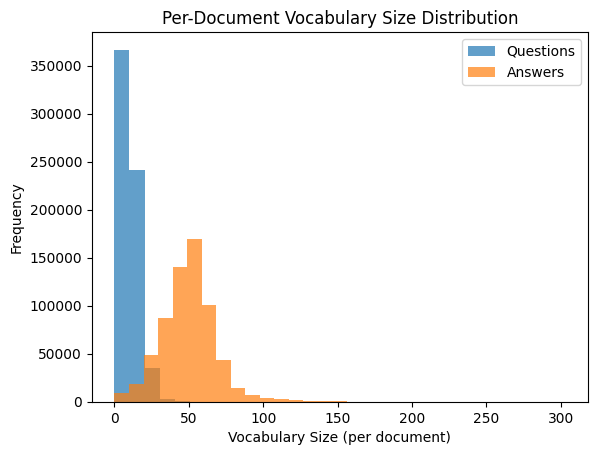

In [ ]:
import matplotlib.pyplot as plt

plt.hist(df['question_vocab_size'], bins=30, alpha=0.7, label='Questions')
plt.hist(df['answer_vocab_size'], bins=30, alpha=0.7, label='Answers')
plt.xlabel("Vocabulary Size (per document)")
plt.ylabel("Frequency")
plt.legend()
plt.title("Per-Document Vocabulary Size Distribution")
plt.show()

## Clustering

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import re

# Tokenizer based on previous policy: lowercase, split on hyphen, keep underscores
def medical_tokenizer(text):
    text = text.lower()
    tokens = re.findall(r'\b\w+\b', text)
    return tokens

# Vectorize the questions
vectorizer = TfidfVectorizer(
    tokenizer=medical_tokenizer,
    min_df=5,           # ignore rare words
    max_features=3000,  # cap vocab size to control sparsity
    stop_words='english'
)

X_tfidf = vectorizer.fit_transform(df['question'])

print(f"TF-IDF matrix shape: {X_tfidf.shape}")


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


TF-IDF matrix shape: (646759, 3000)


KMeans Clustering on Question Vectors

We apply KMeans clustering to group questions potentially into **10 clusters**, corresponding to the 10 most common imaging modalities in the dataset.

Assuming each cluster could represent a set of semantically similar questions, potentially tied to *Modality*-specific language


In [ ]:
from sklearn.cluster import KMeans

# Number of clusters based on number of modalities
num_clusters = 10

# Run KMeans
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
df['question_cluster'] = kmeans.fit_predict(X_tfidf)

# Check distribution
print("Samples per cluster:")
print(df['question_cluster'].value_counts().sort_index())


Samples per cluster:
question_cluster
0     35739
1     10758
2     31626
3     88538
4     94901
5     26026
6     18836
7     52445
8    259672
9     28218
Name: count, dtype: int64


- **Cluster 8** is by far the largest, containing over 250K questions. This suggests it may represent:
  - General-purpose or “template-like” question phrasing
  - Common patterns such as “What does this show?”, “Can you explain...?”
- Clusters **1**, **6**, and **9** are much smaller, which may indicate:
  - Niche topics, distinct language styles or edge cases
- The rest are fairly balanced and support interpretable semantic groupings.

While some size variation is expected in unsupervised clustering, the relative consistency (aside from cluster 8) shows that question text alone already provides meaningful separability.


In [ ]:
from sklearn.metrics import silhouette_score

# Inertia: Sum of squared distances to cluster centers
print(f"Inertia: {kmeans.inertia_:.2f}")


Inertia: 588924.80


- Lower inertia generally indicates **tighter, more compact clusters**
- However, it tends to **decrease with more clusters**, so it is not useful on its own to assess clustering quality unless used in an "elbow curve" comparison
- We report inertia here for completeness, but our **primary evaluation** comes from analyzing cluster content and its alignment with modality as our assumption.


Visualizing Clusters in 2D (SVD)

To visualize the structure of clusters, we reduce the TF-IDF vectors to 2 dimensions using Truncated SVD (a PCA-like method for sparse data).

(PCA crashes due to severe ram usage)

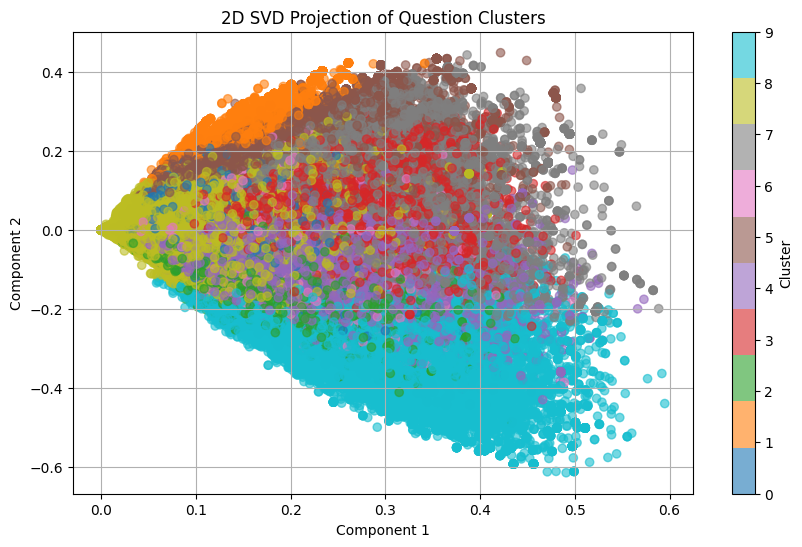

In [ ]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

# Reduce dimensionality without densifying the matrix
svd = TruncatedSVD(n_components=2, random_state=42)
X_2d = svd.fit_transform(X_tfidf)

# Plot clusters
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=df['question_cluster'], cmap='tab10', alpha=0.6)
plt.colorbar(scatter, label='Cluster')
plt.title("2D SVD Projection of Question Clusters")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.show()


To qualitatively interpret each cluster, let's sample a few representative questions from each one.

In [ ]:
# Show a few questions per cluster to interpret themes
for cluster_id in range(num_clusters):
    print(f"\n\n🔹 Cluster {cluster_id}")
    print("=" * 60)
    samples = df[df['question_cluster'] == cluster_id]['question'].sample(3, random_state=cluster_id)
    for i, q in enumerate(samples):
        print(f"\nExample {i+1}: {q}")




🔹 Cluster 0

Example 1: What types of cells are present in the tumor lesion based on the immunohistochemical staining?

Example 2: I noticed there are arrows pointing to certain cells in the biopsy image of my abdominal rash. What do these cells represent and should I be concerned about them?

Example 3: What type of staining method is used to identify the amyloid deposits in the liver tissue?


🔹 Cluster 1

Example 1: What type of imaging modality is used in this image?

Example 2: What type of medical imaging technique is used to capture this image?

Example 3: What type of imaging modality is used in this study?


🔹 Cluster 2

Example 1: I'm looking at the ultrasound results you've shown me, and I'm concerned about what the intensity factor is. Can you explain why this matter for my health?

Example 2: Doctor, could you explain the changes observed in the MRI images before and after treatment?

Example 3: I'm worried that the electrode in my brain might cause damage. How safe is i

Top Terms per Cluster (Centroid Inspection)

We can see the important terms for each cluster by inspecting the centroid vector for the cluster. Let's have a look at the terms with high weights in the centroid of the each cluster.

These terms help us understand the dominant vocabulary that defines each group.

In [ ]:
# Get vocabulary terms
vocab = vectorizer.get_feature_names_out()


# Print top terms from each cluster centroid
top_n = 10  # top N words to show

print("📌 Top terms by cluster centroid:\n")

for i in range(num_clusters):
    print(f"\n🔹 Cluster {i} (Top {top_n} terms):")
    print("-" * 40)
    centroid = kmeans.cluster_centers_[i]
    sorted_terms = centroid.argsort()[::-1]
    top_terms = [vocab[j] for j in sorted_terms[:top_n]]
    print(", ".join(top_terms))


📌 Top terms by cluster centroid:


🔹 Cluster 0 (Top 10 terms):
----------------------------------------
staining, cells, image, patterns, images, observed, tissue, based, does, indicate

🔹 Cluster 1 (Top 10 terms):
----------------------------------------
used, imaging, type, technique, modality, medical, capture, image, obtain, acquire

🔹 Cluster 2 (Top 10 terms):
----------------------------------------
m, doctor, explain, worried, results, really, images, concerned, mean, sure

🔹 Cluster 3 (Top 10 terms):
----------------------------------------
based, potential, clinical, findings, provided, images, implications, diagnosis, observed, significance

🔹 Cluster 4 (Top 10 terms):
----------------------------------------
does, mean, image, indicate, noticed, areas, different, condition, represent, colors

🔹 Cluster 5 (Top 10 terms):
----------------------------------------
type, image, shown, tissue, visible, medical, depicted, tumor, histological, mri

🔹 Cluster 6 (Top 10 terms):
------

looks like each of the clusters contains relatively consistent terms. e.g. cluster0 has key terms: cells, tissue, patterns which relate to microscopic images. cluster0 has ct-scans, cluster 8 has MRI, etc. We will later interpret these more comprehensively.


To evaluate how meaningful the clusters are, let's cross-tabulate each question cluster with the actual `modality` label (from image metadata).

This reveals whether clusters capture:
- Modality-specific language (e.g., “CT”, “X-ray”)
- Or structural/intent-based language (e.g., “What does this mean?”, “Doctor, I'm worried...”)

let's see how much clusters aligned with the modalities which was our initial assumption.

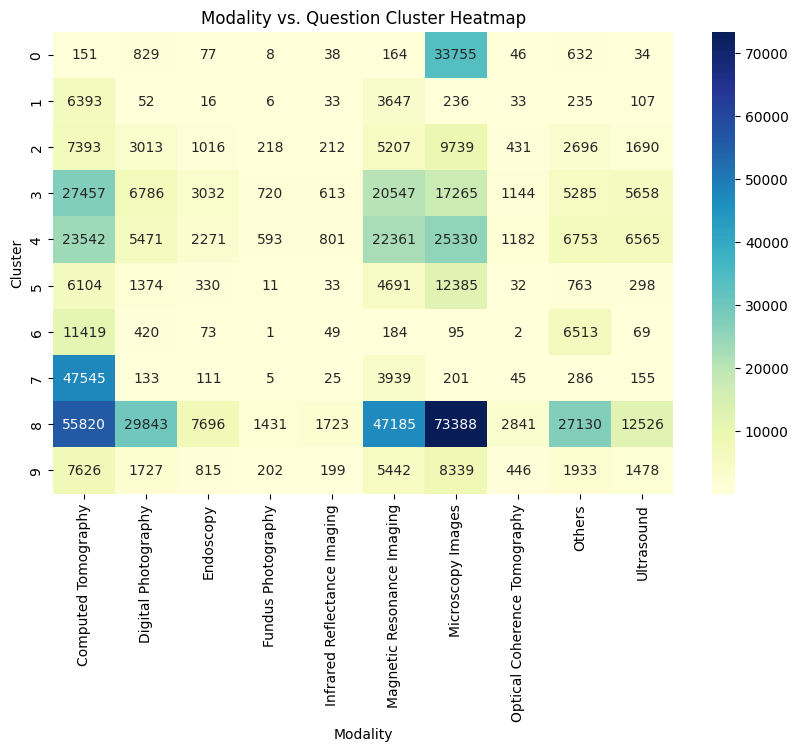

In [ ]:
import pandas as pd

# Focus on top 10 most frequent modalities
top_modalities = df['modality'].value_counts().nlargest(10).index
filtered_df = df[df['modality'].isin(top_modalities)]

# Cross-tabulate: cluster vs modality
modality_cluster_table = pd.crosstab(filtered_df['question_cluster'], filtered_df['modality'])

# Show table
# print("🔍 Modality distribution across clusters:")
# print(modality_cluster_table)

# heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(modality_cluster_table, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Modality vs. Question Cluster Heatmap")
plt.xlabel("Modality")
plt.ylabel("Cluster")
plt.show()


### Cluster Evaluation Summary: Questions vs Modality

To evaluate the quality of our question-based clustering, we examined:
1. **Top terms** from each cluster's centroid (TF-IDF weights)
2. **Sample questions** from each cluster
3. **Modality distribution** across clusters (via heatmap)

This triangulation allowed us to validate how well clusters captured meaningful structure in the data.

---

#### Highlights and Insights from the heatmap and cluster top terms

| Cluster | Theme | Evidence |
|--------|-------------------------------|---------------------------|
| 0 | **Microscopy** | “Staining”, “cells”, “patterns” → almost entirely microscopy modality |
| 1 | **Imaging Modality Identification** | Generic phrasing like “what type of modality...” → spread mostly across imaging types CT and MRI|
| 2 | **Patient Concerns / Personal Queries** | Emotional framing (“worried”, “explain”) → weak modality alignment |
| 3 | **Clinical Interpretation** | Diagnostic reasoning and clinical implications → high in CT, MRI and microscopy |
| 4 | **Meaning & Visual Feature Interpretation** | “What does this mean?” questions → modality-neutral |
| 5 | **Tumor Typing / Visible Abnormalities** | “Type”, “tumor”, “visible”, “MRI” → strong in imaging tasks - MRI, CT, Microscopy |
| 6 | **Chest X-ray Analysis** | “X-ray”, “chest”, “finding” → strong lexical and modality alignment |
| 7 | **CT-based Interpretation** | “CT”, “scan” → clearly clustered by modality |
| 8 | **Template or Broad Explanation Requests** | Generic, General-purpose or “template-like” questions → highly mixed modalities |
| 9 | **Family Health Queries** | “family”, "member", “condition”, "explain" → personal/family focused |

---

#### 📌 Conclusions

- Some clusters are tightly aligned with specific **modalities** (e.g., CT, X-ray, microscopy)
- Others capture **linguistic style** or **functional roles** of questions (e.g., concern, inquiry, interpretation)
- This confirms that unsupervised clustering on question text alone can recover both **clinical semantics** and **communication intent**
- Cluster 8 stands out as a **stylistic or template-driven group**, while clusters like 0, 6, 7 show **strong modality correlation**

This demonstrates that even without using image data or answers, the language of medical questions carries enough signal to produce meaningful groupings.


## Word Embeddings: Training and Semantic Exploration

In this section, we train a Word2Vec embedding model on the `answer` text field to explore how semantic and medical knowledge is captured from the language used in GPT-4V-generated captions.

We use the `gensim` implementation of Word2Vec to:
- Learn 100-dimensional embeddings of medical vocabulary
- Evaluate the learned space by checking similar words
- Visualize semantic structure via PCA and interactive 3D plots


In [ ]:
!pip install -U gensim

  Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.7 MB)
  Attempting uninstall: gensim
    Found existing installation: gensim 4.3.1
    Uninstalling gensim-4.3.1:
      Successfully uninstalled gensim-4.3.1


In [ ]:
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

# Tokenize answers for Word2Vec training
def preprocess_for_w2v(text):
    # Split hyphens but keep underscores, remove stopwords
    tokens = [word for word in simple_preprocess(text.replace('-', ' ')) if word not in stop_words]
    return tokens

# Apply to all answers
tokenized_answers = df['answer'].apply(preprocess_for_w2v)

# Show a few examples
tokenized_answers.sample(3).tolist()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[['medical',
  'image',
  'displays',
  'filling',
  'defect',
  'segment',
  'left',
  'middle',
  'cerebral',
  'artery',
  'mca',
  'defect',
  'represented',
  'cessation',
  'narrowing',
  'arterial',
  'lumen',
  'typically',
  'filled',
  'contrast',
  'cta',
  'scan',
  'suggests',
  'presence',
  'either',
  'arterial',
  'blockage',
  'thrombus',
  'condition',
  'impede',
  'blood',
  'flow',
  'crucial',
  'clinical',
  'investigation',
  'cerebrovascular',
  'diseases',
  'ischemic',
  'strokes',
  'identifying',
  'precise',
  'location',
  'character',
  'defect',
  'important',
  'determining',
  'appropriate',
  'therapeutic',
  'strategies',
  'might',
  'include',
  'use',
  'thrombolytic',
  'therapy',
  'surgical',
  'intervention',
  'restore',
  'proper',
  'blood',
  'flow',
  'affected',
  'brain',
  'regions'],
 ['absolutely',
  'let',
  'explain',
  'simpler',
  'way',
  'line',
  'images',
  'corresponds',
  'different',
  'organ',
  'bodies',
  'mice',
  't

it's gonna take 22 mins

In [ ]:
total_sentences = len(tokenized_answers)
total_words = sum(len(doc) for doc in tokenized_answers)
print(f"Training on {total_sentences} sentences and {total_words} total words.")


Training on 646759 sentences and 37528149 total words.


In [ ]:
from gensim.models import Word2Vec

# Train Word2Vec model
w2v_model = Word2Vec(
    sentences=tokenized_answers,
    vector_size=100,     # dimensionality of word vectors
    window=5,            # context window size
    min_count=5,         # ignore words that appear < 5 times
    workers=4,           # for parallelism
    sg=1,                # use skip-gram (better for small corpora)
    seed=42
)

# Save to reuse if needed
w2v_model.save("answer_word2vec.model")

print(f"Vocabulary size: {len(w2v_model.wv)}")


Vocabulary size: 44200


Word2Vec Training Setup:

We trained the embedding model on tokenized `answer` texts:
- Skip-gram architecture (`sg=1`)
- 100-dimensional vectors
- Context window of 5 words
- Only words with at least 5 occurrences (`min_count=5`)

The resulting vocabulary contains over 40,000 terms extracted from the GPT-4V explanations.


In [ ]:
test_words = ['tumor', 'mri', 'lesion', 'cells', 'treatment', 'bone', 'scan', 'xray']

for word in test_words:
    if word in w2v_model.wv:
        print(f"\n💬 Most similar to '{word}':")
        for sim_word, score in w2v_model.wv.most_similar(word, topn=8):
            print(f"  {sim_word:<15} {score:.4f}")
    else:
        print(f"\n'{word}' not in vocabulary.")



💬 Most similar to 'tumor':
  tumour          0.8998
  tumors          0.7029
  cancer          0.6739
  tumorous        0.6598
  glioblastoma    0.6589
  neoplasm        0.6498
  metastasis      0.6498
  tumoral         0.6450

💬 Most similar to 'mri':
  weighted        0.8347
  mr              0.7838
  ct              0.7720
  flair           0.7359
  hyperintense    0.7193
  stir            0.7183
  wi              0.7163
  dwi             0.7143

💬 Most similar to 'lesion':
  mass            0.8665
  nodule          0.7925
  lesions         0.7263
  circumscribed   0.6745
  expansible      0.6718
  cyst            0.6642
  sizeable        0.6522
  expansile       0.6453

💬 Most similar to 'cells':
  cell            0.7934
  phagocytes      0.7355
  preadipocytes   0.7137
  proliferating   0.7128
  degranulated    0.6897
  binuclear       0.6880
  phagocyte       0.6859
  clusters        0.6809

💬 Most similar to 'treatment':
  treatments      0.7504
  therapy         0.6771
  manag

Nearest Neighbors: Checking Embeddings

To evaluate whether the Word2Vec model captured valid medical semantics, we queried the most similar words for anchors such as `tumor`, `scan`, `cells`, and `treatment`.

For example:
- `"tumor"` was surrounded by: `tumour`, `neoplasm` (A neoplasm, commonly called a tumor, is an abnormal mass of tissue resulting from the excessive and uncontrolled growth of cells), `glioblastoma` (the most aggressive and most common type of cancer that originates in the brain), `metastasis` (the process by which cancer cells from a primary tumor spread to distant parts of the body)
- `"scan"` was close to: `ct`, `mri`, `cect`, `noncontrast`

Very interesting!

It shows the model has successfully learned domain-specific relationships even from limited data.


### Word Embedding Analogies

To further assess whether the learned Word2Vec embeddings capture meaningful relationships between medical terms, we tested **analogy-style queries** of the form: *A + B - C = ?*  *(e.g. in good embeddings: "King" - "man" + "woman" ≈ "Queen")*

In [ ]:
try:
    result = w2v_model.wv.most_similar(positive=['tumor', 'therapy'], negative=['cancer'], topn=5)
    print("Analogy: tumor + therapy - cancer:")
    for word, score in result:
        print(f"  {word:<15} {score:.4f}")
except KeyError as e:
    print(f"Missing word: {e}")


Analogy: tumor + therapy - cancer:
  radiosurgical   0.6032
  chemotherapy    0.6024
  debulking       0.5888
  therapies       0.5869
  antitubercular  0.5736


**Analogy:** `"tumor" + "therapy" - "cancer"`  
**Result:** `radiosurgical`, `chemotherapy`, `debulking`, `therapies`, `antitubercular`

This suggests the model understands that **"tumor" treated like "cancer"** leads to therapies like **chemotherapy** and **radiosurgery** — a strong sign of domain-aware vector space structure.

In [ ]:
try:
    result = w2v_model.wv.most_similar(positive=['cells', 'immune'], negative=['infection'], topn=5)
    print("Analogy: cells + immune - infection:")
    for word, score in result:
        print(f"  {word:<15} {score:.4f}")
except KeyError as e:
    print(f"Missing word: {e}")


Analogy: cells + immune - infection:
  ctls            0.7053
  tils            0.6871
  lymphocytes     0.6802
  helper          0.6680
  phagocyte       0.6651


**Analogy:** `"cells" + "immune" - "infection"`  
**Result:** `ctls` (These are specialized immune cells that play a crucial role in fighting infections and eliminating cancer cells), `tils`, `lymphocytes`, `helper`, `phagocyte`

These terms are tightly connected to **immunological cell types**, indicating the model has learned **functional and biological groupings** even from unstructured, generated text.

These results confirm that the model embeds semantically rich relationships, and supports analogical reasoning within biomedical language.

### 2D and 3D PCA Visualization of Word Embeddings

We projected a set of anchor words and their top 5 most similar terms into 2D and 3D using PCA (to reduce dimensionality).

The interactive plot reveals clear **semantic clustering**.

This further validates that even a lightweight Word2Vec model can learn **clinically meaningful concepts** from radiology reports.


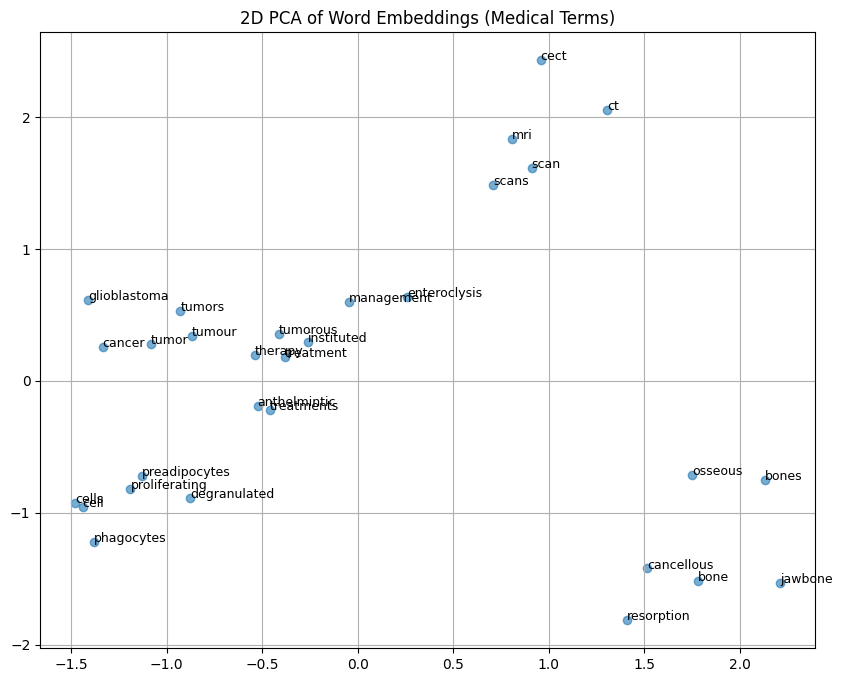

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Pick anchor words to visualize + their most similar terms
anchors = ['tumor', 'scan', 'cells', 'treatment', 'bone']
words_to_plot = set(anchors)

# Add top-5 similar words for each
for word in anchors:
    if word in w2v_model.wv:
        sim_words = [w for w, _ in w2v_model.wv.most_similar(word, topn=5)]
        words_to_plot.update(sim_words)

# Get vectors and labels
words_to_plot = list(words_to_plot)
vectors = [w2v_model.wv[w] for w in words_to_plot]

# Reduce to 2D
pca = PCA(n_components=2)
vec_2d = pca.fit_transform(vectors)

# Plot
plt.figure(figsize=(10, 8))
plt.scatter(vec_2d[:, 0], vec_2d[:, 1], alpha=0.6)

for i, word in enumerate(words_to_plot):
    plt.annotate(word, (vec_2d[i, 0], vec_2d[i, 1]), fontsize=9)

plt.title("2D PCA of Word Embeddings (Medical Terms)")
plt.grid(True)
plt.show()


Interesting results!

Let's do it in 3D with a better visualization

In [ ]:
from sklearn.decomposition import PCA
import plotly.express as px
import pandas as pd

# --- Input: your loaded model ---
# w2v_model = Word2Vec.load("answer_word2vec.model")

# 📌 Define anchor medical terms and get top-5 similar for each
anchor_words = ['tumor', 'scan', 'cells', 'treatment', 'bone', 'family']
words_to_plot = set(anchor_words)

for word in anchor_words:
    if word in w2v_model.wv:
        similar_words = [w for w, _ in w2v_model.wv.most_similar(word, topn=5)]
        words_to_plot.update(similar_words)

# --- Prepare data for PCA ---
words_to_plot = list(words_to_plot)
vectors = [w2v_model.wv[word] for word in words_to_plot]

# 3D PCA
pca = PCA(n_components=3)
vec_3d = pca.fit_transform(vectors)

# Create DataFrame
df_plot = pd.DataFrame(vec_3d, columns=["PC1", "PC2", "PC3"])
df_plot["word"] = words_to_plot
df_plot["group"] = ["anchor" if word in anchor_words else "related" for word in words_to_plot]

# --- Plotly interactive 3D scatter ---
fig = px.scatter_3d(
    df_plot, x="PC1", y="PC2", z="PC3",
    color="group", text="word",
    title="3D PCA of Word Embeddings (Medical Terms)",
    labels={"group": "Word Type"},
)

fig.update_traces(marker=dict(size=6), textposition='top center')
fig.update_layout(showlegend=True)
fig.show()


We observe tight clustering not only for medical terms (`tumor`, `scan`, `treatment`) but also for **general, human-centered language**:

> Words like `family`, `father`, `mother`, `child`, and `loved` naturally group together.



Cool!

In [ ]:
# save and download the model
from google.colab import files
w2v_model.save("answer_word2vec.model")
files.download("answer_word2vec.model")

## Simple Keyword-Based Retrieval System

To conclude our exploratory analysis, we implemented a minimal **keyword search engine** over the `answer` texts using an inverted index.

- We built an inverted index mapping each word after tokenization (and removing stop words) to the rows in which it appears.
- A user query returns the `answer` texts containing the keyword.
- It’s efficient, literal (no ranking), and suitable for exploratory keyword probing
- It can be extended to support multi-word queries, rank results by word frequency or TF-IDF, etc

In [ ]:
# Simple keyword search

# Build inverted index (word → list of row indices)
from collections import defaultdict

inverted_index = defaultdict(set)

for idx, answer in enumerate(df['answer']):
    tokens = simple_tokenize(answer)
    for token in tokens:
        if token not in stop_words:
            inverted_index[token].add(idx)

# Simple search function
def keyword_search(query, first_k=5):
    query = query.lower()
    matches = inverted_index.get(query, [])
    print(f"\n🔍 Found {len(matches)} result(s) for keyword: '{query}'")
    for i, idx in enumerate(list(matches)[:first_k]):
        print(f"\nResult {i+1}:\n{df.iloc[idx]['answer'][:500]}...")

# Example usage:
keyword_search("tumor")



🔍 Found 612 result(s) for keyword: 'tumor'

Result 1:
In the CT images presented, major TCCI shows a pronounced invasion with clear damages extending through both the inner and outer cortices of the cartilage, resulting in a significantly altered structural appearance. This extensive invasion categorizes it as T4 in tumor staging for laryngeal tumors, as per the AJCC 7th edition staging manual. On the other hand, minor TCCI demonstrates limited invasion confined mainly to the inner cortex, evident from the minimal disruption seen on the CT scan. Th...

Result 2:
The MRI image reveals a significant mass extending beyond the right parametrium to the pelvic wall, indicating recurrent cervical cancer. The tumor's borders are irregular, and it appears to compress surrounding structures. Notably, there is displacement of adjacent tissues, which suggests invasive behavior. The involvement of the pelvic wall is critical for staging and treatment planning, as it may affect surgical options and

In [ ]:
keyword_search("lesion")
keyword_search("bone")
keyword_search("ultrasound")


🔍 Found 441 result(s) for keyword: 'lesion'

Result 1:
The spindle-shaped morphology combined with the presence of bizarre nuclei and frequent mitoses in image B suggests a high degree of cellular atypia and disorganization typical of malignant tumors. These characteristics, especially the high mitotic rate, often indicate aggressive neoplastic growth, pointing towards a possible diagnosis of a high-grade malignancy. The necrosis and hemorrhage visible in image A also support the aggressive nature of the lesion, as these features commonly occur in r...

Result 2:
The red arrows in the images point to a cystic lesion located at the fifth lumbar (L5) nerve root and particularly in the foraminal area, as observed in the lumbar spine's MRI. The cystic appearances, indicated by hyperintense areas, suggest an accumulation of fluid or other material, which can cause pressure on adjacent nerve roots and spinal structures. This pressure can lead to symptoms such as pain, numbness, or weakness 

In [ ]:
keyword_search("does_our_project_lack_anything?")


🔍 Found 0 result(s) for keyword: 'does_our_project_lack_anything?'


: )

## Next parts to be added!

#Train ML Models

In [ ]:
!pip install -U datasets==2.19.1 huggingface_hub==0.21.2 fsspec==2023.12.0

In [ ]:
from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing      import LabelEncoder
from sklearn.model_selection    import train_test_split
from sklearn.linear_model       import LogisticRegression
from sklearn.metrics            import classification_report
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import classification_report


##Data Pre-processing

 Preprocessing and Vocabulary Cleanup

Before training any models, we carried out a careful preliminary analysis of the text data from the **PubMedVision\_InstructionTuning\_VQA** dataset. This helped identify several types of noise and irrelevant tokens. To improve data quality and ensure meaningful feature extraction, we applied the following preprocessing steps:

---

**Character Set Filtering**

* **Greek letters** such as “σ1” appeared in some texts. Since Greek symbols can have domain-specific meaning in biomedical contexts (e.g., variable names, protein markers), we kept these if they occurred alongside Latin characters or in meaningful biomedical terms.

* **Chinese characters**, like “我看到这张图里有一个螺丝样的器械在髋部”, appeared only once and were not relevant to the primarily English dataset. We removed all samples containing Chinese or other CJK characters to avoid noise.

---

**Number Removal**

Pure numbers (e.g., 1234) were often present but didn’t carry useful meaning for this task. Therefore, we removed numeric tokens **unless** they were part of alphanumeric biomedical terms (e.g., “IL\_6”).

---

**Stopword Removal**

A review of the top 20 most frequent words showed they were mostly English stopwords such as “the”, “is”, and “of”, which don’t contribute meaningful content. We removed standard English stopwords to expose more informative tokens in the vocabulary.

---

**Final Tokenization Strategy**

We applied a custom regular expression pattern to retain only useful tokens:

* Latin characters (A–Z, a–z)
* Extended Latin and Greek characters
* Digits (when part of alphanumeric terms)
* Underscores

This helped keep terms like “IL\_6”, “mri\_scan”, and “σ3” while filtering out irrelevant symbols or unsupported characters.

---

**Sampling and Cleaning**

We sampled 10,000 examples from the dataset. The pipeline included:

1. Concatenating question and answer text
2. Removing modality labels with fewer than 20 occurrences
3. Filtering out questions containing Chinese characters
4. Cleaning and lowercasing the text
5. Removing punctuation, numbers, and stopwords

After this step, we obtained a cleaned dataset of question texts and modality labels, which were split into training and test sets using stratified sampling.

---


In [ ]:
from collections import Counter
import re
import string
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load PubMedVision dataset with the correct config
dataset = load_dataset(
    "FreedomIntelligence/PubMedVision",
    name="PubMedVision_InstructionTuning_VQA",
    split="train",
    streaming=True
)

In [ ]:
questions = []
modalities = []
cleaned_questions = []
cleaned_modalities = []

# Download stopwords if not already done
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
# Regex: keep only tokens made of Latin, Greek, or digits (optional underscores)
TOKEN_PATTERN = re.compile(r'\b[\u0041-\u007A\u00C0-\u00FF\u0100-\u017F\u0370-\u03FF0-9_]+\b', re.UNICODE)

def is_chinese(text):
    """Detects if text contains any CJK characters."""
    return re.search(r'[\u4e00-\u9fff]', text) is not None

def clean_text(text):
    # Lowercase
    text = text.lower()

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove tokens with only digits (keep alphanumerics like IL_6)
    text = re.sub(r'\b\d+\b', '', text)

    # Remove stopwords
    # tokens = text.split()
    tokens = TOKEN_PATTERN.findall(text.lower())
    tokens = [t for t in tokens if t not in stop_words]

    return ' '.join(tokens)


def prepare_data(sample_size = 20000, input_type = "A"):
  questions = []
  modalities = []
  cleaned_questions = []
  cleaned_modalities = []
  sample_ds = dataset.shuffle(buffer_size=50_000, seed=42).take(sample_size)
  # 3. Extract inputs (questions) and labels (modalities)
  for ex in sample_ds:
      q = ex["conversations"][1]["value"]
      if input_type == "Q":
        q = ex["conversations"][0]["value"]
      elif input_type == "QA":
        q = ex["conversations"][0]["value"] + " " + ex["conversations"][1]["value"]

      m = ex["modality"]
      questions.append(q)
      modalities.append(m)
  mod_counts = Counter(modalities)
  good_mods = {mod for mod, cnt in mod_counts.items() if cnt >= 20}

  filtered = [
      (q, m) for q, m in zip(questions, modalities)
      if m in good_mods
  ]
  questions, modalities = zip(*filtered)

  for q, m in zip(questions, modalities):
    if is_chinese(q):
        continue  # skip Chinese or other CJK-character samples
    cleaned_q = clean_text(q)
    if cleaned_q.strip():  # keep non-empty questions
        cleaned_questions.append(cleaned_q)
        cleaned_modalities.append(m)
  return questions, modalities, cleaned_questions, cleaned_modalities


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
questions, modalities, cleaned_questions, cleaned_modalities = prepare_data(sample_size= 10000)
le = LabelEncoder()
y = le.fit_transform(cleaned_modalities)
X_train, X_test, y_train, y_test = train_test_split(
    cleaned_questions, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

## Modeling


###**Model Training: Predicting Imaging Modality**

The core task in this project is to **predict the imaging modality** used in a medical case based solely on the **answer text** from a question–answer pair. After performing vocabulary cleaning and text preprocessing, we experimented with several machine learning models of increasing complexity.

This section presents our approach to training and evaluating a diverse set of classifiers, from linear models to RNNs and transformer-based architectures (without fine-tuning).

---

**Task Definition**
The classification task involves assigning one of several predefined medical imaging modalities (e.g., Computed Tomography, MRI, Endoscopy) to a given answer. The cleaned text from the answer was used as the input feature for all models.

---

### Models Trained

We implemented and trained the following models on the processed dataset:


1. **Logistic Regression (LR)**: A simple linear classifier that performed surprisingly well as a baseline.
It models a direct linear relationship between features and class probabilities.


2. **Linear Support Vector Classifier (SVC)**: Another strong linear model that aims to maximize the margin between class decision boundaries.
It often performed slightly better than LR on rare classes due to its margin-based optimization.


3. **Bi-GRU (Bidirectional Gated Recurrent Unit)**: A recurrent neural network capable of capturing sequential dependencies in the input.
Bi-GRU reads the input text from both directions, making it suitable for natural language classification.


4. **Bi-LSTM (Bidirectional Long Short-Term Memory)**: Similar to Bi-GRU, but with more flexible gating mechanisms to model long-term dependencies in the text.
It performed similarly to Bi-GRU, with slightly better recall on longer answers.
Both Bi-GRU and Bi-LSTM were trained without pre-trained embeddings, using our cleaned tokenized data.


5. **Transformer-based Model (PubMedBERT embeddings)**: We used a frozen version of **PubMedBERT**, a pretrained biomedical transformer, as a feature extractor.
We extracted either CLS-token or mean-pooled embeddings for each answer and passed them into:

  1.   Logistic RegressionList item
  2.   Linear SVC

This hybrid setup (frozen transformer + linear classifier) allowed us to leverage rich semantic features from PubMedBERT **without the cost of fine-tuning**.


All models were trained on stratified train/test splits to ensure class balance across folds.

---

### Metrics for Model Evaluation

To evaluate the classification performance across all imaging modalities — including rare ones — we focus on the following key metrics:

* **Macro F1-score**: The main metric we use, as it gives equal weight to all classes regardless of their frequency. It reflects how well the model performs across both common and rare modalities.

* **Accuracy**: Measures the overall percentage of correct predictions. Useful for a general overview, but can be biased toward frequent classes.

* **Weighted F1-score**: Accounts for class imbalance by weighting each class’s F1-score by its support. Helpful for checking whether the model is overly focused on dominant classes.

These metrics together provide a balanced view of the model's effectiveness.





###LogisticRegression

In [ ]:
def build_pipeline(model, max_features=1000, ngram_range=(1,1)):
    tfidf = TfidfVectorizer(max_features=max_features, ngram_range=ngram_range)
    pipe = Pipeline([
        ("tfidf", tfidf),
        ("clf", model)
    ])
    return pipe

def run_experiment(model, le, max_features=1000, ngram_range=(1,1), stratify=True, random_state=42):

    pipe = build_pipeline(model, max_features, ngram_range)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    print(f"Model: {model.__class__.__name__}")
    print(classification_report(y_test, y_pred, target_names=le.classes_))

In [ ]:
logreg = LogisticRegression(max_iter=1000, random_state=42, verbose=2)
run_experiment(logreg, le)

Model: LogisticRegression
                              precision    recall  f1-score   support

         Computed Tomography       0.70      0.87      0.78       597
         Digital Photography       0.62      0.47      0.54       155
                   Endoscopy       0.80      0.10      0.17        42
          Fundus Photography       0.40      0.17      0.24        12
Infrared Reflectance Imaging       0.00      0.00      0.00        13
  Magnetic Resonance Imaging       0.78      0.74      0.76       340
           Microscopy Images       0.82      0.91      0.87       553
Optical Coherence Tomography       0.58      0.41      0.48        17
                      Others       0.55      0.41      0.47       165
                  Ultrasound       0.86      0.51      0.64        87

                    accuracy                           0.74      1981
                   macro avg       0.61      0.46      0.49      1981
                weighted avg       0.73      0.74      0.72   

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize(

**The best Base** 👇

---



In [ ]:
#Increase max-iter
logreg = LogisticRegression(max_iter=10000, random_state=42, verbose=2)
run_experiment(logreg, le, max_features=10000)

Model: LogisticRegression
                              precision    recall  f1-score   support

         Computed Tomography       0.71      0.89      0.79       597
         Digital Photography       0.71      0.43      0.53       155
                   Endoscopy       1.00      0.05      0.09        42
          Fundus Photography       0.50      0.25      0.33        12
Infrared Reflectance Imaging       0.00      0.00      0.00        13
  Magnetic Resonance Imaging       0.79      0.74      0.76       340
           Microscopy Images       0.81      0.95      0.88       553
Optical Coherence Tomography       1.00      0.29      0.45        17
                      Others       0.65      0.41      0.50       165
                  Ultrasound       0.91      0.47      0.62        87

                    accuracy                           0.76      1981
                   macro avg       0.71      0.45      0.50      1981
                weighted avg       0.76      0.76      0.73   

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.5s finished
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize(

In [ ]:
#Increase max-iter
logreg = LogisticRegression(max_iter=10000, random_state=42, verbose=2)
run_experiment(logreg, le, max_features=50000,ngram_range=(1,3) )

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.7s finished


Model: LogisticRegression
                              precision    recall  f1-score   support

         Computed Tomography       0.68      0.90      0.77       597
         Digital Photography       0.74      0.38      0.50       155
                   Endoscopy       0.00      0.00      0.00        42
          Fundus Photography       1.00      0.08      0.15        12
Infrared Reflectance Imaging       0.00      0.00      0.00        13
  Magnetic Resonance Imaging       0.78      0.73      0.76       340
           Microscopy Images       0.79      0.96      0.86       553
Optical Coherence Tomography       1.00      0.18      0.30        17
                      Others       0.74      0.36      0.48       165
                  Ultrasound       0.88      0.40      0.55        87

                    accuracy                           0.74      1981
                   macro avg       0.66      0.40      0.44      1981
                weighted avg       0.73      0.74      0.71   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



####Logistic Regression: Hyperparameter Tuning Summary

To evaluate the impact of key hyperparameters on logistic regression performance, we tested three variations using different values for:

* **`max_iter`**: Controls convergence during optimization
* **`max_features`**: Limits vocabulary size in TF-IDF vectorization
* **`ngram_range`**: Expands feature space by including bigrams and trigrams

---

### What We Tried

1. **Default settings**

   * `max_iter=1000`, `max_features=1000`, `ngram_range=(1,1)`
   * Accuracy: 0.74 | Macro F1: 0.49
     → Good performance on frequent classes, but **poor recall** on rare ones.

2. **Increased iterations and vocabulary**

   * `max_iter=10000`, `max_features=10000`, `ngram_range=(1,1)`
   * Accuracy: 0.76 | Macro F1: **0.50**
     → Slight improvement across many classes. Better convergence and coverage of relevant terms helped capture more patterns, especially in rare classes like “Fundus Photography”.

3. **Large vocabulary + trigrams**

   * `max_iter=10000`, `max_features=50000`, `ngram_range=(1,3)`
   * Accuracy: 0.74 | Macro F1: 0.44
     → Performance **dropped**. Including trigrams introduced sparse, noisy features and likely caused overfitting. Rare classes performed worse.

---

###Best Configuration

> **`max_iter=10000`, `max_features=10000`, `ngram_range=(1,1)`**

* Achieved the best **accuracy** (0.76) and **macro F1-score** (0.50)
* Balanced learning across both high- and low-frequency classes
* Avoided overfitting from excessive features or n-gram noise



###Linear SVC

In [ ]:
from sklearn.pipeline        import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.svm             import LinearSVC
from sklearn.metrics         import classification_report
def build_linearsvc_pipeline(model, max_features=1000, ngram_range=(1,1)):
    tfidf = TfidfVectorizer(max_features=max_features, ngram_range=ngram_range)
    svc_pipe = Pipeline([
    ("tfidf", tfidf),
    ("clf",   model),])
    return svc_pipe

def run_linearsvc_experiment(model, le, max_features=1000, ngram_range=(1,1), stratify=True, random_state=42):

    pipe = build_linearsvc_pipeline(model, max_features, ngram_range)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    print(f"Model: {model.__class__.__name__}")
    print(classification_report(y_test, y_pred, target_names=le.classes_))

In [ ]:

lsvc = LinearSVC(C=1.0,max_iter=1000,random_state=42)
run_linearsvc_experiment(lsvc, le)

Model: LinearSVC
                              precision    recall  f1-score   support

         Computed Tomography       0.72      0.83      0.77       597
         Digital Photography       0.57      0.46      0.51       155
                   Endoscopy       0.40      0.19      0.26        42
          Fundus Photography       0.44      0.33      0.38        12
Infrared Reflectance Imaging       0.00      0.00      0.00        13
  Magnetic Resonance Imaging       0.77      0.74      0.76       340
           Microscopy Images       0.84      0.90      0.87       553
Optical Coherence Tomography       0.44      0.41      0.42        17
                      Others       0.48      0.36      0.42       165
                  Ultrasound       0.78      0.61      0.68        87

                    accuracy                           0.73      1981
                   macro avg       0.54      0.49      0.51      1981
                weighted avg       0.72      0.73      0.72      1981



In [ ]:
lsvc = LinearSVC(C=1.0,max_iter=10000,random_state=42)
run_linearsvc_experiment(lsvc, le)

Model: LinearSVC
                              precision    recall  f1-score   support

         Computed Tomography       0.72      0.83      0.77       597
         Digital Photography       0.57      0.46      0.51       155
                   Endoscopy       0.40      0.19      0.26        42
          Fundus Photography       0.44      0.33      0.38        12
Infrared Reflectance Imaging       0.00      0.00      0.00        13
  Magnetic Resonance Imaging       0.77      0.74      0.76       340
           Microscopy Images       0.84      0.90      0.87       553
Optical Coherence Tomography       0.44      0.41      0.42        17
                      Others       0.48      0.36      0.42       165
                  Ultrasound       0.78      0.61      0.68        87

                    accuracy                           0.73      1981
                   macro avg       0.54      0.49      0.51      1981
                weighted avg       0.72      0.73      0.72      1981



In [ ]:
lsvc = LinearSVC(C=3.0,max_iter=1000,random_state=42)
run_linearsvc_experiment(lsvc, le)

Model: LinearSVC
                              precision    recall  f1-score   support

         Computed Tomography       0.72      0.81      0.76       597
         Digital Photography       0.53      0.46      0.49       155
                   Endoscopy       0.23      0.17      0.19        42
          Fundus Photography       0.50      0.33      0.40        12
Infrared Reflectance Imaging       0.00      0.00      0.00        13
  Magnetic Resonance Imaging       0.75      0.73      0.74       340
           Microscopy Images       0.84      0.88      0.86       553
Optical Coherence Tomography       0.37      0.41      0.39        17
                      Others       0.47      0.38      0.42       165
                  Ultrasound       0.68      0.57      0.62        87

                    accuracy                           0.72      1981
                   macro avg       0.51      0.47      0.49      1981
                weighted avg       0.70      0.72      0.71      1981



In [ ]:
lsvc = LinearSVC(C=0.3,max_iter=1000,random_state=42)
run_linearsvc_experiment(lsvc, le)

Model: LinearSVC
                              precision    recall  f1-score   support

         Computed Tomography       0.71      0.86      0.78       597
         Digital Photography       0.63      0.48      0.54       155
                   Endoscopy       0.54      0.17      0.25        42
          Fundus Photography       0.36      0.33      0.35        12
Infrared Reflectance Imaging       0.00      0.00      0.00        13
  Magnetic Resonance Imaging       0.77      0.75      0.76       340
           Microscopy Images       0.83      0.92      0.87       553
Optical Coherence Tomography       0.46      0.35      0.40        17
                      Others       0.57      0.36      0.44       165
                  Ultrasound       0.87      0.60      0.71        87

                    accuracy                           0.75      1981
                   macro avg       0.57      0.48      0.51      1981
                weighted avg       0.73      0.75      0.73      1981



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
lsvc = LinearSVC(C=0.3,max_iter=1000,random_state=42)
run_linearsvc_experiment(lsvc, le, max_features=10000)

Model: LinearSVC
                              precision    recall  f1-score   support

         Computed Tomography       0.73      0.88      0.80       597
         Digital Photography       0.72      0.49      0.58       155
                   Endoscopy       0.64      0.17      0.26        42
          Fundus Photography       0.60      0.75      0.67        12
Infrared Reflectance Imaging       0.00      0.00      0.00        13
  Magnetic Resonance Imaging       0.78      0.77      0.77       340
           Microscopy Images       0.84      0.94      0.89       553
Optical Coherence Tomography       0.56      0.29      0.38        17
                      Others       0.63      0.42      0.51       165
                  Ultrasound       0.92      0.64      0.76        87

                    accuracy                           0.77      1981
                   macro avg       0.64      0.54      0.56      1981
                weighted avg       0.76      0.77      0.76      1981



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
lsvc = LinearSVC(C=0.3,max_iter=1000,random_state=42)
run_linearsvc_experiment(lsvc, le, max_features=100000)

Model: LinearSVC
                              precision    recall  f1-score   support

         Computed Tomography       0.73      0.88      0.80       597
         Digital Photography       0.71      0.46      0.56       155
                   Endoscopy       0.64      0.17      0.26        42
          Fundus Photography       0.60      0.75      0.67        12
Infrared Reflectance Imaging       0.00      0.00      0.00        13
  Magnetic Resonance Imaging       0.79      0.76      0.77       340
           Microscopy Images       0.83      0.95      0.89       553
Optical Coherence Tomography       0.62      0.29      0.40        17
                      Others       0.64      0.42      0.51       165
                  Ultrasound       0.92      0.64      0.76        87

                    accuracy                           0.77      1981
                   macro avg       0.65      0.53      0.56      1981
                weighted avg       0.76      0.77      0.75      1981



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**The best Base** 👇

---



In [ ]:
lsvc = LinearSVC(C=0.3,max_iter=1000,random_state=42)
run_linearsvc_experiment(lsvc, le, max_features=10000, ngram_range=(1,2))

lsvc = LinearSVC(C=0.3,max_iter=1000,random_state=42)
run_linearsvc_experiment(lsvc, le, max_features=10000, ngram_range=(1,3))

Model: LinearSVC
                              precision    recall  f1-score   support

         Computed Tomography       0.74      0.88      0.80       597
         Digital Photography       0.70      0.52      0.59       155
                   Endoscopy       0.55      0.14      0.23        42
          Fundus Photography       0.57      0.67      0.62        12
Infrared Reflectance Imaging       0.00      0.00      0.00        13
  Magnetic Resonance Imaging       0.80      0.77      0.78       340
           Microscopy Images       0.84      0.95      0.89       553
Optical Coherence Tomography       0.67      0.35      0.46        17
                      Others       0.68      0.43      0.53       165
                  Ultrasound       0.92      0.64      0.76        87

                    accuracy                           0.78      1981
                   macro avg       0.65      0.54      0.57      1981
                weighted avg       0.77      0.78      0.76      1981



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model: LinearSVC
                              precision    recall  f1-score   support

         Computed Tomography       0.74      0.88      0.80       597
         Digital Photography       0.70      0.52      0.59       155
                   Endoscopy       0.55      0.14      0.23        42
          Fundus Photography       0.57      0.67      0.62        12
Infrared Reflectance Imaging       0.00      0.00      0.00        13
  Magnetic Resonance Imaging       0.80      0.77      0.78       340
           Microscopy Images       0.84      0.95      0.89       553
Optical Coherence Tomography       0.67      0.35      0.46        17
                      Others       0.70      0.45      0.55       165
                  Ultrasound       0.92      0.63      0.75        87

                    accuracy                           0.78      1981
                   macro avg       0.65      0.54      0.57      1981
                weighted avg       0.77      0.78      0.76      1981



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### Linear SVC: Hyperparameter Tuning Summary

We performed a series of experiments using **Linear Support Vector Classification (LinearSVC)** to evaluate the effect of three key hyperparameters:

* **`C`**: Controls regularization strength (lower = stronger regularization)
* **`max_features`**: Vocabulary size used in TF-IDF vectorization
* **`ngram_range`**: Extends features beyond unigrams

---

### What We Tested

1. **Default settings (`C=1.0`, `max_features=1000`)**

   * Accuracy: 0.73 | Macro F1: 0.51
     → Solid baseline performance; precision better than recall, especially on major classes.

2. **Higher iterations (`max_iter=10000`)**

   * No significant improvement over default.
     → Model already converged at 1000 iterations.

3. **Varying regularization strength (`C`)**

   * `C=3.0`: Accuracy dropped slightly | Macro F1: 0.49
   * `C=0.3`: Improved balance; rare classes benefited slightly
     → **Stronger regularization (`C=0.3`)** performed better on rare and medium classes.

4. **Increased `max_features`**

   * `max_features=10k–100k`: Helped performance, especially on rare classes
   * Best result with `C=0.3` and `max_features=10000`:

     * Accuracy: 0.77 | Macro F1: 0.56

5. **Adding bigrams (`ngram_range=(1,2)`)**

   * Further improved performance:

     * Accuracy: **0.78** | Macro F1: **0.57**
   * Bigrams helped model contextual terms (e.g., “CT scan”, “image shows”)

---

### Best Configuration

> **`C=0.3`, `max_features=10000`, `ngram_range=(1,2)`**

* Achieved the highest accuracy (0.78) and macro F1 (0.57)
* Strong balance across classes
* Better generalization on underrepresented modalities

---

### Why This Configuration Worked

* **Lower `C`** (stronger regularization) prevented overfitting on frequent classes
* **More features** gave richer context without overfitting
* **Bigrams** improved semantic understanding and class separation


### Prepare data for RNN models


Recurrent neural networks (RNNs) like **Bi-GRU** and **Bi-LSTM** require input text to be converted into fixed-length sequences of integers. To prepare the cleaned question texts for RNN-based models, we applied the following preprocessing steps:

#### 1. **Tokenization and Sequencing**

* We used Keras's `Tokenizer` to convert each cleaned question into a sequence of integer tokens.
* The vocabulary size was limited to **40,000 most frequent tokens**.
* All sequences were **padded or truncated to a fixed length of 256 tokens**, ensuring consistent input size for the models.


#### 2. **Class Weight Computation**

* Due to class imbalance in the modality labels, we computed **balanced class weights** using `sklearn` to give more importance to underrepresented classes during training.


#### 3. **Train/Validation Split**

* The resulting sequences (`seqs`) and labels (`y`) were split into training and validation sets using **stratified sampling**, preserving class distribution across both splits.

In [ ]:

!pip install -q tensorflow_text
import numpy as np, random, os, tensorflow as tf
from sklearn.model_selection    import StratifiedKFold
from sklearn.metrics            import classification_report
from sklearn.utils.class_weight import compute_class_weight

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

#  text → integer sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_VOCAB = 40_000
MAX_LEN   = 256

tok = Tokenizer(num_words=MAX_VOCAB, oov_token="<UNK>")
tok.fit_on_texts(cleaned_questions)
seqs = tok.texts_to_sequences(cleaned_questions)
seqs = pad_sequences(seqs, maxlen=MAX_LEN, padding="post", truncating="post")
#  class weights
class_weights = compute_class_weight(
    "balanced", classes=np.unique(y), y=y)
class_weights = dict(enumerate(class_weights))

X_train, X_val, y_train, y_val = train_test_split(
        seqs, y,
        test_size=0.20,
        stratify=y,
        random_state=42)

### Bi_GRU



#### Bi-GRU: Recurrent Neural Network for Modality Classification

We implemented a **Bidirectional Gated Recurrent Unit (Bi-GRU)** model to capture the sequential patterns in the answer text for predicting the correct imaging modality.

---

### Model Architecture

* **Embedding Layer**: Converts each token ID into a dense 128-dimensional vector.
* **SpatialDropout**: Regularizes the embedding space to prevent overfitting.
* **Bidirectional GRU**: Processes sequences in both forward and backward directions, capturing context from both ends of the sentence.
* **GlobalAveragePooling**: Aggregates token-level outputs into a single vector per sequence.
* **Dense Output Layer**: Produces class probabilities via softmax activation.

---

### Training Setup

* **Loss**: `sparse_categorical_crossentropy` (suitable for integer-labeled classes)
* **Optimizer**: `Adam` with a learning rate of `1e-3`
* **Batch size**: 64
* **Early Stopping**: Used with patience of 3 epochs, monitoring `val_accuracy`
* **Class Weights**: Included to handle class imbalance


In [ ]:

def build_bigru(vocab_size=MAX_VOCAB, emb_dim=128, hidden=256,learning_rate=1e-3, n_labels=len(le.classes_)):
    inputs  = tf.keras.layers.Input(shape=(MAX_LEN,), dtype="int32")
    x = tf.keras.layers.Embedding(vocab_size,
                                  emb_dim,
                                  mask_zero=True)(inputs)
    x = tf.keras.layers.SpatialDropout1D(0.25)(x)
    x = tf.keras.layers.Bidirectional(
            tf.keras.layers.GRU(hidden, return_sequences=True,
              ))(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    outputs = tf.keras.layers.Dense(n_labels, activation="softmax")(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        metrics=["accuracy"])
    return model


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics          import classification_report


def run_bigru_experiment(vocab_size=MAX_VOCAB, emb_dim=128,hidden_dim=256, learning_rate=1e-3, batch_size=64, epochs=10, patience=3, class_weights = class_weights):

  # 2. Build and train the GRU
  model = build_bigru(vocab_size=vocab_size, emb_dim=emb_dim, hidden=hidden_dim, learning_rate = learning_rate)
  early  = tf.keras.callbacks.EarlyStopping(
              patience=patience, restore_best_weights=True,
              monitor="val_accuracy"
              # monitor="val_loss"
              )

  model.fit(X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            class_weight=class_weights,
            callbacks=[early],
            verbose=2)


  y_pred = model.predict(X_val, batch_size=256).argmax(axis=1)
  print("\n=== Bi-GRU (single split) ===")
  print(classification_report(y_val, y_pred, target_names=le.classes_))


**The First best case** 👇

---



In [ ]:
run_bigru_experiment()

Epoch 1/10
124/124 - 7s - 54ms/step - accuracy: 0.5208 - loss: 1.9553 - val_accuracy: 0.6259 - val_loss: 1.3760
Epoch 2/10
124/124 - 4s - 35ms/step - accuracy: 0.7000 - loss: 1.2438 - val_accuracy: 0.6098 - val_loss: 1.1453
Epoch 3/10
124/124 - 4s - 32ms/step - accuracy: 0.7982 - loss: 0.7884 - val_accuracy: 0.7012 - val_loss: 0.9459
Epoch 4/10
124/124 - 4s - 29ms/step - accuracy: 0.8662 - loss: 0.4710 - val_accuracy: 0.6699 - val_loss: 1.0610
Epoch 5/10
124/124 - 5s - 42ms/step - accuracy: 0.9003 - loss: 0.2962 - val_accuracy: 0.7203 - val_loss: 0.9985
Epoch 6/10
124/124 - 5s - 39ms/step - accuracy: 0.9288 - loss: 0.1737 - val_accuracy: 0.7168 - val_loss: 1.0789
Epoch 7/10
124/124 - 6s - 45ms/step - accuracy: 0.9466 - loss: 0.1152 - val_accuracy: 0.7239 - val_loss: 1.1503
Epoch 8/10
124/124 - 5s - 37ms/step - accuracy: 0.9684 - loss: 0.0710 - val_accuracy: 0.7264 - val_loss: 1.1923
Epoch 9/10
124/124 - 5s - 43ms/step - accuracy: 0.9683 - loss: 0.0906 - val_accuracy: 0.7269 - val_loss:

In [ ]:
run_bigru_experiment(epochs=20, patience=2)

Epoch 1/20
124/124 - 9s - 76ms/step - accuracy: 0.5553 - loss: 1.9558 - val_accuracy: 0.5376 - val_loss: 1.4121
Epoch 2/20
124/124 - 8s - 68ms/step - accuracy: 0.7196 - loss: 1.2417 - val_accuracy: 0.6386 - val_loss: 1.1298
Epoch 3/20
124/124 - 5s - 39ms/step - accuracy: 0.8143 - loss: 0.7772 - val_accuracy: 0.7219 - val_loss: 0.8856
Epoch 4/20
124/124 - 3s - 28ms/step - accuracy: 0.8715 - loss: 0.4552 - val_accuracy: 0.7466 - val_loss: 0.8797
Epoch 5/20
124/124 - 5s - 42ms/step - accuracy: 0.9063 - loss: 0.2695 - val_accuracy: 0.7118 - val_loss: 1.0028
Epoch 6/20
124/124 - 5s - 43ms/step - accuracy: 0.9465 - loss: 0.1389 - val_accuracy: 0.6911 - val_loss: 1.2068
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step

=== Bi-GRU (single split) ===
                              precision    recall  f1-score   support

         Computed Tomography       0.82      0.77      0.79       597
         Digital Photography       0.59      0.55      0.57       155
                   Endoscopy       0.44      0.3

In [ ]:
run_bigru_experiment(learning_rate=1e-4,)

Epoch 1/10
124/124 - 6s - 52ms/step - accuracy: 0.3506 - loss: 2.3011 - val_accuracy: 0.6164 - val_loss: 2.2847
Epoch 2/10
124/124 - 4s - 30ms/step - accuracy: 0.6196 - loss: 2.1986 - val_accuracy: 0.5593 - val_loss: 1.6230
Epoch 3/10
124/124 - 5s - 42ms/step - accuracy: 0.5907 - loss: 1.7312 - val_accuracy: 0.5780 - val_loss: 1.4158
Epoch 4/10
124/124 - 5s - 38ms/step - accuracy: 0.5912 - loss: 1.5067 - val_accuracy: 0.5487 - val_loss: 1.3957


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step

=== Bi-GRU (single split) ===
                              precision    recall  f1-score   support

         Computed Tomography       0.64      0.71      0.68       597
         Digital Photography       0.37      0.18      0.24       155
                   Endoscopy       0.50      0.05      0.09        42
          Fundus Photography       0.19      0.92      0.32        12
Infrared Reflectance Imaging       0.00      0.00      0.00        13
  Magnetic Resonance Imaging       0.64      0.56      0.60       340
           Microscopy Images       0.77      0.87      0.81       553
Optical Coherence Tomography       0.21      0.18      0.19        17
                      Others       0.41      0.24      0.30       165
                  Ultrasound       0.28      0.49      0.36        87

                    accuracy                           0.62      1981
                   macro avg       0.40      0.42      0.36      1981
                wei

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
run_bigru_experiment(learning_rate=1e-5, epochs = 20)

Epoch 1/20
124/124 - 9s - 75ms/step - accuracy: 0.1324 - loss: 2.3036 - val_accuracy: 0.1570 - val_loss: 2.3015
Epoch 2/20
124/124 - 4s - 33ms/step - accuracy: 0.1887 - loss: 2.3027 - val_accuracy: 0.2514 - val_loss: 2.3006
Epoch 3/20
124/124 - 4s - 30ms/step - accuracy: 0.2680 - loss: 2.3017 - val_accuracy: 0.3296 - val_loss: 2.2996
Epoch 4/20
124/124 - 4s - 30ms/step - accuracy: 0.3415 - loss: 2.3007 - val_accuracy: 0.3953 - val_loss: 2.2984
Epoch 5/20
124/124 - 4s - 30ms/step - accuracy: 0.4041 - loss: 2.2995 - val_accuracy: 0.4523 - val_loss: 2.2971
Epoch 6/20
124/124 - 5s - 41ms/step - accuracy: 0.4666 - loss: 2.2981 - val_accuracy: 0.5023 - val_loss: 2.2955
Epoch 7/20
124/124 - 5s - 40ms/step - accuracy: 0.5121 - loss: 2.2966 - val_accuracy: 0.5341 - val_loss: 2.2935
Epoch 8/20
124/124 - 3s - 28ms/step - accuracy: 0.5550 - loss: 2.2945 - val_accuracy: 0.5618 - val_loss: 2.2911
Epoch 9/20
124/124 - 4s - 30ms/step - accuracy: 0.5824 - loss: 2.2920 - val_accuracy: 0.5790 - val_loss:

In [ ]:
run_bigru_experiment(learning_rate=1e-3, epochs = 20)


Epoch 1/20
124/124 - 8s - 61ms/step - accuracy: 0.5585 - loss: 1.9387 - val_accuracy: 0.6153 - val_loss: 1.4107
Epoch 2/20
124/124 - 4s - 33ms/step - accuracy: 0.7091 - loss: 1.2285 - val_accuracy: 0.6694 - val_loss: 1.0002
Epoch 3/20
124/124 - 4s - 30ms/step - accuracy: 0.8065 - loss: 0.7587 - val_accuracy: 0.7002 - val_loss: 0.9559
Epoch 4/20
124/124 - 4s - 34ms/step - accuracy: 0.8657 - loss: 0.4277 - val_accuracy: 0.7299 - val_loss: 0.9887
Epoch 5/20
124/124 - 5s - 37ms/step - accuracy: 0.9081 - loss: 0.2503 - val_accuracy: 0.7244 - val_loss: 1.1006
Epoch 6/20
124/124 - 3s - 27ms/step - accuracy: 0.9371 - loss: 0.1448 - val_accuracy: 0.7214 - val_loss: 1.0676
Epoch 7/20
124/124 - 4s - 28ms/step - accuracy: 0.9615 - loss: 0.0895 - val_accuracy: 0.7163 - val_loss: 1.2226
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step

=== Bi-GRU (single split) ===
                              precision    recall  f1-score   support

         Computed Tomography       0.84      0.75      0.79       597
      

In [ ]:
run_bigru_experiment(learning_rate=1e-2, epochs = 20)


Epoch 1/20
124/124 - 8s - 64ms/step - accuracy: 0.4137 - loss: 2.4324 - val_accuracy: 0.5628 - val_loss: 1.4374
Epoch 2/20
124/124 - 4s - 31ms/step - accuracy: 0.5954 - loss: 1.7095 - val_accuracy: 0.5941 - val_loss: 1.3242
Epoch 3/20
124/124 - 5s - 40ms/step - accuracy: 0.7155 - loss: 1.2016 - val_accuracy: 0.5729 - val_loss: 1.4211
Epoch 4/20
124/124 - 5s - 42ms/step - accuracy: 0.7770 - loss: 0.8589 - val_accuracy: 0.6088 - val_loss: 1.4586
Epoch 5/20
124/124 - 5s - 38ms/step - accuracy: 0.8392 - loss: 0.5911 - val_accuracy: 0.6169 - val_loss: 1.4719
Epoch 6/20
124/124 - 3s - 27ms/step - accuracy: 0.8559 - loss: 0.4254 - val_accuracy: 0.5871 - val_loss: 1.6742
Epoch 7/20
124/124 - 6s - 45ms/step - accuracy: 0.8917 - loss: 0.3355 - val_accuracy: 0.6280 - val_loss: 1.5282
Epoch 8/20
124/124 - 5s - 40ms/step - accuracy: 0.9106 - loss: 0.2694 - val_accuracy: 0.6037 - val_loss: 1.6892
Epoch 9/20
124/124 - 5s - 40ms/step - accuracy: 0.9244 - loss: 0.2144 - val_accuracy: 0.6239 - val_loss:

In [ ]:
run_bigru_experiment(learning_rate=1e-3,class_weights = None)

Epoch 1/10
124/124 - 9s - 74ms/step - accuracy: 0.5678 - loss: 1.2914 - val_accuracy: 0.7022 - val_loss: 0.9227
Epoch 2/10
124/124 - 3s - 27ms/step - accuracy: 0.7799 - loss: 0.7092 - val_accuracy: 0.7330 - val_loss: 0.8302
Epoch 3/10
124/124 - 5s - 43ms/step - accuracy: 0.8566 - loss: 0.4709 - val_accuracy: 0.7380 - val_loss: 0.9547
Epoch 4/10
124/124 - 5s - 39ms/step - accuracy: 0.9100 - loss: 0.3027 - val_accuracy: 0.7239 - val_loss: 0.9968
Epoch 5/10
124/124 - 5s - 44ms/step - accuracy: 0.9426 - loss: 0.1923 - val_accuracy: 0.7214 - val_loss: 1.1954
Epoch 6/10
124/124 - 5s - 41ms/step - accuracy: 0.9619 - loss: 0.1256 - val_accuracy: 0.7239 - val_loss: 1.2568
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step

=== Bi-GRU (single split) ===
                              precision    recall  f1-score   support

         Computed Tomography       0.81      0.77      0.79       597
         Digital Photography       0.67      0.29      0.41       155
                   Endoscopy       0.36      0.2

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
run_bigru_experiment(patience=2,)

Epoch 1/10
124/124 - 6s - 52ms/step - accuracy: 0.5266 - loss: 1.9651 - val_accuracy: 0.6497 - val_loss: 1.3413
Epoch 2/10
124/124 - 4s - 30ms/step - accuracy: 0.7025 - loss: 1.2512 - val_accuracy: 0.6244 - val_loss: 1.1107
Epoch 3/10
124/124 - 5s - 42ms/step - accuracy: 0.7987 - loss: 0.8028 - val_accuracy: 0.6532 - val_loss: 1.0998
Epoch 4/10
124/124 - 7s - 60ms/step - accuracy: 0.8699 - loss: 0.4459 - val_accuracy: 0.7042 - val_loss: 1.0455
Epoch 5/10
124/124 - 8s - 61ms/step - accuracy: 0.9042 - loss: 0.2625 - val_accuracy: 0.6996 - val_loss: 1.0734
Epoch 6/10
124/124 - 4s - 30ms/step - accuracy: 0.9424 - loss: 0.1544 - val_accuracy: 0.7254 - val_loss: 1.1958
Epoch 7/10
124/124 - 5s - 41ms/step - accuracy: 0.9548 - loss: 0.1095 - val_accuracy: 0.7284 - val_loss: 1.1662
Epoch 8/10
124/124 - 5s - 42ms/step - accuracy: 0.9711 - loss: 0.0703 - val_accuracy: 0.7229 - val_loss: 1.2422
Epoch 9/10
124/124 - 5s - 39ms/step - accuracy: 0.9788 - loss: 0.0450 - val_accuracy: 0.7259 - val_loss:

In [ ]:
run_bigru_experiment(vocab_size=20000)

Epoch 1/10
124/124 - 9s - 73ms/step - accuracy: 0.5145 - loss: 1.9541 - val_accuracy: 0.6855 - val_loss: 1.1932
Epoch 2/10
124/124 - 5s - 41ms/step - accuracy: 0.7203 - loss: 1.2172 - val_accuracy: 0.6557 - val_loss: 1.0314
Epoch 3/10
124/124 - 6s - 49ms/step - accuracy: 0.7968 - loss: 0.8044 - val_accuracy: 0.6673 - val_loss: 1.0578
Epoch 4/10
124/124 - 5s - 39ms/step - accuracy: 0.8448 - loss: 0.5040 - val_accuracy: 0.6694 - val_loss: 1.0568
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step

=== Bi-GRU (single split) ===
                              precision    recall  f1-score   support

         Computed Tomography       0.70      0.78      0.74       597
         Digital Photography       0.49      0.43      0.46       155
                   Endoscopy       0.25      0.31      0.28        42
          Fundus Photography       0.50      0.33      0.40        12
Infrared Reflectance Imaging       0.11      0.38      0.18        13
  Magnetic Resonance Imaging       0.72      0.75      0.74  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**The second best case** 👇

---



In [ ]:
run_bigru_experiment(vocab_size=100000)

Epoch 1/10
124/124 - 9s - 76ms/step - accuracy: 0.5234 - loss: 1.9553 - val_accuracy: 0.6280 - val_loss: 1.4085
Epoch 2/10
124/124 - 4s - 32ms/step - accuracy: 0.7261 - loss: 1.1979 - val_accuracy: 0.6653 - val_loss: 1.0139
Epoch 3/10
124/124 - 6s - 45ms/step - accuracy: 0.8098 - loss: 0.7753 - val_accuracy: 0.6759 - val_loss: 1.0488
Epoch 4/10
124/124 - 5s - 40ms/step - accuracy: 0.8613 - loss: 0.5171 - val_accuracy: 0.7102 - val_loss: 1.0205
Epoch 5/10
124/124 - 5s - 39ms/step - accuracy: 0.9008 - loss: 0.2848 - val_accuracy: 0.7057 - val_loss: 1.0533
Epoch 6/10
124/124 - 5s - 43ms/step - accuracy: 0.9360 - loss: 0.1593 - val_accuracy: 0.7239 - val_loss: 1.1029
Epoch 7/10
124/124 - 5s - 40ms/step - accuracy: 0.9525 - loss: 0.1164 - val_accuracy: 0.7188 - val_loss: 1.2701
Epoch 8/10
124/124 - 5s - 41ms/step - accuracy: 0.9713 - loss: 0.0609 - val_accuracy: 0.7163 - val_loss: 1.3388
Epoch 9/10
124/124 - 5s - 41ms/step - accuracy: 0.9804 - loss: 0.0375 - val_accuracy: 0.7279 - val_loss:

In [ ]:
run_bigru_experiment(vocab_size=10000)

Epoch 1/10
124/124 - 6s - 49ms/step - accuracy: 0.5422 - loss: 1.9454 - val_accuracy: 0.6466 - val_loss: 1.3600
Epoch 2/10
124/124 - 3s - 28ms/step - accuracy: 0.7185 - loss: 1.2453 - val_accuracy: 0.6633 - val_loss: 1.0690
Epoch 3/10
124/124 - 4s - 31ms/step - accuracy: 0.7928 - loss: 0.8347 - val_accuracy: 0.6865 - val_loss: 0.9720
Epoch 4/10
124/124 - 5s - 41ms/step - accuracy: 0.8519 - loss: 0.5380 - val_accuracy: 0.6653 - val_loss: 1.1377
Epoch 5/10
124/124 - 4s - 29ms/step - accuracy: 0.8891 - loss: 0.3097 - val_accuracy: 0.7067 - val_loss: 1.0668
Epoch 6/10
124/124 - 3s - 28ms/step - accuracy: 0.9132 - loss: 0.2026 - val_accuracy: 0.7219 - val_loss: 1.1193
Epoch 7/10
124/124 - 5s - 40ms/step - accuracy: 0.9332 - loss: 0.1607 - val_accuracy: 0.7002 - val_loss: 1.1323
Epoch 8/10
124/124 - 5s - 43ms/step - accuracy: 0.9329 - loss: 0.1776 - val_accuracy: 0.7047 - val_loss: 1.2114
Epoch 9/10
124/124 - 5s - 41ms/step - accuracy: 0.9602 - loss: 0.0788 - val_accuracy: 0.6986 - val_loss:

In [ ]:
run_bigru_experiment(vocab_size=5000)

Epoch 1/10
124/124 - 6s - 50ms/step - accuracy: 0.5492 - loss: 1.9242 - val_accuracy: 0.6143 - val_loss: 1.3175
Epoch 2/10
124/124 - 3s - 27ms/step - accuracy: 0.7122 - loss: 1.2064 - val_accuracy: 0.6577 - val_loss: 1.0236
Epoch 3/10
124/124 - 5s - 42ms/step - accuracy: 0.7824 - loss: 0.8238 - val_accuracy: 0.6638 - val_loss: 1.0515
Epoch 4/10
124/124 - 3s - 26ms/step - accuracy: 0.8209 - loss: 0.5405 - val_accuracy: 0.6805 - val_loss: 1.1489
Epoch 5/10
124/124 - 3s - 28ms/step - accuracy: 0.8528 - loss: 0.4461 - val_accuracy: 0.7097 - val_loss: 1.0295
Epoch 6/10
124/124 - 3s - 28ms/step - accuracy: 0.8809 - loss: 0.2739 - val_accuracy: 0.7183 - val_loss: 1.0410
Epoch 7/10
124/124 - 3s - 25ms/step - accuracy: 0.9055 - loss: 0.1924 - val_accuracy: 0.7138 - val_loss: 1.1180
Epoch 8/10
124/124 - 4s - 29ms/step - accuracy: 0.9183 - loss: 0.1723 - val_accuracy: 0.7224 - val_loss: 1.1417
Epoch 9/10
124/124 - 5s - 41ms/step - accuracy: 0.9326 - loss: 0.1382 - val_accuracy: 0.7244 - val_loss:

In [ ]:
run_bigru_experiment(batch_size=128)

Epoch 1/10
62/62 - 9s - 145ms/step - accuracy: 0.5447 - loss: 2.0672 - val_accuracy: 0.6199 - val_loss: 1.3611
Epoch 2/10
62/62 - 4s - 57ms/step - accuracy: 0.6697 - loss: 1.3587 - val_accuracy: 0.6507 - val_loss: 1.1207
Epoch 3/10
62/62 - 5s - 80ms/step - accuracy: 0.7639 - loss: 0.9046 - val_accuracy: 0.6699 - val_loss: 1.0501
Epoch 4/10
62/62 - 3s - 43ms/step - accuracy: 0.8122 - loss: 0.7031 - val_accuracy: 0.6608 - val_loss: 1.0292
Epoch 5/10
62/62 - 5s - 84ms/step - accuracy: 0.8623 - loss: 0.5105 - val_accuracy: 0.6946 - val_loss: 1.0735
Epoch 6/10
62/62 - 5s - 83ms/step - accuracy: 0.8997 - loss: 0.3245 - val_accuracy: 0.7077 - val_loss: 0.9830
Epoch 7/10
62/62 - 3s - 44ms/step - accuracy: 0.9234 - loss: 0.2075 - val_accuracy: 0.7113 - val_loss: 1.1430
Epoch 8/10
62/62 - 5s - 82ms/step - accuracy: 0.9459 - loss: 0.1268 - val_accuracy: 0.7314 - val_loss: 1.1363
Epoch 9/10
62/62 - 5s - 82ms/step - accuracy: 0.9655 - loss: 0.0842 - val_accuracy: 0.7148 - val_loss: 1.3138
Epoch 10/

In [ ]:
run_bigru_experiment(batch_size=32)

Epoch 1/10
248/248 - 8s - 33ms/step - accuracy: 0.5542 - loss: 1.8476 - val_accuracy: 0.6365 - val_loss: 1.2610
Epoch 2/10
248/248 - 10s - 39ms/step - accuracy: 0.7483 - loss: 1.0590 - val_accuracy: 0.6628 - val_loss: 1.0319
Epoch 3/10
248/248 - 5s - 21ms/step - accuracy: 0.8355 - loss: 0.5856 - val_accuracy: 0.6941 - val_loss: 1.0148
Epoch 4/10
248/248 - 11s - 42ms/step - accuracy: 0.8872 - loss: 0.3290 - val_accuracy: 0.7087 - val_loss: 1.0492
Epoch 5/10
248/248 - 11s - 45ms/step - accuracy: 0.9342 - loss: 0.1591 - val_accuracy: 0.7158 - val_loss: 1.1447
Epoch 6/10
248/248 - 6s - 25ms/step - accuracy: 0.9613 - loss: 0.0782 - val_accuracy: 0.7239 - val_loss: 1.2046
Epoch 7/10
248/248 - 9s - 37ms/step - accuracy: 0.9784 - loss: 0.0407 - val_accuracy: 0.7294 - val_loss: 1.2928
Epoch 8/10
248/248 - 13s - 51ms/step - accuracy: 0.9862 - loss: 0.0255 - val_accuracy: 0.7219 - val_loss: 1.4799
Epoch 9/10
248/248 - 8s - 33ms/step - accuracy: 0.9934 - loss: 0.0142 - val_accuracy: 0.7092 - val_l

In [ ]:
run_bigru_experiment(hidden_dim=512,)

Epoch 1/10
124/124 - 10s - 82ms/step - accuracy: 0.5312 - loss: 1.9576 - val_accuracy: 0.5008 - val_loss: 1.4899
Epoch 2/10
124/124 - 10s - 84ms/step - accuracy: 0.7039 - loss: 1.2133 - val_accuracy: 0.6456 - val_loss: 1.0551
Epoch 3/10
124/124 - 10s - 78ms/step - accuracy: 0.7655 - loss: 0.9125 - val_accuracy: 0.6926 - val_loss: 0.9632
Epoch 4/10
124/124 - 6s - 50ms/step - accuracy: 0.8576 - loss: 0.4839 - val_accuracy: 0.7279 - val_loss: 0.9797
Epoch 5/10
124/124 - 10s - 82ms/step - accuracy: 0.9004 - loss: 0.2615 - val_accuracy: 0.7259 - val_loss: 0.9686
Epoch 6/10
124/124 - 10s - 83ms/step - accuracy: 0.9313 - loss: 0.1817 - val_accuracy: 0.7062 - val_loss: 1.1282
Epoch 7/10
124/124 - 10s - 83ms/step - accuracy: 0.9471 - loss: 0.1649 - val_accuracy: 0.7395 - val_loss: 1.0403
Epoch 8/10
124/124 - 11s - 86ms/step - accuracy: 0.9691 - loss: 0.0669 - val_accuracy: 0.7234 - val_loss: 1.2592
Epoch 9/10
124/124 - 10s - 79ms/step - accuracy: 0.9788 - loss: 0.0372 - val_accuracy: 0.7244 - v

In [ ]:
run_bigru_experiment(hidden_dim=1024,)

Epoch 1/10
124/124 - 19s - 156ms/step - accuracy: 0.5041 - loss: 2.0344 - val_accuracy: 0.6254 - val_loss: 1.3135
Epoch 2/10
124/124 - 20s - 161ms/step - accuracy: 0.7015 - loss: 1.3118 - val_accuracy: 0.6259 - val_loss: 1.0971
Epoch 3/10
124/124 - 20s - 163ms/step - accuracy: 0.7940 - loss: 0.8804 - val_accuracy: 0.5770 - val_loss: 1.2345
Epoch 4/10
124/124 - 20s - 165ms/step - accuracy: 0.8469 - loss: 0.5406 - val_accuracy: 0.7183 - val_loss: 0.8935
Epoch 5/10
124/124 - 20s - 165ms/step - accuracy: 0.8928 - loss: 0.3166 - val_accuracy: 0.6956 - val_loss: 1.0858
Epoch 6/10
124/124 - 20s - 165ms/step - accuracy: 0.9345 - loss: 0.1584 - val_accuracy: 0.7143 - val_loss: 1.2443
Epoch 7/10
124/124 - 20s - 164ms/step - accuracy: 0.9592 - loss: 0.0869 - val_accuracy: 0.7244 - val_loss: 1.2576
Epoch 8/10
124/124 - 20s - 165ms/step - accuracy: 0.9697 - loss: 0.0618 - val_accuracy: 0.7143 - val_loss: 1.3213
Epoch 9/10
124/124 - 21s - 166ms/step - accuracy: 0.9809 - loss: 0.0338 - val_accuracy: 

In [ ]:
run_bigru_experiment(hidden_dim=128,)

Epoch 1/10
124/124 - 6s - 45ms/step - accuracy: 0.5798 - loss: 2.0356 - val_accuracy: 0.6365 - val_loss: 1.2976
Epoch 2/10
124/124 - 3s - 22ms/step - accuracy: 0.7033 - loss: 1.3007 - val_accuracy: 0.6552 - val_loss: 1.1058
Epoch 3/10
124/124 - 5s - 41ms/step - accuracy: 0.7766 - loss: 0.8631 - val_accuracy: 0.7108 - val_loss: 0.9643
Epoch 4/10
124/124 - 5s - 41ms/step - accuracy: 0.8334 - loss: 0.5644 - val_accuracy: 0.6966 - val_loss: 1.0443
Epoch 5/10
124/124 - 3s - 23ms/step - accuracy: 0.8732 - loss: 0.3624 - val_accuracy: 0.6689 - val_loss: 1.2406
Epoch 6/10
124/124 - 3s - 20ms/step - accuracy: 0.8928 - loss: 0.3073 - val_accuracy: 0.7113 - val_loss: 1.0787
Epoch 7/10
124/124 - 3s - 21ms/step - accuracy: 0.9140 - loss: 0.2357 - val_accuracy: 0.7128 - val_loss: 1.1434
Epoch 8/10
124/124 - 3s - 20ms/step - accuracy: 0.9393 - loss: 0.1421 - val_accuracy: 0.7229 - val_loss: 1.1607
Epoch 9/10
124/124 - 3s - 24ms/step - accuracy: 0.9491 - loss: 0.1046 - val_accuracy: 0.6991 - val_loss:

In [ ]:
run_bigru_experiment(emb_dim=64,)

Epoch 1/10
124/124 - 8s - 67ms/step - accuracy: 0.4804 - loss: 2.0350 - val_accuracy: 0.5679 - val_loss: 1.4809
Epoch 2/10
124/124 - 5s - 39ms/step - accuracy: 0.6639 - loss: 1.3549 - val_accuracy: 0.6138 - val_loss: 1.1995
Epoch 3/10
124/124 - 3s - 26ms/step - accuracy: 0.7553 - loss: 0.9935 - val_accuracy: 0.6320 - val_loss: 1.1459
Epoch 4/10
124/124 - 5s - 44ms/step - accuracy: 0.8160 - loss: 0.6807 - val_accuracy: 0.6719 - val_loss: 1.0750
Epoch 5/10
124/124 - 5s - 38ms/step - accuracy: 0.8646 - loss: 0.4758 - val_accuracy: 0.6714 - val_loss: 1.1455
Epoch 6/10
124/124 - 4s - 29ms/step - accuracy: 0.8806 - loss: 0.3769 - val_accuracy: 0.7082 - val_loss: 1.0386
Epoch 7/10
124/124 - 3s - 28ms/step - accuracy: 0.8992 - loss: 0.3185 - val_accuracy: 0.7193 - val_loss: 1.0228
Epoch 8/10
124/124 - 3s - 25ms/step - accuracy: 0.9300 - loss: 0.1859 - val_accuracy: 0.7183 - val_loss: 1.0624
Epoch 9/10
124/124 - 7s - 53ms/step - accuracy: 0.9491 - loss: 0.1214 - val_accuracy: 0.7072 - val_loss:

In [ ]:
run_bigru_experiment(emb_dim=32,)

Epoch 1/10
124/124 - 9s - 76ms/step - accuracy: 0.4551 - loss: 2.1193 - val_accuracy: 0.6128 - val_loss: 1.5267
Epoch 2/10
124/124 - 4s - 31ms/step - accuracy: 0.6287 - loss: 1.5480 - val_accuracy: 0.5805 - val_loss: 1.2691
Epoch 3/10
124/124 - 5s - 44ms/step - accuracy: 0.7050 - loss: 1.1029 - val_accuracy: 0.6572 - val_loss: 1.0510
Epoch 4/10
124/124 - 5s - 39ms/step - accuracy: 0.7663 - loss: 0.8168 - val_accuracy: 0.6668 - val_loss: 1.0308
Epoch 5/10
124/124 - 3s - 27ms/step - accuracy: 0.8100 - loss: 0.6297 - val_accuracy: 0.7082 - val_loss: 1.0009
Epoch 6/10
124/124 - 5s - 38ms/step - accuracy: 0.8275 - loss: 0.4574 - val_accuracy: 0.7092 - val_loss: 1.0150
Epoch 7/10
124/124 - 3s - 23ms/step - accuracy: 0.8684 - loss: 0.3510 - val_accuracy: 0.6885 - val_loss: 1.1611
Epoch 8/10
124/124 - 3s - 27ms/step - accuracy: 0.8817 - loss: 0.3289 - val_accuracy: 0.6845 - val_loss: 1.1390
Epoch 9/10
124/124 - 5s - 39ms/step - accuracy: 0.9080 - loss: 0.2130 - val_accuracy: 0.7087 - val_loss:

In [ ]:
run_bigru_experiment(emb_dim=256,)

Epoch 1/10
124/124 - 7s - 56ms/step - accuracy: 0.5591 - loss: 1.8698 - val_accuracy: 0.6229 - val_loss: 1.2529
Epoch 2/10
124/124 - 4s - 35ms/step - accuracy: 0.7479 - loss: 1.0866 - val_accuracy: 0.6244 - val_loss: 1.1178
Epoch 3/10
124/124 - 4s - 33ms/step - accuracy: 0.8372 - loss: 0.5965 - val_accuracy: 0.6769 - val_loss: 1.0398
Epoch 4/10
124/124 - 5s - 42ms/step - accuracy: 0.8994 - loss: 0.3208 - val_accuracy: 0.6885 - val_loss: 1.0797
Epoch 5/10
124/124 - 5s - 37ms/step - accuracy: 0.9373 - loss: 0.1495 - val_accuracy: 0.7047 - val_loss: 1.1350
Epoch 6/10
124/124 - 5s - 41ms/step - accuracy: 0.9647 - loss: 0.0825 - val_accuracy: 0.7309 - val_loss: 1.1994
Epoch 7/10
124/124 - 10s - 77ms/step - accuracy: 0.9823 - loss: 0.0403 - val_accuracy: 0.7183 - val_loss: 1.3828
Epoch 8/10
124/124 - 5s - 41ms/step - accuracy: 0.9886 - loss: 0.0247 - val_accuracy: 0.7249 - val_loss: 1.4134
Epoch 9/10
124/124 - 4s - 35ms/step - accuracy: 0.9784 - loss: 0.0478 - val_accuracy: 0.7138 - val_loss

In [ ]:
run_bigru_experiment(emb_dim=512,)

Epoch 1/10
124/124 - 8s - 67ms/step - accuracy: 0.6153 - loss: 1.7710 - val_accuracy: 0.6214 - val_loss: 1.1729
Epoch 2/10
124/124 - 10s - 77ms/step - accuracy: 0.7791 - loss: 0.9068 - val_accuracy: 0.6593 - val_loss: 1.0594
Epoch 3/10
124/124 - 10s - 83ms/step - accuracy: 0.8817 - loss: 0.3673 - val_accuracy: 0.6880 - val_loss: 1.1038
Epoch 4/10
124/124 - 10s - 84ms/step - accuracy: 0.9320 - loss: 0.1686 - val_accuracy: 0.7118 - val_loss: 1.1922
Epoch 5/10
124/124 - 6s - 46ms/step - accuracy: 0.9589 - loss: 0.0861 - val_accuracy: 0.7148 - val_loss: 1.2402
Epoch 6/10
124/124 - 10s - 81ms/step - accuracy: 0.9790 - loss: 0.0420 - val_accuracy: 0.7355 - val_loss: 1.2742
Epoch 7/10
124/124 - 6s - 45ms/step - accuracy: 0.9866 - loss: 0.0255 - val_accuracy: 0.7203 - val_loss: 1.4108
Epoch 8/10
124/124 - 10s - 81ms/step - accuracy: 0.9929 - loss: 0.0139 - val_accuracy: 0.6850 - val_loss: 1.6902
Epoch 9/10
124/124 - 10s - 83ms/step - accuracy: 0.9953 - loss: 0.0082 - val_accuracy: 0.7289 - val

In [ ]:
run_bigru_experiment(vocab_size=100000, hidden_dim=64,)

Epoch 1/10
124/124 - 8s - 65ms/step - accuracy: 0.5628 - loss: 2.0383 - val_accuracy: 0.6643 - val_loss: 1.3133
Epoch 2/10
124/124 - 5s - 43ms/step - accuracy: 0.7375 - loss: 1.2283 - val_accuracy: 0.6724 - val_loss: 0.9961
Epoch 3/10
124/124 - 5s - 38ms/step - accuracy: 0.8122 - loss: 0.7096 - val_accuracy: 0.7022 - val_loss: 0.9554
Epoch 4/10
124/124 - 3s - 23ms/step - accuracy: 0.8734 - loss: 0.3932 - val_accuracy: 0.6855 - val_loss: 1.0430
Epoch 5/10
124/124 - 5s - 42ms/step - accuracy: 0.9115 - loss: 0.2436 - val_accuracy: 0.7027 - val_loss: 1.0779
Epoch 6/10
124/124 - 5s - 42ms/step - accuracy: 0.9402 - loss: 0.1427 - val_accuracy: 0.7138 - val_loss: 1.0829
Epoch 7/10
124/124 - 5s - 40ms/step - accuracy: 0.9557 - loss: 0.0990 - val_accuracy: 0.6981 - val_loss: 1.1526
Epoch 8/10
124/124 - 6s - 45ms/step - accuracy: 0.9687 - loss: 0.0807 - val_accuracy: 0.7022 - val_loss: 1.2311
Epoch 9/10
124/124 - 3s - 24ms/step - accuracy: 0.9754 - loss: 0.0631 - val_accuracy: 0.7017 - val_loss:

#### Bi-GRU Experiments Overview

We conducted an extensive set of experiments using a Bidirectional Gated Recurrent Unit (Bi-GRU) model to evaluate its effectiveness for modality classification based on answer text inputs. Our main goal was to understand the impact of various hyperparameters on model performance.

---

### Base Configuration

The baseline Bi-GRU was built with:

* Embedding dimension: 128
* Hidden units: 256
* Vocabulary size: 40,000
* Learning rate: 1e-3
* Batch size: 64
* Class weights: used to balance minority classes

This configuration achieved an accuracy of **0.73**, with high performance on common classes but poor results on minority ones like "Infrared Reflectance Imaging".

---

### Effect of Learning Rate

* **Lower learning rates (1e-4, 1e-5)** resulted in slower convergence and underfitting, decreasing overall accuracy and f1-scores (down to \~0.60).
* **Higher rate (1e-2)** caused instability and overfitting, degrading generalization to the validation set.
* The default **1e-3** provided the best balance between convergence speed and generalization.

---

### Effect of Vocabulary Size

* Reducing vocabulary to **5k/10k** slightly decreased performance, especially for rare classes.
* Increasing to **100k** did not bring noticeable gains, likely due to sparsity and increased overfitting risk.
* The default **40k** or **20k** offered the most efficient and effective balance.

---

### Effect of Hidden Dimensions

* **Smaller hidden layers (64/128)** reduced model capacity, slightly decreasing macro-average performance.
* **Larger dimensions (512/1024)** increased training time and slightly improved major class recall but tended to overfit, offering no major gains in f1-score.

---

### Effect of Embedding Dimensions

* Dimensionality from **32 to 512** was tested.
* Lower values (32, 64) resulted in less expressive representations, hurting model performance.
* **256** gave a slight boost in recall for underrepresented classes without overfitting.

---

### Effect of Batch Size

* **Batch size = 128** resulted in more stable training and similar performance to the default.
* **Batch size = 32** increased training time without significant improvement in performance.

---

### Other Findings

* Removing class weights hurt performance on minority classes, confirming their usefulness.
* Early stopping (patience control) effectively prevented overfitting.

---

### Conclusion

The optimal configuration found for Bi-GRU used a learning rate of **1e-3**, vocabulary size between **20k–40k**, hidden dimension of **256**, embedding size **128–256**, and batch size **64**. These choices offered a good trade-off between performance and efficiency, yielding consistent accuracy of around **0.73–0.75** and balanced macro-average f1-scores.

This thorough hyperparameter tuning process demonstrates the sensitivity of deep models like Bi-GRU to initialization and training setup, especially when handling imbalanced multi-class datasets like PubMedVision.


### Bi-LSTM

#### BiLSTM: Recurrent Neural Network Experiments for Modality Classification

We implemented a **Bidirectional Long Short-Term Memory (Bi-LSTM)** network to classify imaging modality from answer text. These experiments explore how different hyperparameter settings impact the performance.

### Base Model Architecture

* **Embedding Layer:** Converts token IDs into dense vectors.
* **SpatialDropout:** Prevents overfitting in embedding space.
* **Bi-LSTM Layer:** Learns contextual representations from both directions.
* **GlobalMaxPooling1D:** Extracts the most salient features across time steps.
* **Dense Layer:** Adds capacity before the final output.
* **Softmax Output:** Predicts one of the imaging modality classes.



In [ ]:
def build_bilstm(vocab_size=MAX_VOCAB, emb_dim=128, hidden=256,learning_rate=1e-3, n_labels=len(le.classes_)):
    inputs = tf.keras.Input(shape=(MAX_LEN,), dtype="int32")

    # Embedding + dropout
    x = tf.keras.layers.Embedding(vocab_size, emb_dim, mask_zero=True)(inputs)
    x = tf.keras.layers.SpatialDropout1D(0.25)(x)

    # Bidirectional LSTM
    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(hidden,
                             return_sequences=True,
                             dropout=0.25,
                             recurrent_dropout=0.0)  # keep fast
    )(x)

    # Pool + dense
    x = tf.keras.layers.GlobalMaxPooling1D()(x)
    x = tf.keras.layers.Dense(hidden, activation="relu")(x)

    # Output
    outputs = tf.keras.layers.Dense(n_labels, activation="softmax")(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        metrics=["accuracy"]
    )
    return model


def run_bilstm_experiment(vocab_size=MAX_VOCAB, emb_dim=128,hidden_dim=256, learning_rate=1e-3, batch_size=64, epochs=10, patience=3, class_weights = class_weights):

  # 2. Build and train the GRU
  model = build_bilstm(vocab_size=vocab_size, emb_dim=emb_dim, hidden=hidden_dim, learning_rate = learning_rate)                # same function as before
  early  = tf.keras.callbacks.EarlyStopping(
              patience=patience, restore_best_weights=True,
              monitor="val_accuracy"
              # monitor="val_loss"
              )

  model.fit(X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,             # or 128 if GPU RAM allows
            class_weight=class_weights,
            callbacks=[early],
            verbose=2)

  # 3. Evaluation on the 20 % validation split
  y_pred = model.predict(X_val, batch_size=256).argmax(axis=1)
  print("\n=== Bi-LSTM (single split) ===")
  print(classification_report(y_val, y_pred, target_names=le.classes_))


In [ ]:
run_bilstm_experiment()

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'global_max_pooling1d' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


124/124 - 11s - 90ms/step - accuracy: 0.3470 - loss: 2.1902 - val_accuracy: 0.5437 - val_loss: 1.8354
Epoch 2/10
124/124 - 8s - 61ms/step - accuracy: 0.5642 - loss: 1.8197 - val_accuracy: 0.5815 - val_loss: 1.4312
Epoch 3/10
124/124 - 4s - 32ms/step - accuracy: 0.6597 - loss: 1.4730 - val_accuracy: 0.6451 - val_loss: 1.2286
Epoch 4/10
124/124 - 4s - 34ms/step - accuracy: 0.7512 - loss: 1.1266 - val_accuracy: 0.6522 - val_loss: 1.2204
Epoch 5/10
124/124 - 4s - 32ms/step - accuracy: 0.8075 - loss: 0.7971 - val_accuracy: 0.6921 - val_loss: 1.1619
Epoch 6/10
124/124 - 5s - 44ms/step - accuracy: 0.8559 - loss: 0.5318 - val_accuracy: 0.7087 - val_loss: 1.1121
Epoch 7/10
124/124 - 5s - 40ms/step - accuracy: 0.8865 - loss: 0.3819 - val_accuracy: 0.6830 - val_loss: 1.2049
Epoch 8/10
124/124 - 5s - 42ms/step - accuracy: 0.9161 - loss: 0.2232 - val_accuracy: 0.7037 - val_loss: 1.2150
Epoch 9/10
124/124 - 5s - 38ms/step - accuracy: 0.9350 - loss: 0.1579 - val_accuracy: 0.7168 - val_loss: 1.2539
Ep

In [ ]:
run_bilstm_experiment( learning_rate=5e-4, epochs= 15)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'global_max_pooling1d' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Epoch 1/15
124/124 - 16s - 130ms/step - accuracy: 0.2854 - loss: 2.2494 - val_accuracy: 0.6002 - val_loss: 1.7737
Epoch 2/15
124/124 - 14s - 112ms/step - accuracy: 0.5671 - loss: 1.8366 - val_accuracy: 0.6345 - val_loss: 1.4486
Epoch 3/15
124/124 - 4s - 30ms/step - accuracy: 0.6660 - loss: 1.4748 - val_accuracy: 0.6229 - val_loss: 1.2472
Epoch 4/15
124/124 - 5s - 44ms/step - accuracy: 0.7093 - loss: 1.2510 - val_accuracy: 0.6663 - val_loss: 1.0915
Epoch 5/15
124/124 - 5s - 43ms/step - accuracy: 0.7281 - loss: 1.0976 - val_accuracy: 0.6567 - val_loss: 1.1130
Epoch 6/15
124/124 - 5s - 42ms/step - accuracy: 0.7639 - loss: 0.9394 - val_accuracy: 0.6562 - val_loss: 1.0952
Epoch 7/15
124/124 - 5s - 38ms/step - accuracy: 0.8044 - loss: 0.7714 - val_accuracy: 0.6835 - val_loss: 1.0195
Epoch 8/15
124/124 - 4s - 34ms/step - accuracy: 0.8522 - loss: 0.5013 - val_accuracy: 0.6739 - val_loss: 1.0485
Epoch 9/15
124/124 - 4s - 30ms/step - accuracy: 0.8768 - loss: 0.3529 - val_accuracy: 0.6552 - val_l

In [ ]:
run_bilstm_experiment( learning_rate=1e-3, epochs= 15, patience=2)

Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'global_max_pooling1d_1' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


124/124 - 13s - 104ms/step - accuracy: 0.3200 - loss: 2.1947 - val_accuracy: 0.5795 - val_loss: 1.6184
Epoch 2/15
124/124 - 7s - 60ms/step - accuracy: 0.6513 - loss: 1.5921 - val_accuracy: 0.6709 - val_loss: 1.1496
Epoch 3/15
124/124 - 5s - 43ms/step - accuracy: 0.7486 - loss: 1.0599 - val_accuracy: 0.7108 - val_loss: 0.9835
Epoch 4/15
124/124 - 5s - 38ms/step - accuracy: 0.8212 - loss: 0.7113 - val_accuracy: 0.6648 - val_loss: 1.1316
Epoch 5/15
124/124 - 5s - 42ms/step - accuracy: 0.8701 - loss: 0.4451 - val_accuracy: 0.7128 - val_loss: 1.0705
Epoch 6/15
124/124 - 5s - 41ms/step - accuracy: 0.9041 - loss: 0.2778 - val_accuracy: 0.7395 - val_loss: 1.0593
Epoch 7/15
124/124 - 4s - 33ms/step - accuracy: 0.9289 - loss: 0.1581 - val_accuracy: 0.7451 - val_loss: 1.1062
Epoch 8/15
124/124 - 4s - 32ms/step - accuracy: 0.9581 - loss: 0.0949 - val_accuracy: 0.7380 - val_loss: 1.2098
Epoch 9/15
124/124 - 5s - 41ms/step - accuracy: 0.9724 - loss: 0.0644 - val_accuracy: 0.7431 - val_loss: 1.2683
8

In [ ]:
run_bilstm_experiment( learning_rate=1e-4, epochs= 30, patience=3)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'global_max_pooling1d_3' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


124/124 - 10s - 82ms/step - accuracy: 0.0857 - loss: 2.3044 - val_accuracy: 0.1222 - val_loss: 2.2994
Epoch 2/30
124/124 - 4s - 30ms/step - accuracy: 0.2493 - loss: 2.2987 - val_accuracy: 0.4266 - val_loss: 2.2876
Epoch 3/30
124/124 - 4s - 31ms/step - accuracy: 0.3976 - loss: 2.1449 - val_accuracy: 0.3912 - val_loss: 1.8756
Epoch 4/30
124/124 - 5s - 43ms/step - accuracy: 0.3818 - loss: 1.8857 - val_accuracy: 0.3781 - val_loss: 1.8914
Epoch 5/30
124/124 - 5s - 40ms/step - accuracy: 0.4189 - loss: 1.7835 - val_accuracy: 0.3604 - val_loss: 1.7666


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step

=== Bi-LSTM (single split) ===
                              precision    recall  f1-score   support

         Computed Tomography       0.69      0.41      0.52       597
         Digital Photography       0.00      0.00      0.00       155
                   Endoscopy       0.20      0.05      0.08        42
          Fundus Photography       0.05      0.67      0.10        12
Infrared Reflectance Imaging       0.00      0.00      0.00        13
  Magnetic Resonance Imaging       0.83      0.35      0.49       340
           Microscopy Images       0.76      0.76      0.76       553
Optical Coherence Tomography       0.01      0.41      0.03        17
                      Others       0.45      0.03      0.06       165
                  Ultrasound       0.10      0.26      0.15        87

                    accuracy                           0.42      1981
                   macro avg       0.31      0.30      0.22      1981
                we

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
run_bilstm_experiment( learning_rate=1e-4, epochs= 15, patience=2)

Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'global_max_pooling1d_4' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


124/124 - 12s - 96ms/step - accuracy: 0.1535 - loss: 2.3048 - val_accuracy: 0.0480 - val_loss: 2.3002
Epoch 2/15
124/124 - 4s - 34ms/step - accuracy: 0.2980 - loss: 2.2989 - val_accuracy: 0.3074 - val_loss: 2.2884
Epoch 3/15
124/124 - 4s - 31ms/step - accuracy: 0.4046 - loss: 2.1231 - val_accuracy: 0.3922 - val_loss: 1.8425
Epoch 4/15
124/124 - 5s - 41ms/step - accuracy: 0.4410 - loss: 1.8800 - val_accuracy: 0.4609 - val_loss: 1.6154
Epoch 5/15
124/124 - 5s - 44ms/step - accuracy: 0.4921 - loss: 1.7512 - val_accuracy: 0.5083 - val_loss: 1.6247
Epoch 6/15
124/124 - 5s - 38ms/step - accuracy: 0.4879 - loss: 1.6440 - val_accuracy: 0.4816 - val_loss: 1.5654
Epoch 7/15
124/124 - 5s - 44ms/step - accuracy: 0.5234 - loss: 1.5086 - val_accuracy: 0.5179 - val_loss: 1.4322
Epoch 8/15
124/124 - 5s - 40ms/step - accuracy: 0.5203 - loss: 1.4600 - val_accuracy: 0.4215 - val_loss: 1.6515
Epoch 9/15
124/124 - 5s - 41ms/step - accuracy: 0.5675 - loss: 1.4943 - val_accuracy: 0.5174 - val_loss: 1.5479
8/

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
run_bilstm_experiment( learning_rate=1e-3, epochs= 15, patience=3 ,class_weights = None)

Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'global_max_pooling1d_8' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


124/124 - 10s - 79ms/step - accuracy: 0.5302 - loss: 1.3691 - val_accuracy: 0.6830 - val_loss: 1.0007
Epoch 2/15
124/124 - 8s - 67ms/step - accuracy: 0.7459 - loss: 0.8181 - val_accuracy: 0.7380 - val_loss: 0.8734
Epoch 3/15
124/124 - 5s - 40ms/step - accuracy: 0.8244 - loss: 0.5749 - val_accuracy: 0.7446 - val_loss: 0.8861
Epoch 4/15
124/124 - 4s - 32ms/step - accuracy: 0.8816 - loss: 0.3792 - val_accuracy: 0.7345 - val_loss: 1.0173
Epoch 5/15
124/124 - 5s - 39ms/step - accuracy: 0.9171 - loss: 0.2667 - val_accuracy: 0.7128 - val_loss: 1.1506
Epoch 6/15
124/124 - 5s - 41ms/step - accuracy: 0.9418 - loss: 0.1883 - val_accuracy: 0.7092 - val_loss: 1.3016
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step

=== Bi-LSTM (single split) ===
                              precision    recall  f1-score   support

         Computed Tomography       0.77      0.83      0.80       597
         Digital Photography       0.47      0.62      0.54       155
                   Endoscopy       0.00      0.00      0.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
run_bilstm_experiment( learning_rate=1e-3, epochs= 15, patience=3 ,vocab_size=100000)

Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'global_max_pooling1d_11' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


124/124 - 10s - 80ms/step - accuracy: 0.4392 - loss: 2.1653 - val_accuracy: 0.6406 - val_loss: 1.3185
Epoch 2/15
124/124 - 10s - 80ms/step - accuracy: 0.6533 - loss: 1.5593 - val_accuracy: 0.6613 - val_loss: 1.1544
Epoch 3/15
124/124 - 10s - 82ms/step - accuracy: 0.7380 - loss: 1.0667 - val_accuracy: 0.6673 - val_loss: 1.0432
Epoch 4/15
124/124 - 10s - 79ms/step - accuracy: 0.8102 - loss: 0.7209 - val_accuracy: 0.6042 - val_loss: 1.3294
Epoch 5/15
124/124 - 10s - 83ms/step - accuracy: 0.8550 - loss: 0.5095 - val_accuracy: 0.7082 - val_loss: 1.1455
Epoch 6/15
124/124 - 10s - 82ms/step - accuracy: 0.8915 - loss: 0.3247 - val_accuracy: 0.7067 - val_loss: 1.2371
Epoch 7/15
124/124 - 6s - 45ms/step - accuracy: 0.9204 - loss: 0.2098 - val_accuracy: 0.7092 - val_loss: 1.2203
Epoch 8/15
124/124 - 5s - 41ms/step - accuracy: 0.9342 - loss: 0.1683 - val_accuracy: 0.7037 - val_loss: 1.2652
Epoch 9/15
124/124 - 5s - 44ms/step - accuracy: 0.9466 - loss: 0.1270 - val_accuracy: 0.7239 - val_loss: 1.32

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**The best case** 👇

---



In [ ]:
run_bilstm_experiment( learning_rate=1e-3, epochs= 15, emb_dim=256,)

Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'global_max_pooling1d_12' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


124/124 - 9s - 76ms/step - accuracy: 0.3857 - loss: 2.1486 - val_accuracy: 0.5634 - val_loss: 1.4806
Epoch 2/15
124/124 - 10s - 80ms/step - accuracy: 0.6125 - loss: 1.6779 - val_accuracy: 0.6143 - val_loss: 1.2822
Epoch 3/15
124/124 - 10s - 80ms/step - accuracy: 0.6882 - loss: 1.2142 - val_accuracy: 0.6441 - val_loss: 1.1694
Epoch 4/15
124/124 - 5s - 37ms/step - accuracy: 0.7529 - loss: 0.9398 - val_accuracy: 0.6850 - val_loss: 1.0585
Epoch 5/15
124/124 - 5s - 43ms/step - accuracy: 0.8454 - loss: 0.5685 - val_accuracy: 0.7269 - val_loss: 0.9865
Epoch 6/15
124/124 - 5s - 41ms/step - accuracy: 0.8898 - loss: 0.3714 - val_accuracy: 0.7067 - val_loss: 1.1180
Epoch 7/15
124/124 - 5s - 41ms/step - accuracy: 0.9246 - loss: 0.2131 - val_accuracy: 0.7118 - val_loss: 1.1762
Epoch 8/15
124/124 - 5s - 42ms/step - accuracy: 0.9474 - loss: 0.1321 - val_accuracy: 0.7057 - val_loss: 1.3014
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step

=== Bi-LSTM (single split) ===
                              precision    

#### 1. Baseline Run

With default settings (`learning_rate=1e-3`, `hidden_dim=256`, `emb_dim=128`, `vocab_size=40k`, `class_weight=balanced`):

* **Accuracy**: 71%
* **Macro F1**: 0.48

*Insight*: Decent performance across high-frequency classes, but some underperformance for low-frequency ones (e.g. Endoscopy, Fundus).

---

#### 2. Learning Rate Sweep

We varied the learning rate to observe training speed, convergence, and generalization:

* `1e-3`: Gave the **best trade-off**, reaching **accuracy ≈ 74%** and **macro F1 ≈ 0.52–0.54** in multiple runs.
* `5e-4`: Slower learning; macro F1 plateaued around 0.50.
* `1e-4`: Severe **underfitting**. Accuracy dropped to **42–54%**, macro F1 often below **0.30**, showing it failed to optimize rare classes.
*  *Observation*: Lower LR prevented the model from escaping the early flat loss landscape, especially harmful for low-data classes.

---

####  3. Class Weights

We compared training **with and without class weights**:

* **With class weights**:

  * Macro F1 improved to **0.54**, maintaining accuracy (\~74%)
  * Helped rare classes like *Fundus*, *Infrared*, and *Endoscopy* contribute meaningfully
* **Without class weights**:

  * Accuracy similar (74%) but macro F1 **dropped to \~0.41**
  * Model overly biased toward dominant classes (e.g., Microscopy)

*Conclusion*: Weighting classes is **essential** in imbalanced biomedical datasets to ensure fair evaluation.

---

####  4. Vocabulary Size

We tested `vocab_size = 5k → 100k` to assess lexical diversity’s impact:

* Increasing vocab size slightly **improved recall** on rare token-specific classes, but:

  * Accuracy stayed around **71–73%**
  * Macro F1 mostly fluctuated between **0.49–0.52**
* **Diminishing returns** past 40k vocab, but 100k might be useful if rare tokens are critical.

 *Note*: Bigger vocab increased training time and memory usage without notable accuracy gains.

---

####  5. Embedding Dimension

We evaluated `emb_dim = 32, 64, 128, 256, 512`:

* **128–256** yielded best results (macro F1 \~0.52–0.54, accuracy \~72–74%)
* **Too low (32/64)**: hurt performance slightly, model failed to capture nuanced word semantics
* **Too high (512)**: Overfitting risk increased, no F1 gain

 *Conclusion*: 256 is the sweet spot—high enough to learn useful semantics, low enough to generalize.

---

####  6. Hidden Units

We compared LSTM hidden dimensions of `128, 256, 512, 1024`:

* **128**: lighter, but slightly lower macro F1 (\~0.52)
* **256**: **best macro F1 (\~0.54)** and consistent accuracy (74%)
* **512/1024**:

  * Slight gain in high-class accuracy, but macro F1 didn't improve
  * More prone to overfitting, especially without enough data for small classes

---

####  7. Patience and Early Stopping

We tested patience from 2–4 epochs:

* **Patience=3** allowed better convergence than lower values
* Early stopping based on `val_accuracy` helped prevent overfitting
* **Too low patience (e.g., 2)** caused premature termination, especially when val accuracy temporarily plateaued



##**Conclusion**

Based on the final and best-performing configurations of each model, we can draw the following conclusion regarding model effectiveness:

Among all models tested—including Logistic Regression, Linear SVC, Bi-GRU, and Bi-LSTM—the **Linear SVC** model emerged as the strongest performer. It achieved high overall accuracy (**0.78**), but more importantly, it also demonstrated **higher macro-averaged F1-scores** (**0.57 ) compared to other models. This indicates a more balanced ability to classify both frequent and minority classes effectively.

In contrast, **Bi-GRU** and **Bi-LSTM** reached similar overall accuracies (around **0.72–0.73**), but their **macro F1-scores hovered around 0.53–0.54**, highlighting that while they excelled in high-frequency categories like Microscopy or CT scans, they underperformed on rare classes like Endoscopy or Infrared Imaging.

Thus, despite the higher modeling complexity and training time of recurrent architectures, the **simpler linear models not only matched them in accuracy but outperformed them in balanced classification across classes**. This reinforces that for this modality classification task—with class imbalance and sparse examples—the classical models, particularly **Linear SVC**, offer the best trade-off between performance and generalizability.


## Transformer

We choose to use **PubMedBERT (frozen)** embeddings with **Linear SVC (LSVC)** for the following key reasons:

---

### **Why Use PubMedBERT Embeddings (Without Fine-Tuning)**

1. **Domain-Specific Language Understanding**
   PubMedBERT is pretrained on biomedical literature (PubMed abstracts), making it highly suitable for capturing nuanced language patterns and terminology in our dataset, which consists of **medical imaging modalities**. This specialized pretraining gives it an edge over general-purpose models like BERT or GloVe.

2. **Better Semantic Representations**
   Instead of relying on sparse bag-of-words or n-gram features, PubMedBERT generates dense, contextualized vector representations that capture the **semantic meaning** of entire sentences or questions, even if different words are used.

3. **Frozen Weights = Efficient + Avoids Overfitting**
   By keeping the model **frozen** (i.e., not fine-tuned), we drastically reduce training time and GPU requirements, while avoiding the risk of **overfitting on a small dataset**. This is ideal given that our classification task involves relatively few examples per class.

4. **Works Well with Classical Classifiers**
   These dense, high-quality embeddings (one per input text) can be directly fed into classical ML models like LR and LSVC. This approach allows us to combine the **best of deep learning and linear models**: rich feature extraction + simple, interpretable, and fast classifiers.

---

###  **Why Use LSVC on Top**

1. **Strong Baseline with Low Complexity**
   As shown in previous experiments, LSVC performed **competitively or better** than other models when using TF-IDF features. It is especially well-suited to work with **low-dimensional, well-structured embeddings** like those from BERT.

2. **Fast Training and Easy Tuning**
   This models is easy to train, require minimal tuning, and offer good **generalization** with **built-in regularization** (margin-based for SVC).

3. **Explainability and Efficiency**
   LSVC gives margin-based decisions—useful for diagnostics and real-world deployment in healthcare contexts.

---

###  Summary: The Strategy

We extract **contextual embeddings** from a **domain-specific transformer (PubMedBERT)** and freeze its weights. Then we use **LSVC**—our top classical model—to classify these embeddings efficiently. This hybrid method leverages **transformer quality** and **linear classifier efficiency**, offering a strong, scalable, and interpretable solution for biomedical text classification.


In [ ]:
!pip install transformers datasets scikit-learn

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
from tqdm import tqdm

In [ ]:
# ========== 2. Load PubMedBERT (frozen) ==========
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_NAME = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)
model = model.to(DEVICE)
model.eval()  # freeze weights


In [ ]:

def embed(texts, batch_size=32, max_len=256):
    all_embeddings = []
    model.eval()  # Make sure model is in eval mode

    for i in tqdm(range(0, len(texts), batch_size), desc="Embedding"):
        batch = texts[i:i + batch_size]

        # Tokenize with padding & truncation
        enc = tokenizer(batch, return_tensors="pt", padding=True,
                        truncation=True, max_length=max_len)
        enc = {k: v.to(DEVICE) for k, v in enc.items()}

        with torch.no_grad():
            output = model(**enc)  # Get last hidden states
            token_embeddings = output.last_hidden_state  # (batch, seq_len, hidden)

            # Mask padding tokens before averaging
            mask = enc["attention_mask"].unsqueeze(-1).expand(token_embeddings.size()).float()
            masked_embeddings = token_embeddings * mask
            summed = torch.sum(masked_embeddings, dim=1)
            counts = torch.clamp(mask.sum(dim=1), min=1e-9)
            mean_pooled = summed / counts  # (batch, hidden)

            all_embeddings.append(mean_pooled.cpu().numpy())

    return np.vstack(all_embeddings)

In [ ]:
from sklearn.decomposition import PCA
# ========== 4. Train/test split and label encoding ==========
X = embed(list(cleaned_questions))
le = LabelEncoder()
y = le.fit_transform(cleaned_modalities)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

Embedding: 100%|██████████| 310/310 [01:14<00:00,  4.15it/s]


###PubMedBERT + Linear SVC

In [ ]:
lsvc = LinearSVC(C=0.3,max_iter=1000,random_state=42)
lsvc.fit(X_train, y_train)
y_pred = lsvc.predict(X_test)

print("\n=== PubMedBERT (frozen) + Linear SVC ===")
print(classification_report(y_test, y_pred, target_names=le.classes_))


=== PubMedBERT (frozen) + Linear SVC ===
                              precision    recall  f1-score   support

         Computed Tomography       0.76      0.84      0.80       597
         Digital Photography       0.63      0.52      0.57       155
                   Endoscopy       0.59      0.31      0.41        42
          Fundus Photography       0.57      0.67      0.62        12
Infrared Reflectance Imaging       0.00      0.00      0.00        13
  Magnetic Resonance Imaging       0.75      0.77      0.76       340
           Microscopy Images       0.88      0.94      0.91       553
Optical Coherence Tomography       0.36      0.29      0.32        17
                      Others       0.61      0.49      0.54       165
                  Ultrasound       0.76      0.66      0.70        87

                    accuracy                           0.77      1981
                   macro avg       0.59      0.55      0.56      1981
                weighted avg       0.76      0

#### **Interpretation**

| Model                   | Accuracy | Macro F1 |
| ----------------------- | -------- | -------- |
| **Linear SVC Without PubMedBERT**          | **0.78** | **0.57** |
| **Linear SVC With PubMedBERT**  | **0.77** | **0.56** |


* **Linear SVC with TF-IDF** has the **highest macro F1 (0.57)** and **best accuracy (0.78)**, making it the best performer overall in raw numbers.

It did not outperform our best TF-IDF-based model in terms of raw metrics. Additionally, deploying PubMedBERT-based pipelines introduces additional inference latency and complexity due to the use of large transformer models.

#### **Final Choice**

| Model                             | Accuracy | Macro F1 |
| --------------------------------- | -------- | -------- |
| **Linear SVC With TF-IDF** | **0.78** | **0.57** |
| **Linear SVC With PubMedBERT**    | 0.77     | 0.56     |
| Bi-GRU                            | 0.73     | 0.54     |
| Bi-LSTM                           | 0.72     | 0.53     |
| Logistic Regression               | 0.76     | 0.50     |


After evaluating all alternatives, we decided to use **Linear SVC with TF-IDF features** as our final model. This decision is justified by:

* **Best overall performance** (highest accuracy and macro F1-score).
* **Computational efficiency**, both during training and inference.
* **Ease of deployment**, as it avoids the need to bundle large pretrained models.
* **Interpretability**, with TF-IDF vectors allowing better understanding of influential features.

This choice offers the most effective trade-off between performance, simplicity, and scalability for our medical modality classification task.



##Further Experiments



### **Deeper Investigation into Linear SVC with TF-IDF**

Based on our previous experiments, **Linear SVC with TF-IDF** have emerged as our most promising model in terms of both **accuracy** and **macro-averaged F1 score**. To better understand its capabilities and limitations, we plan to run further experiments focused on input design and data scale.

---

#### **1. Scaling Up with More Data**

We aim to evaluate how the model perform when trained on a larger portion of the dataset. This will help us assess:

* Whether the models benefit from additional supervision
* How performance evolves, particularly for underrepresented classes

---

#### **2. Exploring Different Input Variants**

Until now, the model have been trained using only the **answer texts**. To test the impact of different input structures, we will evaluate:

* **Questions only**: To see if the prompt alone carries enough discriminative information
* **Questions + Answers**: To explore whether combining context with the response improves classification


## Increase data size

In [ ]:
questions, modalities, cleaned_questions, cleaned_modalities = prepare_data(sample_size= 100000)

In [ ]:
le = LabelEncoder()
y = le.fit_transform(cleaned_modalities)
X_train, X_test, y_train, y_test = train_test_split(
    cleaned_questions, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [ ]:
lsvc = LinearSVC(C=0.3,max_iter=1000,random_state=42)
run_linearsvc_experiment(lsvc, le, max_features=10000, ngram_range=(1,2))

Model: LinearSVC
                              precision    recall  f1-score   support

         Computed Tomography       0.78      0.88      0.83      5906
         Digital Photography       0.68      0.58      0.62      1529
                   Endoscopy       0.72      0.35      0.47       481
          Fundus Photography       0.63      0.63      0.63       105
Infrared Reflectance Imaging       0.67      0.02      0.03       117
  Magnetic Resonance Imaging       0.84      0.84      0.84      3497
           Microscopy Images       0.89      0.94      0.91      5520
Optical Coherence Tomography       0.62      0.56      0.59       190
                      Others       0.65      0.49      0.56      1576
                  Ultrasound       0.83      0.74      0.79       873

                    accuracy                           0.81     19794
                   macro avg       0.73      0.60      0.63     19794
                weighted avg       0.80      0.81      0.80     19794




### **Effect of Increasing Training Data**

We evaluated how expanding the dataset from 10,000 to 100,000 examples impacts performance for **Linear SVC** using TF-IDF (max\_features=10,000).

#### **Performance Comparison**

| Model                   | Accuracy (10k) | Macro F1 (10k) | Accuracy (100k) | Macro F1 (100k) |
| ----------------------- | -------------- | -------------- | --------------- | --------------- |
| **Linear SVC**          | 0.78           | 0.57           | **0.81**        | **0.63**        |


---

#### **Observations**

* **Accuracy** increased for the model by **+3%**, indicating better generalization across all classes.
* **Macro F1**, which reflects performance across all classes regardless of size, **improved significantly**(**+6%**), showing enhanced handling of **minority and hard-to-classify modalities**.

---

#### **Conclusion**

Expanding the dataset size **greatly benefits**, especially in terms of **macro F1**, where class balance matters most. This confirms that **larger, more diverse data** leads to model that is **not only more accurate but also fairer across all medical modalities**.


###Different inputs

####Only Question

In [ ]:
questions, modalities, cleaned_questions, cleaned_modalities = prepare_data(sample_size= 10000, input_type="Q")
le = LabelEncoder()
y = le.fit_transform(cleaned_modalities)
X_train, X_test, y_train, y_test = train_test_split(
    cleaned_questions, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [ ]:
lsvc = LinearSVC(C=0.3,max_iter=1000,random_state=42)
run_linearsvc_experiment(lsvc, le, max_features=10000, ngram_range=(1,2))

Model: LinearSVC
                              precision    recall  f1-score   support

         Computed Tomography       0.68      0.81      0.74       588
         Digital Photography       0.60      0.35      0.44       152
                   Endoscopy       0.81      0.26      0.39        50
          Fundus Photography       0.00      0.00      0.00        14
Infrared Reflectance Imaging       0.00      0.00      0.00        11
  Magnetic Resonance Imaging       0.77      0.69      0.73       351
           Microscopy Images       0.72      0.92      0.81       554
Optical Coherence Tomography       0.62      0.53      0.57        19
                      Others       0.60      0.37      0.46       149
                  Ultrasound       0.93      0.58      0.71        95

                    accuracy                           0.71      1983
                   macro avg       0.58      0.45      0.49      1983
                weighted avg       0.70      0.71      0.69      1983



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


####Question + Answer

In [ ]:
questions, modalities, cleaned_questions, cleaned_modalities = prepare_data(sample_size= 10000, input_type="QA")
le = LabelEncoder()
y = le.fit_transform(cleaned_modalities)
X_train, X_test, y_train, y_test = train_test_split(
    cleaned_questions, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [ ]:
lsvc = LinearSVC(C=0.3,max_iter=1000,random_state=42)
run_linearsvc_experiment(lsvc, le, max_features=10000, ngram_range=(1,2))

Model: LinearSVC
                              precision    recall  f1-score   support

         Computed Tomography       0.76      0.88      0.82       588
         Digital Photography       0.67      0.47      0.55       152
                   Endoscopy       0.86      0.24      0.38        50
          Fundus Photography       0.67      0.43      0.52        14
Infrared Reflectance Imaging       0.00      0.00      0.00        11
  Magnetic Resonance Imaging       0.82      0.83      0.83       351
           Microscopy Images       0.86      0.95      0.90       554
Optical Coherence Tomography       0.62      0.68      0.65        19
                      Others       0.58      0.42      0.49       149
                  Ultrasound       0.92      0.71      0.80        95

                    accuracy                           0.79      1983
                   macro avg       0.68      0.56      0.59      1983
                weighted avg       0.78      0.79      0.78      1983



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



### Input Type Comparison: Answers vs. Questions vs. Questions + Answers

We explored how the nature of the input text influences classification performance by evaluating three input strategies:

* **Answers only**
* **Questions only**
* **Concatenated Questions + Answers**

All experiments used the same dataset size (10,000 samples), TF-IDF vectorization (max\_features=10,000), and default model configurations.

#### Summary of Results

| Input Type    | Model               | Accuracy | Macro F1 |
| ------------- | ------------------- | -------- | -------- |
| **Answers**   | Linear SVC          | **0.78** | **0.57** |              
| **Questions** | Linear SVC          | 0.71     | 0.49     |             
| **Q + A**     | Linear SVC          | **0.79** | **0.59** |
              

---

### Analysis

* **Answers alone** already deliver solid performance due to the presence of modality-specific vocabulary and domain-specific phrasing.
* **Questions alone** underperform across the model, with macro F1 dropping significantly. This is likely due to its vague and general language.
* **Concatenating questions and answers** boosts both **accuracy and macro F1** for the model, outperforming either input alone. This indicates that the question provides context while the answer supplies discriminative signals—together improving generalization.

---

### Conclusion

Adding questions to answers improves classification by enriching the input with both **intent** (from questions) and **medical evidence** (from answers). The **best performance** is achieved with **Linear SVC + TF-IDF on concatenated question+answer**, reaching **0.79 accuracy and 0.59 macro F1**. This input strategy is recommended for downstream use.


##Increase data + QA as input

To better assess the true potential of **TF-IDF vs. frozen PubMedBERT embeddings**, we scaled up our dataset from **10k to 100k** samples. Additionally, we enriched the input by using **both questions and answers (QA)** instead of just answers, aiming to capture more context and linguistic signal. This helps both TF-IDF (by adding more lexical features) and PubMedBERT (by providing richer input for semantic encoding).



In [ ]:
questions, modalities, cleaned_questions, cleaned_modalities = prepare_data(sample_size= 100000, input_type="QA")
le = LabelEncoder()
y = le.fit_transform(cleaned_modalities)
X_train, X_test, y_train, y_test = train_test_split(
    cleaned_questions, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [ ]:
lsvc = LinearSVC(C=0.3,max_iter=1000,random_state=42)
run_linearsvc_experiment(lsvc, le, max_features=10000, ngram_range=(1,2))

Model: LinearSVC
                              precision    recall  f1-score   support

         Computed Tomography       0.80      0.89      0.84      5906
         Digital Photography       0.70      0.61      0.65      1529
                   Endoscopy       0.75      0.39      0.51       481
          Fundus Photography       0.66      0.70      0.68       105
Infrared Reflectance Imaging       0.80      0.03      0.07       117
  Magnetic Resonance Imaging       0.85      0.84      0.85      3497
           Microscopy Images       0.90      0.95      0.92      5520
Optical Coherence Tomography       0.64      0.59      0.61       190
                      Others       0.65      0.52      0.57      1576
                  Ultrasound       0.85      0.79      0.82       873

                    accuracy                           0.82     19794
                   macro avg       0.76      0.63      0.65     19794
                weighted avg       0.82      0.82      0.81     19794



In [ ]:
from sklearn.decomposition import PCA
questions, modalities, cleaned_questions, cleaned_modalities = prepare_data(sample_size= 100000, input_type="QA")
X = embed(list(cleaned_questions))
le = LabelEncoder()
y = le.fit_transform(cleaned_modalities)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

Embedding: 100%|██████████| 3093/3093 [16:10<00:00,  3.19it/s]


In [ ]:
lsvc = LinearSVC(C=0.3,max_iter=1000,random_state=42)
lsvc.fit(X_train, y_train)
y_pred = lsvc.predict(X_test)

print("\n=== PubMedBERT (frozen) + Linear SVC ===")
print(classification_report(y_test, y_pred, target_names=le.classes_))


=== PubMedBERT (frozen) + Linear SVC ===
                              precision    recall  f1-score   support

         Computed Tomography       0.78      0.88      0.83      5906
         Digital Photography       0.68      0.57      0.62      1529
                   Endoscopy       0.70      0.40      0.51       481
          Fundus Photography       0.64      0.64      0.64       105
Infrared Reflectance Imaging       0.50      0.02      0.03       117
  Magnetic Resonance Imaging       0.83      0.83      0.83      3497
           Microscopy Images       0.89      0.95      0.92      5520
Optical Coherence Tomography       0.61      0.61      0.61       190
                      Others       0.65      0.47      0.55      1576
                  Ultrasound       0.80      0.75      0.77       873

                    accuracy                           0.81     19794
                   macro avg       0.71      0.61      0.63     19794
                weighted avg       0.80      0


### Comparison Results at 100k Samples with QA Input

| Model                                | Accuracy | Macro F1 |
| ------------------------------------ | -------- | -------- |
| **TF-IDF + Linear SVC**              | **0.82** | **0.65** |
| **PubMedBERT (frozen) + Linear SVC** | 0.81     | 0.63     |

---

### Conclusion

After increasing the dataset to 100k and enhancing inputs with both **questions and answers**, TF-IDF combined with **Linear SVC** remains the best-performing approach—achieving **82% accuracy** and a **macro F1 of 0.65**. This suggests that:

* TF-IDF continues to benefit from larger data and richer input by extracting more discriminative features for the linear model.
* **Frozen PubMedBERT**, while strong, may still require **fine-tuning** or a **non-linear classifier** to outperform TF-IDF in this task.

##The best case model(Even with more data)

### Goal

We wanted to test whether scaling to an even larger dataset—**300k QA samples**—can further improve model performance, and whether such gains are **significant enough to justify** the additional computational and data processing costs.


In [ ]:
questions, modalities, cleaned_questions, cleaned_modalities = prepare_data(sample_size= 300000, input_type="QA")
le = LabelEncoder()
y = le.fit_transform(cleaned_modalities)
X_train, X_test, y_train, y_test = train_test_split(
    cleaned_questions, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [ ]:
lsvc = LinearSVC(C=0.3,max_iter=1000,random_state=42)
run_linearsvc_experiment(lsvc, le, max_features=100000, ngram_range=(1,2))

Model: LinearSVC
                              precision    recall  f1-score   support

         Computed Tomography       0.81      0.90      0.85     17738
                  Dermoscopy       0.00      0.00      0.00        13
         Digital Photography       0.74      0.66      0.70      4559
                   Endoscopy       0.77      0.45      0.57      1429
          Fundus Photography       0.64      0.74      0.68       300
Infrared Reflectance Imaging       0.38      0.03      0.06       340
  Magnetic Resonance Imaging       0.86      0.85      0.86     10430
           Microscopy Images       0.91      0.96      0.93     16551
Optical Coherence Tomography       0.66      0.59      0.62       570
                      Others       0.70      0.55      0.62      4800
                  Ultrasound       0.88      0.79      0.83      2632

                    accuracy                           0.84     59362
                   macro avg       0.67      0.59      0.61     59362
 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Comparison: Linear SVC + TF-IDF at 100k vs. 300k

| Dataset Size | Accuracy | Macro F1 | Notes                                         |
| ------------ | -------- | -------- | --------------------------------------------- |
| **100k QA**  | 0.82     | 0.65     | Strong performance, efficient training time   |
| **300k QA**  | **0.84** | **0.61** | Slight accuracy boost, but **lower macro F1** |

---

### Interpretation

* **Accuracy** increased slightly from **82% → 84%**, suggesting the model is better at correctly predicting the most frequent classes (e.g., CT, MRI, Microscopy).
* However, **macro F1 dropped** from **0.65 → 0.61**, meaning performance **worsened on minority classes** like Endoscopy, Infrared Imaging, and Dermoscopy.
* In fact, some classes (like Dermoscopy) were not predicted at all—indicating diminishing returns in **class balance and generalization**.

---

###  Conclusion

While increasing the dataset to **300k** yields a **modest gain in accuracy**, it **does not improve macro F1** and introduces **greater imbalance sensitivity**. Given the higher processing cost, a dataset of **100k QA samples** appears to be a more **optimal and efficient trade-off**, especially for multi-class problems where performance across **all categories matters**.

##Final Conclusion

After extensive experimentation with various modeling approaches, our results demonstrate that **Linear SVC combined with TF-IDF features** consistently provides the most effective balance of **accuracy and generalization** across all medical imaging modalities. Compared to more complex neural models and embedding-based methods, this approach proved both **robust and interpretable**, delivering strong performance while maintaining computational efficiency.

Therefore, we selected **Linear SVC + TF-IDF** as our final model of choice for the modality classification task.


# PubMedBERT Fine-Tuning

## 1. Drive Connection  

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## 2. Setup Environment  

In [ ]:
# # Phase 1 - Step 1: Setup
# !pip uninstall -y datasets
# # Install Huggingface Datasets and Transformers if not already installed
# !pip install datasets==2.14.6 transformers --quiet
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset
import random

# Basic Configs
pd.set_option('display.max_colwidth', 200)  # wider display for long texts


In [ ]:
file_path = '/content/drive/MyDrive/test_data_noid.csv'
test_df = pd.read_csv(file_path)

## 3. Data Loading  


To compare the results of the **fine-tuned PubMedBERT model**with those of the **Linear SVC model**, we fixed the train and test datasets. By ensuring both models are trained and evaluated on the exact same data splits, we enable a fair and consistent comparison. This approach guarantees that any differences in performance are due to the modeling techniques themselves rather than discrepancies in the data, making the comparison more reliable and interpretable.

In [ ]:
"""import pandas as pd
from datasets import load_dataset

# Load the dataset
dataset = load_dataset(
    "FreedomIntelligence/PubMedVision",
    name="PubMedVision_InstructionTuning_VQA",
    split="train",
)"""

'import pandas as pd\nfrom datasets import load_dataset\n\n# Load the dataset\ndataset = load_dataset(\n    "FreedomIntelligence/PubMedVision",\n    name="PubMedVision_InstructionTuning_VQA",\n    split="train",\n)'

In [ ]:
"""df = pd.DataFrame(dataset)

# Filter out classes with less than 2 samples
valid_modalities = df['modality'].value_counts()[df['modality'].value_counts() > 20].index
df = df[df['modality'].isin(valid_modalities)]
print(df['modality'].value_counts())





# 1. View dataset structure
print(df)

# 2. See column names
print(df.columns)

# 3. Preview first few examples
print(df[:3])  # show first 3 entries


# Show basic info
print(f"Sample size: {len(df)}")
print(df.columns)

# Display a few random examples
df.sample(5)"""

modality
Computed Tomography             193450
Microscopy Images               180733
Magnetic Resonance Imaging      113367
Others                           52226
Digital Photography              49648
Ultrasound                       28580
Endoscopy                        15437
Optical Coherence Tomography      6202
Infrared Reflectance Imaging      3726
Fundus Photography                3195
Dermoscopy                         139
Name: count, dtype: int64
                               id   body_part  \
0            Instruction-Tuning_1     Abdomen   
1            Instruction-Tuning_2       Brain   
2            Instruction-Tuning_3       Brain   
3            Instruction-Tuning_4       Brain   
4            Instruction-Tuning_5       Chest   
...                           ...         ...   
646754  Instruction-Tuning_646755       Brain   
646755  Instruction-Tuning_646756      Others   
646756  Instruction-Tuning_646757       Brain   
646757  Instruction-Tuning_646758     Abdomen 

,id,body_part,conversations,image,modality
255246,Instruction-Tuning_255247,Others,"[{'from': 'human', 'value': 'What significance does the rs1544410 SNP hold in terms of its poten...",[images/pmc_255247_0.jpg],Others
509964,Instruction-Tuning_509965,Others,"[{'from': 'human', 'value': 'What was the effect of rifampicin (RIF) treatment on the liver morp...",[images/pmc_509965_0.jpg],Microscopy Images
629611,Instruction-Tuning_629612,Others,"[{'from': 'human', 'value': 'Why does the H-dose Group appear healthier than the L-dose Group? W...",[images/pmc_629612_0.jpg],Microscopy Images
424263,Instruction-Tuning_424264,Others,"[{'from': 'human', 'value': 'Based on the images of panels a, b, c, and d showing various tissue...",[images/pmc_424264_0.jpg],Microscopy Images
560940,Instruction-Tuning_560941,Upper limb,"[{'from': 'human', 'value': 'As an intern, I'm puzzled about how to assess these images for oste...","[images/pmc_560941_0.jpg, images/pmc_560941_1.jpg, images/pmc_560941_2.jpg]",Others


## 4. Preprocessing & Persistence  


### 4.1  Extracting Clean Q&A Fields from Raw Conversations

Defined a function to parse conversation turns and separate questions (human input) from answers (GPT responses).

Applied this function across the dataset to create new, dedicated columns for each part.

Removed the original, more complex conversation structure to simplify subsequent analysis.

Validated the process by sampling the transformed data.



In [ ]:
# Phase Pre 1 - Step 3 (corrected): Extract question and answer cleanly

# Helper function to extract 'human' and 'gpt' parts
"""def extract_conversation_parts(conv_list):
    question = ""
    answer = ""
    for item in conv_list:
        if item['from'] == 'human':
            question = item['value']
        elif item['from'] == 'gpt':
            answer = item['value']
    return question, answer

# Apply to create new columns
df[['question', 'answer']] = df['conversations'].apply(lambda x: pd.Series(extract_conversation_parts(x)))

# Drop the old 'conversations' column (not needed anymore)
df.drop(columns=['conversations'], inplace=True)

# Quick check
df.sample(5)"""

,id,body_part,image,modality,question,answer
217943,Instruction-Tuning_217944,Chest,[images/pmc_217944_0.jpg],Computed Tomography,"As a patient, I'm concerned about the cloudy densities in my lungs shown in the CT images. Could...",The cloudy densities visible in the CT images of your lungs primarily located in the lower lobe ...
630880,Instruction-Tuning_630881,Abdomen,[images/pmc_630881_0.jpg],Magnetic Resonance Imaging,"Based on the MRI image provided, can you confirm if the appearance of the hypo-intense area in t...",The hypo-intense area observed in the MRI image of the right liver lobe indeed corresponds with ...
457555,Instruction-Tuning_457556,Brain,"[images/pmc_457556_0.jpg, images/pmc_457556_1.jpg]",Computed Tomography,"Based on these angiographic images, can you discuss the likely outcomes and functionality of the...",The likely outcome of the embolization seen in these scans includes the cessation of abnormal bl...
352875,Instruction-Tuning_352876,Abdomen,[images/pmc_352876_0.jpg],Computed Tomography,What type of medical imaging modality is used in this scan?,"Based on the information provided in the reference, the medical imaging modality used in this sc..."
586283,Instruction-Tuning_586284,Chest,[images/pmc_586284_0.jpg],Computed Tomography,What is the size of the mass seen in the cervical CT scan?,The mass seen in the cervical CT scan measures approximately 4.5 x 2.7 x 2.4 cm in size. It is a...


### 4.2 How fixed test database

In [ ]:
"""df.to_csv("originaldataset.csv", index=False)"""

In [ ]:
# Load the test_data_noid.csv

"""import pandas as pd

# Step 1: Load datasets
original_df = pd.read_csv("originaldataset.csv")
test_df = pd.read_csv("sample_data/test_data_noid.csv")

# Step 2: Find exact duplicates based on 'question' and 'answer'
duplicates = pd.merge(
    test_df[['question', 'answer']],
    original_df[['question', 'answer']],
    on=["question", "answer"],
    how="inner"
)

# Step 3: Remove duplicates from the original dataset
# Create a mask to identify rows in original_df that match the duplicates
merged_with_index = original_df.reset_index().merge(
    duplicates,
    on=["question", "answer"],
    how="left",
    indicator=True
)

# Keep only rows that did NOT match (i.e., are not duplicates)
cleaned_original_df = merged_with_index[merged_with_index['_merge'] == 'left_only'].drop(columns=['index', '_merge'])

# Step 4: Save the cleaned dataset
cleaned_original_df.to_csv("cleaned_original_dataset.csv", index=False)

# Optional: Show how many rows were removed
print(f"Original dataset size: {len(original_df)}")
print(f"Cleaned dataset size: {len(cleaned_original_df)}")
print(f"Duplicates removed: {len(original_df) - len(cleaned_original_df)}")"""


KeyboardInterrupt: 

###4.3 Sampling





**Create a balanced, fixed-size dataset for training**

To build a balanced, fixed-size dataset, we first sampled at least 90 samples from each class, then randomly selected the remaining samples to reach the target size, combined everything, and shuffled the final data.We sampled 10,000 examples from the dataset










In [ ]:
file_path = '/content/drive/MyDrive/cleaned_original_dataset.csv'
cleaned_original_df = pd.read_csv(file_path)

In [ ]:
min_per_class = 90
target_sample_size = 100000  # total desired sample size

# Step 1: Get minimum samples per class (if enough samples exist)
min_samples_df = (
    cleaned_original_df.groupby("modality", group_keys=False)
    .apply(lambda x: x.sample(n=min(min_per_class, len(x)), random_state=42))
)

# Step 2: Remove selected rows from full df to avoid duplicates
remaining_df = cleaned_original_df.drop(min_samples_df.index)

# Step 3: Calculate how many more to sample
remaining_needed = target_sample_size - len(min_samples_df)

# Step 4: Randomly sample the rest (preserving distribution)
additional_samples_df = remaining_df.sample(n=remaining_needed, random_state=42)

# Step 5: Combine them
df = pd.concat([min_samples_df, additional_samples_df]).sample(frac=1, random_state=42).reset_index(drop=True)

<ipython-input-24-795ea5c4ab79>:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min(min_per_class, len(x)), random_state=42))


In [ ]:
df

,id,body_part,image,modality,question,answer
0,Instruction-Tuning_133313,Lower limb,"['images/pmc_133313_0.jpg', 'images/pmc_133313_1.jpg']",Computed Tomography,"Teacher: Based on the provided Angio CT images, can you identify and explain the vascular abnormalities present in the patient's lower extremities?","Student: Upon examining the Angio CT images, it is clear that there is a significant vascular abnormality in the right lower extremity. The yellow arrow in the first image points to a total occlus..."
1,Instruction-Tuning_568531,Upper limb,['images/pmc_568531_0.jpg'],Magnetic Resonance Imaging,"Teacher: Based on the MRI image provided, can you identify the key findings and suggest a possible diagnosis? Please explain your observations and reasoning.","Student: The MRI image shows a rupture at the base of the right corpus cavernosum, indicated by the presence of a moderate hematoma. The hematoma appears as a bright area on the image, suggesting ..."
2,Instruction-Tuning_196708,Abdomen,['images/pmc_196708_0.jpg'],Computed Tomography,"Based on the enhanced imaging seen in this CT scan, could you specify the characteristics of the liver lesions seen here and discuss their potential clinical significance as indicated by their app...","The liver lesions observed in the CT scan are characterized by their enhanced uptake of contrast material, which is indicative of hepatic angiomas. These are benign tumors made up of blood vessels..."
3,Instruction-Tuning_440135,Abdomen,"['images/pmc_440135_0.jpg', 'images/pmc_440135_1.jpg']",Computed Tomography,I see there's a white arrow pointing to something near my kidney in the first CT scan. What does this signify?,"In medical imaging, arrows are often used by radiologists to highlight areas of interest or concern. In your CT scan, the arrow is pointing to a region near your kidney that could represent a kidn..."
4,Instruction-Tuning_439588,Chest,"['images/pmc_439588_0.jpg', 'images/pmc_439588_1.jpg', 'images/pmc_439588_2.jpg', 'images/pmc_439588_3.jpg']",Computed Tomography,I'm looking at my post-radiotherapy CT scan and I see this large area in my nasopharynx that's marked as a tumor. Can you explain what the different shades and sizes in that area mean? Is it serious?,The CT scan shows a tumor in your nasopharynx that has increased in size since your last scan. The different shades within the tumor represent varying densities; lighter areas could be more solid ...
...,...,...,...,...,...,...
99995,Instruction-Tuning_142632,Others,['images/pmc_142632_0.jpg'],Digital Photography,What is the medical condition that led to the removal of this gallstone?,"Based on the reference information provided, the gallstone was impacted within a Meckel's diverticulum, which is a congenital abnormality of the small intestine. Meckel's diverticula can occasiona..."
99996,Instruction-Tuning_96835,Others,['images/pmc_96835_0.jpg'],Microscopy Images,What is the type of parasite shown in the histopathological section?,"The parasite shown in the histopathological section is the cysticercus cellulosae, which is the larval form of the tapeworm Taenia solium. The cysticercus appears as a distinctive circular structu..."
99997,Instruction-Tuning_102125,Chest,"['images/pmc_102125_0.jpg', 'images/pmc_102125_1.jpg', 'images/pmc_102125_2.jpg', 'images/pmc_102125_3.jpg']",Computed Tomography,"In the first image, can you identify any subtle signs of pleural effusion or involvement of the pleura adjacent to the mass?","In the first image, there are no clear indications of pleural effusion adjacent to the mass. The pleura near the mass does not appear thickened or irregular, suggesting that the pleural involvemen..."
99998,Instruction-Tuning_132887,Others,['images/pmc_132887_0.jpg'],Others,What is the significance of the green line in the enrichment plots?,The green line in each of the enrichment plots represents the running enrichment score as a function of the ranked list of genes. This score quantifies the degree to wh

In [ ]:
print(df["modality"].value_counts())

modality
Computed Tomography             29714
Microscopy Images               28076
Magnetic Resonance Imaging      17352
Others                           8013
Digital Photography              7708
Ultrasound                       4444
Endoscopy                        2405
Optical Coherence Tomography      976
Infrared Reflectance Imaging      673
Fundus Photography                548
Dermoscopy                         91
Name: count, dtype: int64


## 5. Setup and PubMedBert Model

**‌‌Load PubMedBERT Model and Tokenizer for Classification**

* Specify the model name (microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract) from Hugging Face hub.

* Count the number of unique target classes in the 'modality' column to set the output dimension.

* Load the pre-trained PubMedBERT model for sequence classification, configured with the correct number of labels.

* Load the associated tokenizer for the selected model.

* Print a confirmation message after successful loading.







In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Define the model name from Huggingface model hub
model_name = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract"

# Calculate the number of unique labels for the 'modality' task
num_labels_modality = df['modality'].nunique()

# Load the pre-trained PubMedBERT model for sequence classification with the number of labels
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels_modality)

# Load the corresponding tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

print("Model and tokenizer loaded successfully.")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/225k [00:00<?, ?B/s]

Model and tokenizer loaded successfully.



**Custom Dataset Class for Text Classification**

* Import PyTorch modules for custom dataset creation.

* Define a class `PubMedDataset` that inherits `torch.utils.data.Dataset.`

**Initialize the dataset with:**

* A DataFrame containing the data.

* A tokenizer for text processing.

* A task type ("modality" or "body_part").


* Build a dictionary mapping label strings to unique integer IDs based
  on the selected task.

* Implement`__len__ `to return the number of samples in the dataset.

* Implement`__getitem__`to:

* Retrieve a row and lowercase the 'answer' text.

* Get the corresponding label for the selected task and map it to its integer ID.

* Tokenize the answer text, with padding and truncation to the specified length.

* Return a dictionary containing `input_ids`, `attention_mask`, and `labels` as model inputs.





In [ ]:
import torch
from torch.utils.data import Dataset

# Custom Dataset class for PubMedVisio text classification
class PubMedDataset(Dataset):
    def __init__(self, dataframe, tokenizer, task, max_len=512):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.task = task  # 'modality' or 'body_part'
        self.max_len = max_len

        # build a mapping from label‐string → integer
        if task == "modality":
            labels = df["modality"].unique().tolist()
        else:
            labels = df["body_part"].unique().tolist()
        self.label2id = { lab: i for i, lab in enumerate(sorted(labels)) }

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        #question = row['question'].lower()
        answer = row['answer'].lower()

        # Select label based on the task
        if self.task == "modality":
            label = row['modality']
        elif self.task == "body_part":
            label = row['body_part']
        else:
            raise ValueError("Invalid task. Choose either 'modality' or 'body_part'.")
        label_id = self.label2id[label]

        # Encode the text using tokenizer
        encoding = self.tokenizer(
            #question,
            answer,
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(),  # Remove extra dimension
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(label_id, dtype=torch.long)
        }


**Evaluation Metric Setup**

- Load the `"accuracy"` metric.
  


In [ ]:
from sklearn.metrics import accuracy_score

def compute_metrics(p):
    preds = p.predictions.argmax(axis=1)
    labels = p.label_ids
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc}




## 6. Data Cleaning


**Character Set Filtering**


**1.Stopword Removal**

A review of the top 20 most frequent words showed they were mostly English stopwords such as “the”, “is”, and “of”, which don’t contribute meaningful content. We removed standard English stopwords to expose more informative tokens in the vocabulary.

**2.Chinese characters**, like “我看到这张图里有一个螺丝样的器械在髋部”, apeared only once and were not relevant to the primarily English dataset. We removed all samples containing Chinese or other CJK characters to avoid noise.



* Encodes the target labels and splits the data into train and validation sets.

* Cleans the question and answer texts by removing Chinese characters and stopwords.

* Wraps the cleaned splits into custom PyTorch dataset objects for model training and validation



In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split # Import train_test_split
import re
import nltk
from nltk.corpus import stopwords

# 1) grab English stopwords once
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Label encode modality column to modality_label
le_modality = LabelEncoder()
df['modality_label'] = le_modality.fit_transform(df['modality'])

train_df, validation_df = train_test_split(df, test_size=0.1, random_state=42, stratify=df['modality_label'])


# 2) define a cleaner
def preprocess_text(text):
    # remove all CJK Unified Ideographs (i.e. “Chinese characters”)
    text = re.sub(r'[\u4e00-\u9fff]+', '', text)
    # simple whitespace tokenization + stopword removal
    tokens = text.split()
    tokens = [t for t in tokens if t.lower() not in stop_words]
    return " ".join(tokens)

# 3) apply to your DataFrame
for col in ['question','answer']:
    train_df[col] = train_df[col].fillna("").apply(preprocess_text)
    validation_df[col]  = validation_df[col].fillna("").apply(preprocess_text)
    # test_df[col]  = test_df[col].fillna("").apply(preprocess_text)


train_dataset = PubMedDataset(train_df, tokenizer, task='modality')
validation_dataset = PubMedDataset(validation_df, tokenizer, task='modality')
# test_dataset = PubMedDataset(test_df, tokenizer, task='modality')

# Check sizes
print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(validation_df)}")
# print(f"Test size: {len(test_df)}")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Train size: 90000
Validation size: 10000


##  7. Pre-trained Model and Training

**TrainingArguments**

- Configures Hugging Face `"TrainingArguments"` for saving checkpoints, logging, and optimized training with mixed-precision.


- Set training hyperparameters:


In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
#!pip install --upgrade transformers

In [ ]:
from transformers import DataCollatorWithPadding, Trainer, TrainingArguments

# 2) Instantiate the collator:
data_collator = DataCollatorWithPadding(tokenizer, padding=True, max_length=512)

In [ ]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(
        model_name, num_labels=num_labels_modality
    )

 **Finding Optimal Hyperparameters for Model Training**


 The hyperparameters in this cell were selected after training the model 20 times and identifying the best configuration.

In [ ]:
# def hp_space_optuna(trial):
#     return {
#         "learning_rate":    trial.suggest_loguniform("learning_rate", 1e-6, 5e-5),
#         "per_device_train_batch_size": trial.suggest_categorical("batch_size", [8, 16, 32]),
#         "num_train_epochs": trial.suggest_int("num_train_epochs", 2, 5),
#         "weight_decay":     trial.suggest_loguniform("weight_decay", 0.1, 0.3),
#         "warmup_steps":     trial.suggest_int("warmup_steps", 0, 500),
#     }

"""def hp_space_optuna(trial):
    return {
        "learning_rate":    trial.suggest_loguniform("learning_rate", 2e-6, 5e-5),
        "per_device_train_batch_size": trial.suggest_categorical("batch_size", [16, 32]),
        "num_train_epochs": trial.suggest_int("num_train_epochs", 3, 4),
        "weight_decay":     trial.suggest_loguniform("weight_decay", 0.01, 0.05),
        "warmup_steps":     trial.suggest_categorical("warmup_steps", [0, 100, 200]),
    }


best_run = trainer.hyperparameter_search(
    direction="maximize",      # or "minimize" if your metric is loss
    backend="optuna",          # or "ray"
    hp_space=hp_space_optuna,
    n_trials=20,
)

print("→ Best run:", best_run)"""

[I 2025-05-24 12:08:24,357] A new study created in memory with name: no-name-d07392bf-32ed-4a30-8738-1818be3585d0
/tmp/ipykernel_19/2874478617.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate":    trial.suggest_loguniform("learning_rate", 2e-6, 5e-5),
/tmp/ipykernel_19/2874478617.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "weight_decay":     trial.suggest_loguniform("weight_decay", 0.01, 0.05),
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this mod

Epoch,Training Loss,Validation Loss,Accuracy
1,1.355900,0.668489,0.811000
2,0.614000,0.598672,0.825000
3,0.480800,0.607022,0.828000
4,0.400000,0.623749,0.824000


/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
[I 2025-05-24 12:18:24,686] Trial 0 finished with value: 0.824 and parameters: {'learning_rate': 1.7203489218584318e-05, 'batch_size': 32, 'num_train_epochs': 4, 'weight_decay': 0.04576631534822779, 'warmup_steps': 200}. Best is trial 0 with value: 0.82

Epoch,Training Loss,Validation Loss,Accuracy
1,1.561900,0.771522,0.777000
2,0.701800,0.648278,0.815000
3,0.591200,0.631400,0.818000


/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
[I 2025-05-24 12:25:56,183] Trial 1 finished with value: 0.818 and parameters: {'learning_rate': 8.695162481274187e-06, 'batch_size': 32, 'num_train_epochs': 3, 'weight_decay': 0.04151159136514056, 'warmup_steps': 200}. Best is trial 0 with value: 0.824.
/tmp/ipykernel_19/2874478617.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lea

Epoch,Training Loss,Validation Loss,Accuracy
1,1.125600,0.651561,0.814000
2,0.573100,0.604724,0.827000
3,0.464900,0.618874,0.825000


/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
[I 2025-05-24 12:33:09,539] Trial 2 finished with value: 0.825 and parameters: {'learning_rate': 1.3239770257489283e-05, 'batch_size': 16, 'num_train_epochs': 3, 'weight_decay': 0.012105240509379445, 'warmup_steps': 200}. Best is trial 2 with value: 0.825.
/tmp/ipykernel_19/2874478617.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l

Epoch,Training Loss,Validation Loss,Accuracy
1,1.982600,1.334465,0.582000
2,1.091000,0.909993,0.742000
3,0.895500,0.848346,0.764000


/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
[I 2025-05-24 12:40:41,345] Trial 3 finished with value: 0.764 and parameters: {'learning_rate': 2.588639620924336e-06, 'batch_size': 32, 'num_train_epochs': 3, 'weight_decay': 0.011251475693998654, 'warmup_steps': 200}. Best is trial 2 with value: 0.825.
/tmp/ipykernel_19/2874478617.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "le

Epoch,Training Loss,Validation Loss,Accuracy
1,1.481200,0.813122,0.766000
2,0.735800,0.676014,0.809000
3,0.639000,0.652089,0.817000


/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
[I 2025-05-24 12:48:13,119] Trial 4 finished with value: 0.817 and parameters: {'learning_rate': 6.680985253720095e-06, 'batch_size': 32, 'num_train_epochs': 3, 'weight_decay': 0.014716291977899627, 'warmup_steps': 100}. Best is trial 2 with value: 0.825.
/tmp/ipykernel_19/2874478617.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "le

Epoch,Training Loss,Validation Loss,Accuracy
1,1.166000,0.741183,0.792000
2,0.668500,0.636267,0.820000
3,0.571500,0.622773,0.819000
4,0.524200,0.611755,0.823000


/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
[I 2025-05-24 12:58:12,494] Trial 5 pruned. 
/tmp/ipykernel_19/2874478617.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use sugge

Epoch,Training Loss,Validation Loss,Accuracy
1,0.959100,0.640347,0.818000
2,0.565300,0.589015,0.828000
3,0.462100,0.594273,0.826000


/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
[I 2025-05-24 13:05:44,908] Trial 6 finished with value: 0.826 and parameters: {'learning_rate': 2.0132759665906196e-05, 'batch_size': 32, 'num_train_epochs': 3, 'weight_decay': 0.031702255527941516, 'warmup_steps': 0}. Best is trial 6 with value: 0.826.
/tmp/ipykernel_19/2874478617.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lea

Epoch,Training Loss,Validation Loss,Accuracy
1,1.558100,1.086462,0.690000


[I 2025-05-24 13:08:09,360] Trial 7 pruned. 
/tmp/ipykernel_19/2874478617.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate":    trial.suggest_loguniform("learning_rate", 2e-6, 5e-5),
/tmp/ipykernel_19/2874478617.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "weight_decay":     trial.suggest_loguniform("weight_decay", 0.01, 0.05),
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inf

Epoch,Training Loss,Validation Loss,Accuracy
1,0.953200,0.681937,0.790000


[I 2025-05-24 13:10:33,904] Trial 8 pruned. 
/tmp/ipykernel_19/2874478617.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate":    trial.suggest_loguniform("learning_rate", 2e-6, 5e-5),
/tmp/ipykernel_19/2874478617.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "weight_decay":     trial.suggest_loguniform("weight_decay", 0.01, 0.05),
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inf

Epoch,Training Loss,Validation Loss,Accuracy
1,1.009900,0.637611,0.804000


[I 2025-05-24 13:13:00,765] Trial 9 pruned. 
/tmp/ipykernel_19/2874478617.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate":    trial.suggest_loguniform("learning_rate", 2e-6, 5e-5),
/tmp/ipykernel_19/2874478617.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "weight_decay":     trial.suggest_loguniform("weight_decay", 0.01, 0.05),
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inf

Epoch,Training Loss,Validation Loss,Accuracy
1,1.422600,0.915995,0.740000


[I 2025-05-24 13:15:31,782] Trial 10 pruned. 
/tmp/ipykernel_19/2874478617.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate":    trial.suggest_loguniform("learning_rate", 2e-6, 5e-5),
/tmp/ipykernel_19/2874478617.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "weight_decay":     trial.suggest_loguniform("weight_decay", 0.01, 0.05),
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

Epoch,Training Loss,Validation Loss,Accuracy
1,0.975900,0.628047,0.811000


[I 2025-05-24 13:17:56,511] Trial 11 pruned. 
/tmp/ipykernel_19/2874478617.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate":    trial.suggest_loguniform("learning_rate", 2e-6, 5e-5),
/tmp/ipykernel_19/2874478617.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "weight_decay":     trial.suggest_loguniform("weight_decay", 0.01, 0.05),
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

Epoch,Training Loss,Validation Loss,Accuracy
1,0.875100,0.623645,0.818000
2,0.539700,0.591245,0.826000


/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
[I 2025-05-24 13:22:44,608] Trial 12 pruned. 
/tmp/ipykernel_19/2874478617.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate":    trial.suggest_loguniform("learning_rate", 2e-6, 5e-5),
/tmp/ipykernel_19/2874478617.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "weight_decay":     trial.suggest_loguniform("weight_decay", 0.01, 0.05),
Some weights of BertForSequenceClassification were not initialized fro

Epoch,Training Loss,Validation Loss,Accuracy
1,0.803400,0.632971,0.802000


[I 2025-05-24 13:25:09,059] Trial 13 pruned. 
/tmp/ipykernel_19/2874478617.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate":    trial.suggest_loguniform("learning_rate", 2e-6, 5e-5),
/tmp/ipykernel_19/2874478617.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "weight_decay":     trial.suggest_loguniform("weight_decay", 0.01, 0.05),
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

Epoch,Training Loss,Validation Loss,Accuracy
1,1.288200,0.698468,0.813000
2,0.630800,0.616951,0.820000
3,0.533300,0.611362,0.820000


/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
[I 2025-05-24 13:32:40,724] Trial 14 finished with value: 0.82 and parameters: {'learning_rate': 1.22161310544198e-05, 'batch_size': 32, 'num_train_epochs': 3, 'weight_decay': 0.015811985785232404, 'warmup_steps': 100}. Best is trial 6 with value: 0.826.
/tmp/ipykernel_19/2874478617.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lea

Epoch,Training Loss,Validation Loss,Accuracy
1,1.017300,0.635288,0.802000


[I 2025-05-24 13:35:05,062] Trial 15 pruned. 
/tmp/ipykernel_19/2874478617.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate":    trial.suggest_loguniform("learning_rate", 2e-6, 5e-5),
/tmp/ipykernel_19/2874478617.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "weight_decay":     trial.suggest_loguniform("weight_decay", 0.01, 0.05),
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

Epoch,Training Loss,Validation Loss,Accuracy
1,1.365300,0.874514,0.752000


[I 2025-05-24 13:37:36,220] Trial 16 pruned. 
/tmp/ipykernel_19/2874478617.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate":    trial.suggest_loguniform("learning_rate", 2e-6, 5e-5),
/tmp/ipykernel_19/2874478617.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "weight_decay":     trial.suggest_loguniform("weight_decay", 0.01, 0.05),
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

Epoch,Training Loss,Validation Loss,Accuracy
1,0.959400,0.643688,0.822000
2,0.581500,0.603813,0.822000


/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
[I 2025-05-24 13:42:25,073] Trial 17 pruned. 
/tmp/ipykernel_19/2874478617.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate":    trial.suggest_loguniform("learning_rate", 2e-6, 5e-5),
/tmp/ipykernel_19/2874478617.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "weight_decay":     trial.suggest_loguniform("weight_decay", 0.01, 0.05),
Some weights of BertForSequenceClassification were not initialized fro

Epoch,Training Loss,Validation Loss,Accuracy
1,1.011900,0.635376,0.802000


[I 2025-05-24 13:44:49,551] Trial 18 pruned. 
/tmp/ipykernel_19/2874478617.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate":    trial.suggest_loguniform("learning_rate", 2e-6, 5e-5),
/tmp/ipykernel_19/2874478617.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "weight_decay":     trial.suggest_loguniform("weight_decay", 0.01, 0.05),
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

Epoch,Training Loss,Validation Loss,Accuracy
1,1.244900,0.680075,0.811000
2,0.610100,0.608388,0.819000
3,0.507600,0.608435,0.823000


/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
[I 2025-05-24 13:52:21,679] Trial 19 finished with value: 0.823 and parameters: {'learning_rate': 1.444368004430662e-05, 'batch_size': 32, 'num_train_epochs': 3, 'weight_decay': 0.025252968676307493, 'warmup_steps': 100}. Best is trial 6 with value: 0.826.


→ Best run: BestRun(run_id='6', objective=0.826, hyperparameters={'learning_rate': 2.0132759665906196e-05, 'batch_size': 32, 'num_train_epochs': 3, 'weight_decay': 0.031702255527941516, 'warmup_steps': 0}, run_summary=None)


In [ ]:
# hyperparameters
lr = 2.4313744500650368e-05
batch_size = 16
num_epochs = 3

### 7.1 TrainingArguments





**TrainingArguments**

- Configure checkpointing and logging:
- Set training hyperparameters:


In [ ]:
# 5. Training arguments
training_args = TrainingArguments(
    output_dir="distilbert-mlm-lora-checkpoints",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    learning_rate=lr,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",         # or "steps"
    save_total_limit=1,            # only keep last 1 checkpoint
    load_best_model_at_end=True,
    report_to="none",
    logging_strategy="epoch",
    fp16=True,
    # resume_from_checkpoint=latest_ckpt_path
)

In [ ]:
training_args = TrainingArguments(
    output_dir='./checkpoints',
    num_train_epochs=num_epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=lr,
    eval_strategy="epoch",
    logging_dir='./logs',
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=1,            # only keep last 1 checkpoint
    report_to="none",
    logging_strategy="epoch",
    fp16=True,
)

### 7.2 Trainer & Training Phase  

**Trainer & Training**

- Instantiate the `Trainer`
- Start training
- Save the Fine-Tune model


In [ ]:
from transformers import Trainer

trainer = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator
)

print("Trainer initialized.")

<ipython-input-35-c3e99eea6cdd>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainer initialized.


In [ ]:
trainer.train()

print("Training finished!")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.602300,0.531449,0.837400
2,0.459300,0.534218,0.842500
3,0.361200,0.556340,0.843700


/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Training finished!


In [ ]:
trainer.save_model("./pubmedbert-fine-tuned-modality")
print("Fine-tuned model saved!")

Fine-tuned model saved!


In [ ]:
# prompt: zip pubmed folder

!zip -r pubmed.zip pubmed/checkpoints pubmedbert-fine-tuned-modality

	zip warning: name not matched: pubmed/checkpoints
  adding: pubmedbert-fine-tuned-modality/ (stored 0%)
  adding: pubmedbert-fine-tuned-modality/model.safetensors (deflated 7%)
  adding: pubmedbert-fine-tuned-modality/vocab.txt (deflated 54%)
  adding: pubmedbert-fine-tuned-modality/tokenizer_config.json (deflated 74%)
  adding: pubmedbert-fine-tuned-modality/config.json (deflated 58%)
  adding: pubmedbert-fine-tuned-modality/tokenizer.json (deflated 71%)
  adding: pubmedbert-fine-tuned-modality/special_tokens_map.json (deflated 42%)
  adding: pubmedbert-fine-tuned-modality/training_args.bin (deflated 52%)


In [ ]:
results = trainer.evaluate()
print(f"Evaluation results: {results}")

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Evaluation results: {'eval_loss': 0.5563397407531738, 'eval_accuracy': 0.8437, 'eval_runtime': 77.6728, 'eval_samples_per_second': 128.745, 'eval_steps_per_second': 8.047, 'epoch': 3.0}


In [ ]:
from sklearn.metrics import f1_score
import numpy as np

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    f1 = f1_score(labels, predictions, average='weighted')  # 'macro', 'micro', etc., as needed
    return {"f1": f1}

#Model Comparison: Fine-Tuned PubMedBERT vs. Linear SVC

| Model       | Accuracy | F1-score (Macro) | F1-score (Weighted) |
|-------------|----------|------------------|---------------------|
| PubMedBERT  | 0.68     | 0.64             | 0.65                |
| LinearSVC   | 0.60     | 0.54             | 0.56                |

**Comparison Explanation:**


- Both models were trained and evaluated using the same fixed train/test splits for a fair comparison, and each model used exactly 100,000 samples.
- Before training, we balanced the dataset to ensure equal class distribution; after this balancing, the performance of the Linear SVC model dropped compared to before balancing.
- The fine-tuned PubMedBERT model outperformed Linear SVC on all key metrics: accuracy, macro F1-score, and weighted F1-score.
- The improvement in macro F1-score shows PubMedBERT performs better across all classes (including minority ones), while the higher weighted F1-score confirms it also handles class imbalance more effectively.
- These results indicate that transformer-based models like PubMedBERT are more effective for complex, multi-class biomedical text classification compared to classical machine learning methods.

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


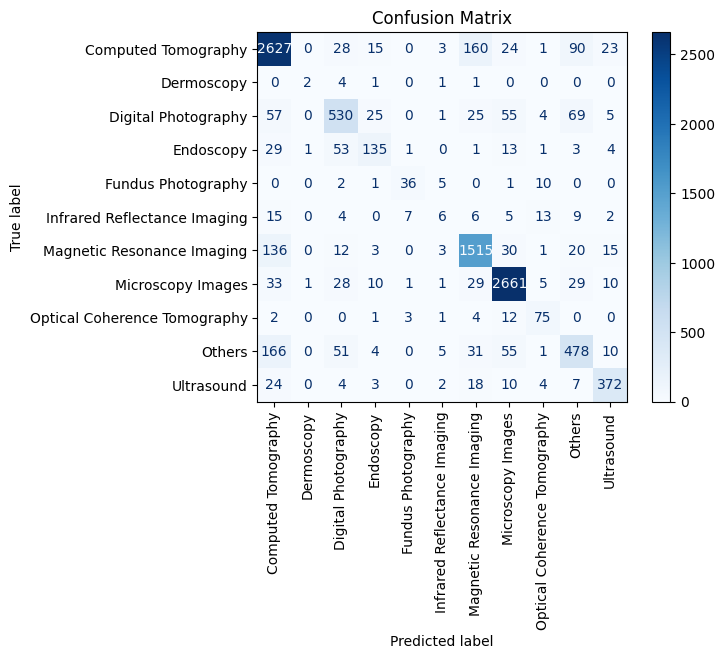

In [ ]:


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming 'trainer' has finished training and evaluation has been run
# and 'validation_dataset' is the dataset used for evaluation

# Get predictions for the validation dataset
eval_output = trainer.predict(validation_dataset)
predictions = np.argmax(eval_output.predictions, axis=-1)
labels = eval_output.label_ids

# Compute the confusion matrix
cm = confusion_matrix(labels, predictions)

# Display the confusion matrix
# Get the class names from the label encoder used previously
class_names = le_modality.classes_

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Apply label encoding (same encoder used for training)
test_df['modality_label'] = le_modality.transform(test_df['modality'])

# Clean text columns
for col in ['question', 'answer']:
    test_df[col] = test_df[col].fillna("").apply(preprocess_text)


# Wrap test_df into PubMedDataset
test_dataset = PubMedDataset(test_df, tokenizer, task='modality')


# Run prediction
test_output = trainer.predict(test_dataset)

# Get predicted and true labels
test_preds = np.argmax(test_output.predictions, axis=-1)
test_labels = test_output.label_ids


/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Test Accuracy: 0.680
Test F1-score (weighted): 0.655

Classification Report:

                              precision    recall  f1-score   support

         Computed Tomography       0.52      0.89      0.66        93
                  Dermoscopy       1.00      0.29      0.45        45
         Digital Photography       0.54      0.69      0.60        90
                   Endoscopy       0.84      0.57      0.68        91
          Fundus Photography       0.75      0.68      0.71        90
Infrared Reflectance Imaging       0.37      0.08      0.13        88
  Magnetic Resonance Imaging       0.72      0.88      0.79        92
           Microscopy Images       0.68      0.93      0.79        91
Optical Coherence Tomography       0.69      0.76      0.72        90
                      Others       0.73      0.63      0.68        90
                  Ultrasound       0.88      0.85      0.87        89

                    accuracy                           0.68       949
          

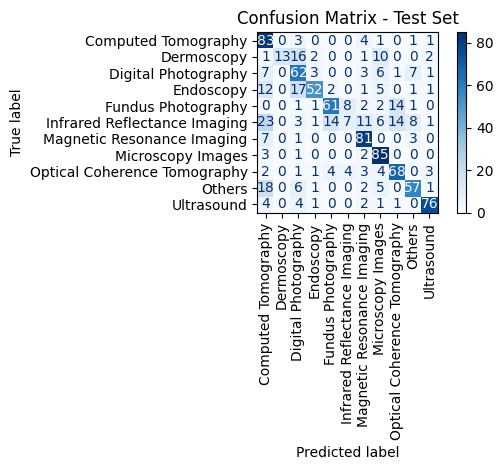

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Accuracy and F1
test_accuracy = accuracy_score(test_labels, test_preds)
test_f1 = f1_score(test_labels, test_preds, average='weighted')
print(f"Test Accuracy: {test_accuracy:.3f}")
print(f"Test F1-score (weighted): {test_f1:.3f}")

# Detailed classification report
print("\nClassification Report:\n")
print(classification_report(test_labels, test_preds, target_names=le_modality.classes_))

# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le_modality.classes_)
disp.plot(cmap="Blues", xticks_rotation=90)
plt.title("Confusion Matrix - Test Set")
plt.tight_layout()
plt.show()


In [ ]:
le = LabelEncoder()
le.fit(train_df["modality"])

# # Clean and filter training answers
# final_train_df = final_train_df[~final_train_df["answer"].apply(is_chinese)].copy()
# final_train_df["cleaned_answer"] = final_train_df["answer"].apply(clean_text)

# # Clean and filter test answers
# test_df = test_df[~test_df["answer"].apply(is_chinese)].copy()
# test_df["cleaned_answer"] = test_df["answer"].apply(clean_text)

# Use cleaned text
X_train = df["answer"]
y_train = le.transform(df["modality"])

X_test = test_df["answer"]
y_test = le.transform(test_df["modality"])

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm             import LinearSVC
import matplotlib.pyplot as plt

def build_linearsvc_pipeline(model, max_features=1000, ngram_range=(1,1)):
    tfidf = TfidfVectorizer(max_features=max_features, ngram_range=ngram_range)
    svc_pipe = Pipeline([
    ("tfidf", tfidf),
    ("clf",   model),])
    return svc_pipe

def run_linearsvc_experiment(model, le, max_features=1000, ngram_range=(1,1), stratify=True, random_state=42):

    pipe = build_linearsvc_pipeline(model, max_features, ngram_range)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    print(f"Model: {model.__class__.__name__}")
    print(classification_report(y_test, y_pred, target_names=le.classes_))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    disp.plot(xticks_rotation=90, cmap="Blues")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

Model: LinearSVC
                              precision    recall  f1-score   support

         Computed Tomography       0.47      0.88      0.61        93
                  Dermoscopy       0.00      0.00      0.00        45
         Digital Photography       0.50      0.71      0.59        90
                   Endoscopy       0.92      0.38      0.54        91
          Fundus Photography       0.74      0.66      0.69        90
Infrared Reflectance Imaging       0.60      0.03      0.06        88
  Magnetic Resonance Imaging       0.68      0.85      0.76        92
           Microscopy Images       0.46      0.87      0.60        91
Optical Coherence Tomography       0.64      0.57      0.60        90
                      Others       0.67      0.57      0.61        90
                  Ultrasound       0.84      0.79      0.81        89

                    accuracy                           0.60       949
                   macro avg       0.59      0.57      0.54       949
 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


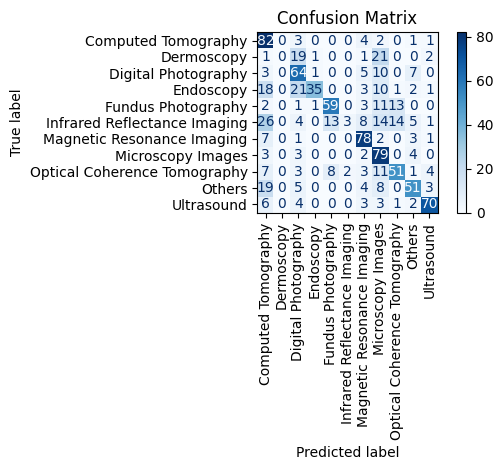

In [ ]:
lsvc = LinearSVC(C=0.3,max_iter=1000,random_state=42)
run_linearsvc_experiment(lsvc, le, max_features=10000, ngram_range=(1,2))

# LLM Evaluation

In [ ]:
import pandas as pd
import numpy as np
import os
import random
from huggingface_hub import InferenceClient
from tqdm import tqdm
import time
from datetime import datetime

## LLM Evaluation

### Configuration settings
- TARGET_COL: The column to predict ("modality")
- INPUT_COL: The input text column ("answer")
- OUTPUT_DIR: Directory for saving results
- TIMESTAMP: Current timestamp for file naming
- MODALITY_CLASSES: List of all possible medical imaging modalities
- MODELS: List of models to evaluate

In [ ]:
# Set random seed for reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Configuration
TARGET_COL = "modality"  # Change to "body_part" if needed
INPUT_COL = "answer"
OUTPUT_DIR = "evaluation_results"
os.makedirs(OUTPUT_DIR, exist_ok=True)
API_KEY = "**"
ENDPOIT_URL = ""


# Create timestamp for this run
TIMESTAMP = datetime.now().strftime("%Y%m%d_%H%M%S")


MODALITY_CLASSES = [
    'Computed Tomography',
    'Microscopy Images',
    'Magnetic Resonance Imaging',
    'Others',
    'Digital Photography',
    'Ultrasound',
    'Endoscopy',
    'Optical Coherence Tomography',
    'Infrared Reflectance Imaging',
    'Fundus Photography',
    'Dermoscopy'
]


# Model endpoints to evaluate
MODELS = [
    "mistralai/Mistral-7B-Instruct-v0.3",
    "meta-llama/Llama-3.1-8B-Instruct",
    "Qwen/Qwen2.5-7B-Instruct"
]

EXAMPLES = {'Computed Tomography': [['In the provided CT scan, the right subclavian artery is the anatomical structure observed traveling posterior to the esophagus. The positioning of the subclavian artery relative to the esophagus is crucial for understanding potential vascular or esophageal pathologies and their implications. This anatomical relationship is significant for both diagnostic imaging and potential surgical planning.', 'Computed Tomography']], 'Dermoscopy': [['The circumscribed area in image (b) highlights a region with an increased density of pathological features, possibly indicating a focal point of disease activity or a region with enhanced diagnostic significance. The distinct boundary of this area might be useful for differentiating disease patterns or assessing the extent of involvement.', 'Dermoscopy']], 'Digital Photography': [["Switching to a regimen of DRV/r (ritonavir-boosted darunavir) 800/100 mg daily combined with two nucleoside reverse transcriptase inhibitors (NRTIs) in the scenario of a viral load exceeding 1000 copies/mL is a strategic move to address the failure of the initial NNRTI or InSTI-based regimen. The choice of DRV/r, a potent protease inhibitor, is typically due to its high barrier to resistance and efficacy in reducing viral loads, which can be critical in patients not responding adequately to their first-line treatment. The addition of two NRTIs helps to ensure a broader antiviral effect and prevent the emergence of resistance. This approach aims at optimizing therapeutic outcomes by tailoring the treatment based on the patient's response measured through viral load metrics.", 'Digital Photography']], 'Endoscopy': [["I understand your concerns, and it's important to address them thoroughly. The endoscopic image shows significant abnormalities in the lining of your stomach. The tissue appears irregular and nodular, with areas of ulceration and discoloration, which are signs of a malignant lesion. This suggests the presence of a tumor, likely a combination of neuroendocrine carcinoma and moderately differentiated adenocarcinoma. These types of cancers can be aggressive and require prompt treatment. The irregular surface and areas of necrosis indicate that the tumor is affecting the stomach's normal structure and function. It’s crucial to follow up with the recommended treatments to manage this condition effectively. If you have any more questions or need further clarification, please feel free to ask.", 'Endoscopy']], 'Fundus Photography': [['Upon examining the provided retinal images, the color fundus photograph shows a noticeable macular hole characterized by a circular dark area at the fovea. The surrounding retinal tissue appears slightly elevated and irregular. The SD-OCT scan reveals a cross-sectional view of the retina with a prominent macular hole. The scan shows elevated edges around the hole, indicating retinal tissue separation. Additionally, a small operculum is visible on the roof of the macular hole. The magnified section of the scan highlights disruption in the four external retinal layers, including the RPE, photoreceptor layer, ELM, and IS/OS junction. Based on these observations, the potential diagnosis is a full-thickness macular hole, which is confirmed by the presence of the operculum and the detailed disruption seen in the SD-OCT scan.', 'Fundus Photography']], 'Infrared Reflectance Imaging': [["In panel 'b', we see two distinct vascular patterns. The left segment shows a solitary trunk vessel without any small branching, which might suggest a condition of avascular or hypoperfused tissue, indicating insufficient blood supply or potential arterial blockage. On the other hand, the right segment shows a rich network of branching vessels around a central vessel, marked with a red arrow. This could indicate a hyperperfused area where excessive blood supply, potentially from a high-pressure source, is present. Such conditions could be indicative of arteriovenous malformation (AVM) or reactive angiogenesis in response to tissue injury or inflammation.", 'Infrared Reflectance Imaging']], 'Magnetic Resonance Imaging': [['In section D of the images, the sagittal view denotes a disruption in the continuance of the corpus callosum, as emphasized by the red pointer. This could imply a form of callosal dysgenesis, which can affect interhemispheric communication, potentially leading to neurodevelopmental disorders or cognitive impairments. Section E highlights cavum septum pellucidum and cavum vergae with yellow pointers, which are anomalies associated with the midline structures of the brain. While often incidentally found and asymptomatic, their presence can sometimes be associated with other developmental abnormalities or neurological problems.', 'Magnetic Resonance Imaging']], 'Microscopy Images': [['The mucosal layer in the image appears well-preserved with a continuous and intact epithelial lining. The presence of goblet cells within the epithelium is a significant detail, indicating a healthy state as these cells are responsible for secreting mucus to protect the gastrointestinal tract. The absence of disruptive inflammation or abnormal cellular structures also suggests that the mucosa is in a normal state.', 'Microscopy Images']], 'Optical Coherence Tomography': [['Student: The OCT image segmentation provides detailed views of the lumen contours and the positions of stent struts. Accurate visualization of these features allows us to assess whether the stent is appropriately positioned and fully expanded, ensuring that it covers the diseased segment properly without any gaps or malappositions. Such detailed analysis can help predict the efficacy of the stent in restoring normal blood flow and minimizing risks like restenosis or thrombosis.', 'Optical Coherence Tomography']], 'Others': [['Yes, you are correct in observing that the QRS complexes are wider. This typically indicates a delay in the ventricular conduction system. Possible causes include left or right bundle branch block, or other conduction delays like those caused by hyperkalemia or structural cardiac abnormalities. The prolonged PR interval and left axis deviation also seen in the ECG can be associated with conditions that affect atrial and ventricular conduction or the cardiac conduction axis, such as underlying heart disease. Detailed clinical correlation and potentially further diagnostic investigations are advised to determine the exact cause of these findings.', 'Others']], 'Ultrasound': [["The 'hyperechoic line' noted in your ultrasound is a significant feature that helps in distinguishing the exact origin and nature of the cyst. In your case, it helps to identify the cyst as paraovarian, meaning it is not originating from the ovary itself but adjacent to it. This line is essentially a bright, reflective boundary seen on ultrasound that denotes a clear separation between the cyst and the ovarian tissue. Its presence is beneficial as it suggests that the mass is likely benign and well-demarcated, which aids in surgical planning and management by providing a clear target area for procedures, reducing the risk of damaging surrounding structures.", 'Ultrasound']]}

### Data handling
- load_data(): Loads the dataset from CSV
- get_class_examples(): Creates few-shot examples for each class

In [ ]:
def load_data(file_path):
    """Load the dataset from a CSV file."""
    df = pd.read_csv(file_path)
    print(f"Loaded dataset with {len(df)} samples")
    print(f"Unique {TARGET_COL} classes: {df[TARGET_COL].unique()}")
    return df

def get_class_examples(df, num_examples_per_class=3):
    """Extract few examples for each class to use in few-shot prompting."""
    examples = {}
    for class_name in df[TARGET_COL].unique():
        # Get samples for this class
        class_samples = df[df[TARGET_COL] == class_name].sample(
            n=min(num_examples_per_class, sum(df[TARGET_COL] == class_name)),
            random_state=RANDOM_SEED
        )
        examples[class_name] = class_samples[[INPUT_COL, TARGET_COL]].values.tolist()
    return examples

### Prompts
- create_zero_shot_prompt(): Creates prompts without examples
- create_few_shot_prompt(): Creates prompts with example cases

In [ ]:
def create_zero_shot_prompt(text):
    """Create a zero-shot prompt for classification."""
    return f"""You are a medical imaging expert. You are given an description of a medical image.
Your task is to find and classify the modality of the image based on the text into one of the followings:
{MODALITY_CLASSES}
Respond with ONLY one element of the list, nothing else.

Text: {text}
Modality: """

def create_few_shot_prompt(text, examples):
    """Create a few-shot prompt with examples for classification."""
    prompt = f"""You are a medical imaging expert. You are given an description of a medical image.
Your task is to find and classify the modality of the image based on the text into one of the followings:
{MODALITY_CLASSES}

Respond with ONLY one element of the list, nothing else.

Here are some examples:

"""
    # Add examples
    for class_name, class_examples in examples.items():
        for example in class_examples:
            prompt += f"Text: {example[0]}\nModality: {example[1]}\n\n"

    # Add the test instance
    prompt += f"""
Respond with ONLY one element of the list, nothing else.
Now classify this text:
Text: {text}
Modality:
"""
    return prompt

In [ ]:
print(create_zero_shot_prompt("<TEST>"))

You are a medical imaging expert. You are given an description of a medical image.
Your task is to find and classify the modality of the image based on the text into one of the followings:
['Computed Tomography', 'Microscopy Images', 'Magnetic Resonance Imaging', 'Others', 'Digital Photography', 'Ultrasound', 'Endoscopy', 'Optical Coherence Tomography', 'Infrared Reflectance Imaging', 'Fundus Photography', 'Dermoscopy']
Respond with ONLY one element of the list, nothing else.

Text: <TEST>
Modality: 


In [ ]:
print(create_few_shot_prompt("<TEST>", EXAMPLES))

You are a medical imaging expert. You are given an description of a medical image.
Your task is to find and classify the modality of the image based on the text into one of the followings:
['Computed Tomography', 'Microscopy Images', 'Magnetic Resonance Imaging', 'Others', 'Digital Photography', 'Ultrasound', 'Endoscopy', 'Optical Coherence Tomography', 'Infrared Reflectance Imaging', 'Fundus Photography', 'Dermoscopy']

Respond with ONLY one element of the list, nothing else.

Here are some examples:

Text: In the provided CT scan, the right subclavian artery is the anatomical structure observed traveling posterior to the esophagus. The positioning of the subclavian artery relative to the esophagus is crucial for understanding potential vascular or esophageal pathologies and their implications. This anatomical relationship is significant for both diagnostic imaging and potential surgical planning.
Modality: Computed Tomography

Text: The circumscribed area in image (b) highlights a re

### Querying Model
- query_hf_model(): Queries models using Huggingface's Inference API
- query_hf_model2(): Alternative implementation using Together AI provider

In [ ]:
def query_hf_model(prompt, model_id, client):
    """Query a model using Huggingface's Inference API."""

    try:
        response = client.text_generation(
            prompt=prompt,
            max_new_tokens=50,
            temperature=0.1,  # Low temperature for more deterministic responses
            # repetition_penalty=1.05
        )
        return response.strip()
    except Exception as e:
        print(f"Error querying model {model_id}: {e}")
        return "ERROR"

def query_hf_model2(prompt, model_id):
    """Query a model using Huggingface's Together AI provider."""
    try:
        client = InferenceClient(
            provider="fireworks-ai",
            api_key=API_KEY,  # Replace with your actual API key
        )

        # Convert the prompt into a chat format
            # For zero-shot, simpler format
        completion = client.chat.completions.create(
            model=model_id,
            messages=[
                {
                    "role": "user",
                    "content": prompt
                }
            ],
            temperature=0.1,  # Low temperature for more deterministic responses
            max_tokens=50
        )

        # Extract the response text
        response = completion.choices[0].message.content.strip()
        return response
    except Exception as e:
        print(f"Error querying model {model_id}: {e}")
        return "ERROR"

### Evaluations and saving results
- run_evaluation(): Main evaluation function that processes the dataset
- save_results(): Saves evaluation results to CSV files

In [ ]:
def run_evaluation(df, model_id, shot_type="zero-shot", examples=None):
    """Run evaluation on the dataset and save raw results."""
    results = []
    client = InferenceClient(ENDPOIT_URL, token=API_KEY)

    for i, row in tqdm(df.iterrows(), total=len(df), desc=f"Evaluating {model_id} ({shot_type})"):
        # Generate unique ID for this sample
        sample_id = row['id']

        # Generate prompt based on shot type
        if shot_type == "zero-shot":
            prompt = create_zero_shot_prompt(row[INPUT_COL], TARGET_COL)
        else:  # few-shot
            prompt = create_few_shot_prompt(row[INPUT_COL], examples, TARGET_COL)

        # Query model
        start_time = time.time()

        response = query_hf_model(prompt, model_id, client)
        elapsed_time = time.time() - start_time

        # Store result with original row data
        result = {
            "sample_id": sample_id,
            "model": model_id,
            "setting": shot_type,
            "input_text": row[INPUT_COL],
            "true_class": row[TARGET_COL],
            "prompt": prompt,
            "response": response,
            # "response_time": elapsed_time
        }

        # Add all original columns from the dataframe
        for col in df.columns:
            if col not in result:
                result[f"original_{col}"] = row[col]

        results.append(result)

        # Sleep to avoid rate limiting
        # time.sleep(0.5)

    return results

def save_results(results, filename):
    """Save results to a CSV file."""
    results_df = pd.DataFrame(results)
    results_df.to_csv(filename, index=False)
    print(f"Saved results to {filename}")
    return results_df

### Main

In [ ]:
# Load data
data_path = ''
df = load_data(data_path)

# Get examples for few-shot evaluation
few_shot_examples = get_class_examples(df, num_examples_per_class=1)
print(few_shot_examples)

# Save few-shot examples for reference
few_shot_df = pd.DataFrame({
    "class": [k for k, v in few_shot_examples.items() for _ in v],
    "example_text": [e[0] for v in few_shot_examples.values() for e in v],
    "example_class": [e[1] for v in few_shot_examples.values() for e in v]
})
few_shot_df.to_csv(f"{OUTPUT_DIR}/few_shot_examples_{TIMESTAMP}.csv", index=False)
all_results = []

for model_id in MODELS:
    model_name = model_id.split('/')[-1]

    # Zero-shot evaluation
    print(f"\nRunning {model_name} in zero-shot setting...")
    zero_shot_results = run_evaluation(df, model_id, "zero-shot")
    all_results.extend(zero_shot_results)

    # Save intermediate results for this model and setting
    save_results(
        zero_shot_results,
        f"{OUTPUT_DIR}/{model_name}_zero_shot_{TIMESTAMP}.csv"
    )

    # Few-shot evaluation
    print(f"\nRunning {model_name} in few-shot setting...")
    few_shot_results = run_evaluation(
        df, model_id, "few-shot", few_shot_examples
    )
    all_results.extend(few_shot_results)

    # Save intermediate results for this model and setting
    save_results(
        few_shot_results,
        f"{OUTPUT_DIR}/{model_name}_few_shot_{TIMESTAMP}.csv"
    )

# Save all results together
save_results(all_results, f"{OUTPUT_DIR}/all_results_{TIMESTAMP}.csv")
print("\nEvaluation complete!")

## LLM Results

### PATHS
 - MODELS_DICT: Dictionary containing paths to different model evaluation results
 - Each key represents a model and its setting (zero-shot/few-shot)
 - Each value is the path to the corresponding CSV file

In [ ]:
MODELS_DICT = {
    # 'Mistral-7B-Instruct-v0.3_zero_shot': 'evaluation_results\Mistral-7B-Instruct-v0.3_zero_shot_20250518_193104.csv',
    # 'Mistral-7B-Instruct-v0.3_few_shot': 'evaluation_results\Mistral-7B-Instruct-v0.3_few_shot_20250518_193104.csv',
    # 'Qwen2.5-7B-Instruct_zero_shot': 'evaluation_results\Qwen2.5-7B-Instruct_zero_shot_20250519_085634.csv',
    # 'Qwen2.5-7B-Instruct_few_shot': 'evaluation_results\Qwen2.5-7B-Instruct_few_shot_20250519_085808.csv',
    # 'Llama-3.1-8B-Instruct_zero_shot': 'evaluation_results\Llama-3.1-8B-Instruct_zero_shot_20250518_202309.csv',
    # 'Llama-3.1-8B-Instruct_few_shot': 'evaluation_results\Llama-3.1-8B-Instruct_few_shot_20250518_202309.csv'
    # 'claude_zero_shot': 'evaluation_results\claude_zero_shot_20250520_094158.csv'
    'claude_few_shot': 'evaluation_results\claude_few_shot_20250520_095332.csv'
}

### Processing model responses
 - extract_answer(): Function that:
   - Shuffles modality classes to avoid **position bias**
   - Searches for modality matches in the response
   - Returns the matched modality or None if no match found

In [ ]:
def extract_answer(response):
    random.shuffle(MODALITY_CLASSES)
    for modality in MODALITY_CLASSES:
        if modality.lower() in response.lower():
            return modality
        # print(response)
    return None

### Main processing
 - Iterates through each model's results
 - Processes responses to extract predictions
 - Tracks undetected responses
 - Creates new predictions column
 - Saves processed results to new CSV files

In [ ]:
for key in MODELS_DICT:
    PATH = MODELS_DICT[key]
    not_detected = 0
    asn_list = []
    df = pd.read_csv(PATH)
    for idx, row in df.iterrows():
        response = row['response']
        # print(f"{idx}: {response}\n")
        answer = extract_answer(response)

        if not answer:
            not_detected += 1
            asn_list.append("NORESP")
        else:
            asn_list.append(answer)
    # print(f"{key}: {not_detected} Errors!")
    df['pred'] = asn_list
    # df = df.drop(['prompt', 'response', 'original_question', 'original_answer', 'input_text', 'original_modality', 'original_body_part'], axis=1)
    df = df.drop(['response', 'original_question', 'original_answer', 'input_text', 'original_modality', 'original_body_part'], axis=1)
    SAVE_PATH = f'preds/{key}_preds.csv'
    # print(SAVE_PATH)
    df.to_csv(SAVE_PATH)

## LLM Performance

In [ ]:
import pandas as pd
import ast
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

Let's download our test_data for the baseline

In [ ]:
!gdown 1E6OgOsN5NDxhLECBoVI42_hjx8GbHNHg

Let's download our prediction data.

In [ ]:
!gdown https://drive.google.com/drive/folders/1CkOTudvvY3BLUXg8geCwzScht_MIMjA4 -O /content/preds --folder

In [ ]:
model_names = ["Mistral-7B-Instruct-v0.3", "Qwen2.5-7B-Instruct", "Llama-3.1-8B-Instruct", "claude-3-7-sonnet-20250219"]
experiment_types = ["zero_shot", "few_shot"]

### Performance metrics
 - calculate_metrics(): Function that computes:
   - Accuracy
   - F1 Score
   - Precision
   - Recall

 - All metrics are weighted to handle multi-class classification

In [ ]:
def calculate_metrics(true_labels, pred_labels):
    accuracy = accuracy_score(true_labels, pred_labels)
    f1 = f1_score(true_labels, pred_labels, average='weighted')
    f1_m = f1_score(true_labels, pred_labels, average='macro')
    precision = precision_score(true_labels, pred_labels, average='weighted')
    recall = recall_score(true_labels, pred_labels, average='weighted')

    return {
        'Accuracy': accuracy,
        'F1 Score - Weighted': f1,
        'F1 Score - Macro': f1_m,
        'Precision': precision,
        'Recall': recall
    }

First, let's establish a baseline by checking whether the modality name exists in the 'answer' column, which serves as our input.

In [ ]:
df = pd.read_csv('/content/test_data_f.csv')

MODALITY_CLASSES_COUNT ={
    'Computed Tomography': 0,
    'Microscopy Images':0,
    'Magnetic Resonance Imaging':0,
    'Others':0,
    'Digital Photography':0,
    'Ultrasound':0,
    'Endoscopy':0,
    'Optical Coherence Tomography':0,
    'Infrared Reflectance Imaging':0,
    'Fundus Photography':0,
    'Dermoscopy':0
}

for index, row in df.iterrows():
    question = row['question']
    answer = row['answer']
    for modality in MODALITY_CLASSES_COUNT.keys():
        if modality.lower() in answer.lower():
            MODALITY_CLASSES_COUNT[modality] += 1

print(sum(MODALITY_CLASSES_COUNT.values()))
print(sum(MODALITY_CLASSES_COUNT.values())*100/len(df))

87
9.167544783983141


As we saw, the baseline line will be around 9%

In [ ]:
# Store results
results = {}

# Load data and calculate metrics for each model and experiment
for model in model_names:
    results[model] = {}

    for exp_type in experiment_types:
        file_path = f"preds/{model}_{exp_type}_preds.csv"

        # Load the CSV
        df = pd.read_csv(file_path)
        df = df[df['pred'] != "NORESP"]
        # Calculate metrics
        metrics = calculate_metrics(df['true_class'], df['pred'])
        results[model][exp_type] = {
            'metrics': metrics,
            'true_labels': df['true_class'],
            'pred_labels': df['pred']
        }

# Print metrics for each model and experiment
for model in model_names:
    # print(f"\n=== {model} ===")

    for exp_type in experiment_types:
        model_res = ""
        model_res += f"Model: {model} -- {exp_type.replace('_', ' ').title()}:"
        # print(f"\n{exp_type.replace('_', ' ').title()}:")
        metrics = results[model][exp_type]['metrics']

        for metric_name, value in metrics.items():
            model_res += f"{metric_name}: {value:.4f} "
            # print(f"{metric_name}: {value:.4f}")

        print(f"{model_res}\n")

# Get all unique classes across all datasets
all_classes = set()
for model in model_names:
    for exp_type in experiment_types:
        all_classes.update(results[model][exp_type]['true_labels'])
        all_classes.update(results[model][exp_type]['pred_labels'])
all_classes = sorted(list(all_classes))

Model: Mistral-7B-Instruct-v0.3 -- Zero Shot:Accuracy: 0.5357 F1 Score - Weighted: 0.4928 F1 Score - Macro: 0.4943 Precision: 0.5465 Recall: 0.5357 

Model: Mistral-7B-Instruct-v0.3 -- Few Shot:Accuracy: 0.5571 F1 Score - Weighted: 0.5191 F1 Score - Macro: 0.5239 Precision: 0.5683 Recall: 0.5571 

Model: Qwen2.5-7B-Instruct -- Zero Shot:Accuracy: 0.5215 F1 Score - Weighted: 0.4815 F1 Score - Macro: 0.4850 Precision: 0.5352 Recall: 0.5215 

Model: Qwen2.5-7B-Instruct -- Few Shot:Accuracy: 0.4796 F1 Score - Weighted: 0.4362 F1 Score - Macro: 0.4344 Precision: 0.4523 Recall: 0.4796 

Model: Llama-3.1-8B-Instruct -- Zero Shot:Accuracy: 0.1037 F1 Score - Weighted: 0.0978 F1 Score - Macro: 0.0932 Precision: 0.0963 Recall: 0.1037 

Model: Llama-3.1-8B-Instruct -- Few Shot:Accuracy: 0.5059 F1 Score - Weighted: 0.4628 F1 Score - Macro: 0.4647 Precision: 0.5068 Recall: 0.5059 

Model: claude-3-7-sonnet-20250219 -- Zero Shot:Accuracy: 0.6779 F1 Score - Weighted: 0.6496 F1 Score - Macro: 0.6487 Pr

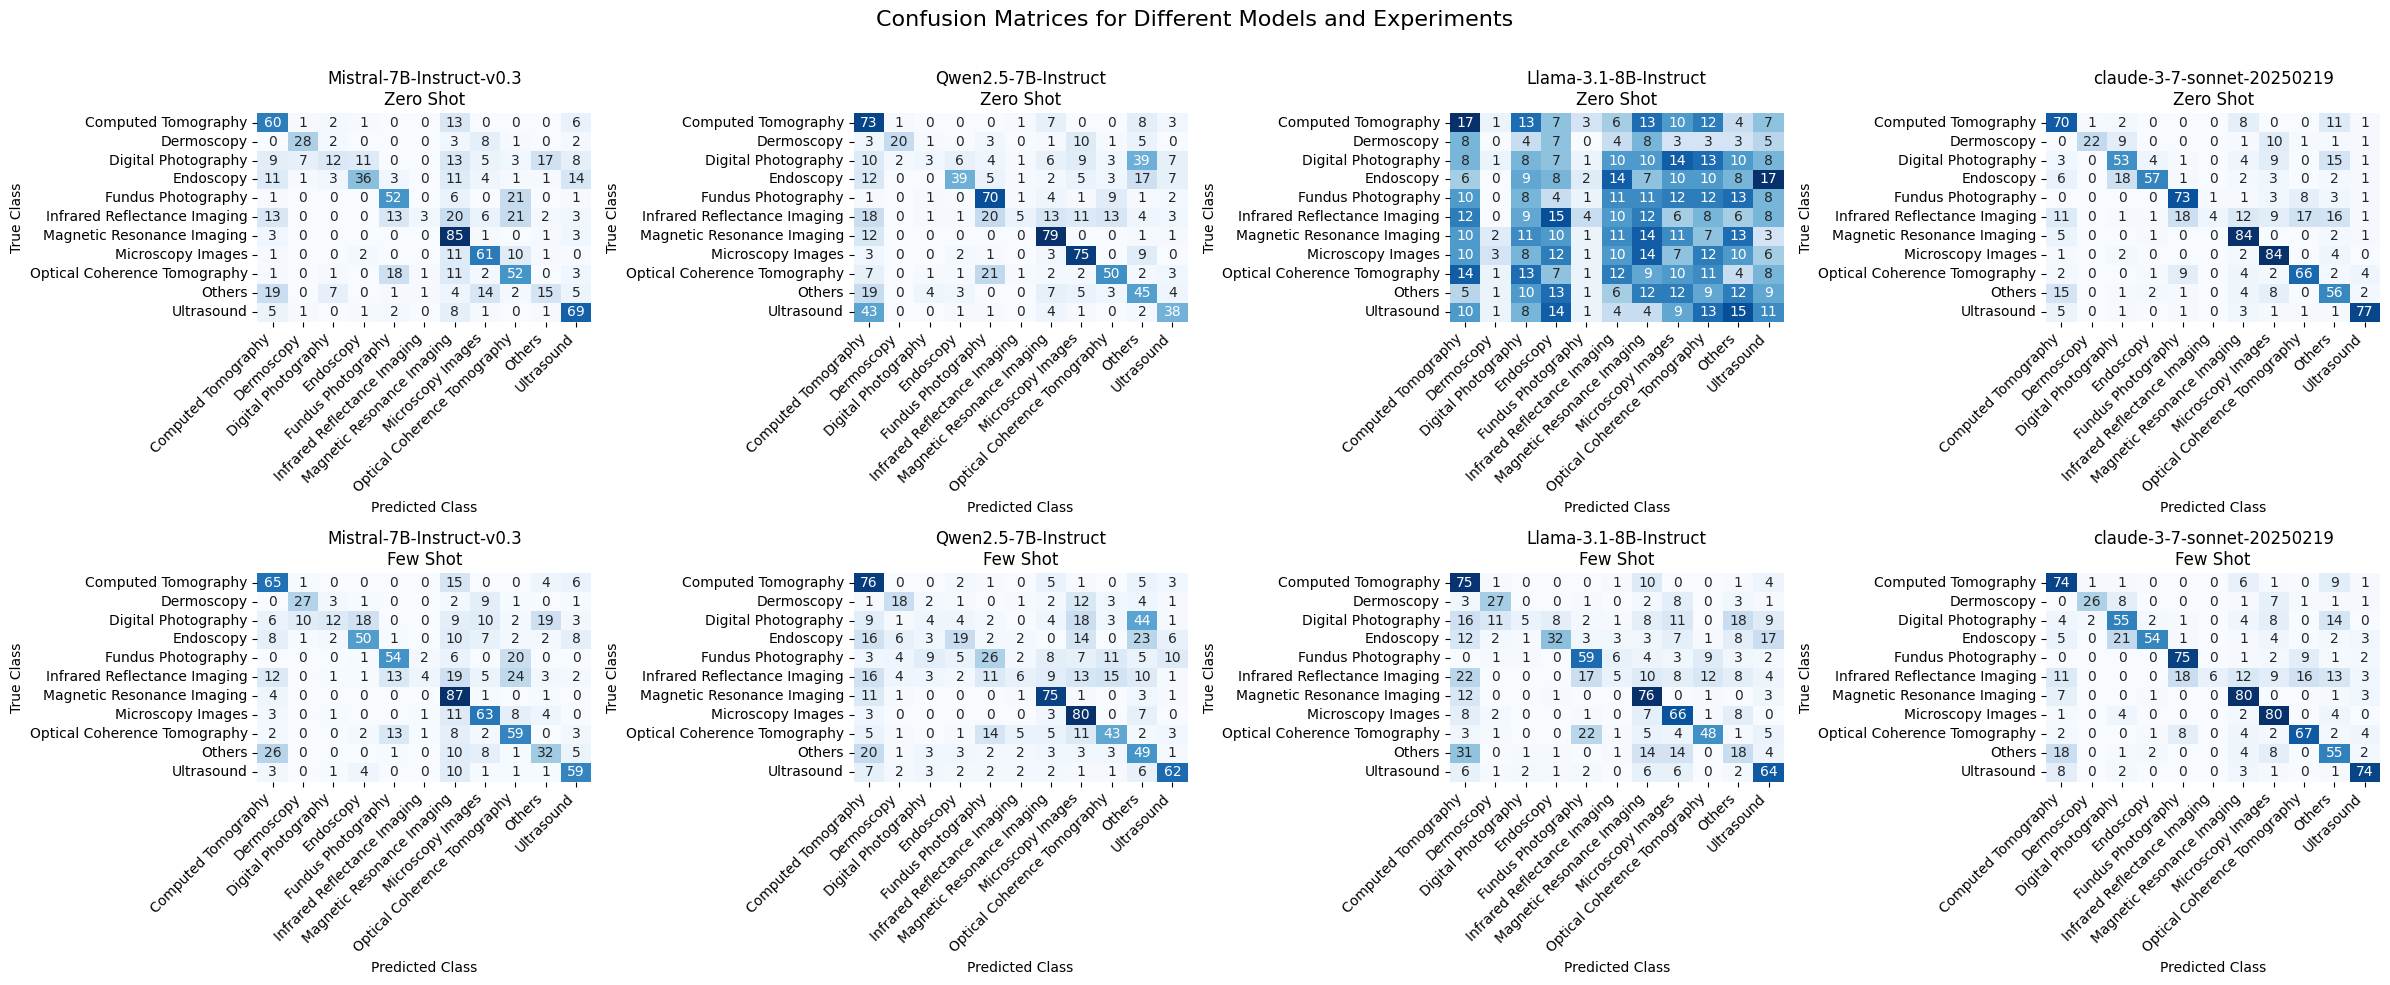

In [ ]:
# 1. Create and save confusion matrices with integer counts (one combined view)
plt.figure(figsize=(24, 10))

# Create subplots
for i, exp_type in enumerate(experiment_types):
    for j, model in enumerate(model_names):
        plt.subplot(2, 4, i * 4 + j + 1)

        true_labels = results[model][exp_type]['true_labels']
        pred_labels = results[model][exp_type]['pred_labels']

        # Create confusion matrix with integer counts
        cm = confusion_matrix(true_labels, pred_labels, labels=all_classes)

        # Plot heatmap with integer counts
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=all_classes, yticklabels=all_classes, cbar=False)

        plt.title(f"{model}\n{exp_type.replace('_', ' ').title()}")
        plt.ylabel('True Class')
        plt.xlabel('Predicted Class')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()

plt.suptitle('Confusion Matrices for Different Models and Experiments', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
# plt.savefig('confusion_matrices_all.svg', dpi=300, bbox_inches='tight')
plt.show()



# Comparing ML models, fine-tuned models and L


| Model                          | Prompt Type | Accuracy | F1-score (Macro) | F1-score (Weighted) |
| ------------------------------ | --------- | -------- | ---------------- | ------------------- |
| **claude-3-7-sonnet-20250219** | Few Shot  | **0.68** | **0.66**         | **0.66**            |
| **claude-3-7-sonnet-20250219** | Zero Shot | **0.68** | 0.65             | 0.65                |
| **PubMedBERT**                 | N/A       | **0.68** | 0.64             | 0.65                |
| **Mistral-7B-Instruct-v0.3**   | Few Shot  | 0.56     | 0.52             | 0.52                |
| **LinearSVC**                  | N/A       | 0.60     | 0.54             | 0.56                |
| **Mistral-7B-Instruct-v0.3**   | Zero Shot | 0.54     | 0.49             | 0.49                |
| **Qwen2.5-7B-Instruct**        | Zero Shot | 0.52     | 0.49             | 0.48                |
| **Llama-3.1-8B-Instruct**      | Few Shot  | 0.51     | 0.46             | 0.46                |
| **Qwen2.5-7B-Instruct**        | Few Shot  | 0.48     | 0.43             | 0.44                |
| **Llama-3.1-8B-Instruct**      | Zero Shot | 0.10     | 0.09             | 0.10                |


### Model Performance Analysis

Among all evaluated models, **Claude 3 Sonnet (Few Shot)** achieves the highest performance across all three metrics:  
- **Accuracy:** 0.68 (tied with PubMedBERT and Claude Zero Shot)  
- **F1-score (Macro):** **0.66** (best overall)  
- **F1-score (Weighted):** **0.66** (best overall)  

**PubMedBERT**, a domain-specific model, also performs very well, matching the top **accuracy** (0.68) and achieving competitive F1 scores (0.64 macro, 0.65 weighted), highlighting its strength in biomedical contexts.

**Mistral-7B-Instruct** shows decent results, with its few-shot setting outperforming its zero-shot variant. **Qwen2.5-7B-Instruct** and **Llama-3.1-8B-Instruct** underperform relative to others, especially in the zero-shot setting, where **Llama-3.1** struggles significantly (accuracy 0.10).

**LinearSVC**, a traditional baseline, delivers moderate performance—better than some large models in zero-shot setups—demonstrating that classical methods can still be competitive in certain cases.
